# 1. Introdução

Este notebook tem como objetivo realizar uma análise detalhada dos dados relacionados ao **registro de notas dos alunos da Universidad EAFIT**, juntamente com suas informações cadastrais, a fim de identificar a **probabilidade de reprovação**.  
Por meio desta análise, buscamos compreender como esses dados se relacionam entre si e como podem ser utilizados para o desenvolvimento de um **modelo preditivo** que auxilie na detecção precoce de alunos em risco acadêmico.  

Dessa forma, espera-se não apenas mitigar riscos de reprovação, mas também fornecer subsídios para **fortalecer a atuação docente** e **impulsionar a eficiência institucional** no acompanhamento estudantil.

---

## 1.1 Objetivos

Os principais objetivos deste notebook são:

1. **Explorar e compreender os dados**: Avaliar a qualidade das informações cadastrais e acadêmicas.  
2. **Identificar padrões**: Detectar tendências que possam indicar risco de reprovação.  
3. **Desenvolver um modelo preditivo**: Construir um modelo capaz de prever a probabilidade de reprovação com base nos padrões identificados.  
4. **Gerar insights para a universidade**: Fornecer recomendações que auxiliem a tomada de decisão dos docentes e gestores, aprimorando o monitoramento do desempenho dos alunos.  


# 2. Confiiguração do ambiente

Importando todas as bibliotecas que serão utilizadas ao longo do notebook 

Obs: Se estiver utilizando MacOs, pode ser necessário instalar `brew install libomp` para evitar erros com o `xgboost`

In [2]:
# Importa as bibliotecas necessárias
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, mean_squared_error
from pathlib import Path
from datetime import datetime
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    average_precision_score, precision_recall_curve, balanced_accuracy_score
)
from sklearn.metrics.pairwise import pairwise_distances
from lazypredict.Supervised import LazyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
import scipy.stats as stats
import os 
import shap
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestCentroid

In [3]:
# Lê os dados em CSV e transforma em dataframes
df_semester1 = pd.read_csv(r"../assets/dataset/data-semester-20231.csv")
df_semester2 = pd.read_csv(r"../assets/dataset/data-semester-20232.csv")

# Une os dados de ambos semestres
df = pd.concat([df_semester1, df_semester2], ignore_index=True)

# 3. Pré-processamento

Entende-se por "pré-processamento de dados" o processo responsável por converter dados brutos em dados que podem, de fato, ser utilizados em projetos de análise de dados, sendo essa uma etapa indispensável para a realização da análise e modelagem dos dados. Dessa forma, o pré-processamento se faz importantíssimo, uma vez que utilizar dados não-preparados faz com que os resultados do modelo preditivo fiquem muito aquém do esperado. Portanto, realizar uma boa higienização dos dados garante um processo de modelagem mais confiável e robusto.

## 3.1. Tranformação das Variáveis Erroneamente Categóricas para Numéricas


Ao analisar as variáveis categóricas, foi possível identificar que algumas delas, na verdade, deveriam ser do tipo numérico. Dessa forma, essas variáveis foram convertidas para o tipo correto.

In [4]:
# Colunas de notas a converter para float
grade_columns = [
    'Parcial_1', 'Parcial_2', 'Proyecto_Parte1', 'Proyecto_Parte2', 'Talleres', 'Quices',
    'Quiz1', 'Quiz2', 'Quiz3', 'Quiz4', 'Quiz5', 'Quiz6', 'Quiz7',
    'CalcNotaQuiz', 'Cuánto mejora?', 'Calificación_Oficial'
]

for col in grade_columns:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '.')
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Colunas de tempos a converter para segundos (int)
time_columns = ['TiempoQ1', 'TiempoQ2', 'TiempoQ3', 'TiempoQ4', 'TiempoQ5', 'TiempoQ6', 'TiempoQ7']

def parse_time(t):
    if pd.isna(t):
        return np.nan
    t = str(t).strip()
    if t == '#N/A' or t == '':
        return np.nan
    if t.isdigit():
        return int(t)
    if 'horas' in t:
        numbers = re.findall(r'\d+', t)
        if len(numbers) >= 2:
            horas = int(numbers[0])
            minutos = int(numbers[1])
            return horas * 3600 + minutos * 60
    numbers = re.findall(r'\d+', t)
    if len(numbers) == 1:
        if 'minutos' in t or 'minuto' in t:
            return int(numbers[0]) * 60
        else:
            return int(numbers[0])
    elif len(numbers) == 2:
        return int(numbers[0]) * 60 + int(numbers[1])
    else:
        return np.nan

for col in time_columns:
    if col in df.columns:
        df[col] = df[col].apply(parse_time).astype('Int64')  # Usa Int64 para permitir NaN

# Verifique os novos tipos de dados
print(df.dtypes)
df.head()


Periodo                       object
Grupo                          int64
Horario                       object
Tipo_Documento                object
Edad                          object
Genero                        object
Nombre_Programa_Academico     object
STEM                          object
Parcial_1                    float64
Parcial_2                    float64
Proyecto_Parte1              float64
Proyecto_Parte2              float64
Talleres                     float64
Quices                       float64
Fecha_Quiz1                   object
Quiz1                        float64
TiempoQ1                       Int64
Fecha_Quiz2                   object
Quiz2                        float64
TiempoQ2                       Int64
Fecha_Quiz3                   object
Quiz3                        float64
TiempoQ3                       Int64
Fecha_Quiz4                   object
Quiz4                        float64
TiempoQ4                       Int64
Fecha_Quiz5                   object
Q

Periodo  Grupo                       Horario Tipo_Documento   Edad  \
0  2023-1     11  Viernes de 03:00PM a 06:00PM             CC  Mayor   
1  2023-1     16   Jueves de 06:00PM a 09:00PM             CC  Mayor   
2  2023-1     11  Viernes de 03:00PM a 06:00PM             CC  Mayor   
3  2023-1      7   Jueves de 12:00PM a 03:00PM             CC  Mayor   
4  2023-1     11  Viernes de 03:00PM a 06:00PM             TI  Menor   

      Genero   Nombre_Programa_Academico STEM  Parcial_1  Parcial_2  ...  \
0   femenino         COMUNICACIÓN SOCIAL   NO       4.20       0.00  ...   
1   femenino                     DERECHO   NO       3.75       5.00  ...   
2  masculino            INGENIERÍA CIVIL   SI       0.00       0.00  ...   
3   femenino  ADMINISTRACIÓN DE NEGOCIOS   NO       2.80       3.50  ...   
4  masculino            INGENIERÍA CIVIL   SI       1.80       0.00  ...   

   TiempoQ6              Fecha_Quiz7  Quiz7  TiempoQ7 Quiz8  CalcNotaQuiz  \
0       600                      NaN   0.00       600     5          1.56   
1       133                      NaN   0.00       600     5          2.66   
2       105                      NaN   0.00       600     5          1.28   
3       340  4 de May de 2023  13:37   5.00       124     5          3.13   
4       600                      NaN   0.00       600     5          2.50   

   MejoraNotaQuices Cuánto mejora?  Calificación_Oficial   Aprobo  
0         VERDADERO           2.74                  2.70  Reprobó  
1         VERDADERO           2.34                  3.00   Aprobó  
2         VERDADERO           2.02                  1.60  Reprobó  
3         VERDADERO           1.88                  4.20   Aprobó  
4         VERDADERO           1.90                  2.50  Reprobó  

[5 rows x 41 columns]

In [5]:
df.describe()

Grupo  Parcial_1  Parcial_2  Proyecto_Parte1  Proyecto_Parte2  \
count 1397.00    1397.00    1397.00          1397.00          1397.00   
mean    31.88       4.17       4.17             4.35             4.31   
std     17.99       1.25       1.42             1.25             1.39   
min      1.00       0.00       0.00             0.00             0.00   
25%     17.00       3.80       4.00             4.20             4.30   
50%     32.00       4.80       5.00             5.00             5.00   
75%     47.00       5.00       5.00             5.00             5.00   
max     62.00       5.50       5.50             5.00             5.00   

       Talleres  Quices   Quiz1  TiempoQ1   Quiz2  ...   Quiz5  TiempoQ5  \
count   1397.00 1397.00 1397.00   1397.00 1397.00  ... 1397.00   1397.00   
mean       4.02    4.17    4.24    188.01    3.92  ...    4.18    171.24   
std        1.30    0.92    1.33    131.14    1.37  ...    1.70    194.03   
min        0.00    0.00    0.00     33.00    0.00  ...    0.00      5.00   
25%        3.50    3.80    3.75    101.00    3.44  ...    4.69      5.00   
50%        4.50    4.40    5.00    152.00    4.38  ...    5.00    106.00   
75%        5.00    4.80    5.00    230.00    5.00  ...    5.00    253.00   
max        5.00    5.00    5.00    600.00    5.00  ...    5.00    600.00   

        Quiz6  TiempoQ6   Quiz7  TiempoQ7   Quiz8  CalcNotaQuiz  \
count 1397.00   1397.00 1397.00   1397.00 1397.00       1397.00   
mean     3.87    233.79    3.88    249.86    4.13          4.00   
std      1.64    152.78    1.77    169.86    1.89          0.93   
min      0.00     34.00    0.00     35.00    0.00          0.00   
25%      3.75    120.00    3.75    122.00    5.00          3.59   
50%      5.00    191.00    5.00    197.00    5.00          4.22   
75%      5.00    306.00    5.00    317.00    5.00          4.69   
max      5.00    600.00    5.00    600.00    5.00          5.00   

       Cuánto mejora?  Calificación_Oficial  
count         1397.00               1397.00  
mean             0.19                  4.18  
std              0.34                  0.93  
min              0.00                  0.00  
25%              0.00                  3.90  
50%              0.03                  4.50  
75%              0.29                  4.80  
max              3.58                  5.00  

[8 rows x 25 columns]

In [6]:
# printa quantos valores nulos os Nan
print(df.isnull().sum())

Periodo                        0
Grupo                          0
Horario                        0
Tipo_Documento                 0
Edad                           0
Genero                         0
Nombre_Programa_Academico      0
STEM                           0
Parcial_1                      0
Parcial_2                      0
Proyecto_Parte1                0
Proyecto_Parte2                0
Talleres                       0
Quices                         0
Fecha_Quiz1                   90
Quiz1                          0
TiempoQ1                       0
Fecha_Quiz2                  102
Quiz2                          0
TiempoQ2                       0
Fecha_Quiz3                   93
Quiz3                          0
TiempoQ3                       0
Fecha_Quiz4                  109
Quiz4                          0
TiempoQ4                       0
Fecha_Quiz5                  184
Quiz5                          0
TiempoQ5                       0
Fecha_Quiz6                  146
Quiz6     

## 3.2. Limpeza de Dados

Nesta etapa, foram realizadas as seguintes ações de limpeza de dados:
- Remoção de duplicatas: Foram eliminadas linhas duplicadas que poderiam distorcer a análise.
- Tratamento de valores inconsistentes: Foram corrigidos ou removidos valores que não faziam sentido no contexto dos dados.
- Verificação de outliers: Identificação e tratamento de valores extremos que poderiam impactar negativamente a análise.
  

In [7]:

# 1. Conversão de Valores e Tipos

# Tratamento de colunas de tempo 

time_cols = ['TiempoQ1', 'TiempoQ2', 'TiempoQ3', 'TiempoQ4', 'TiempoQ5', 'TiempoQ6', 'TiempoQ7']
for col in time_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].clip(lower=0, upper=600)
    df[col] = df[col].fillna(600) # Preencher nulos com 600 para tempos

# 2. Remoção de Duplicatas
df.drop_duplicates(inplace=True)

# 3. Tratamento de Outliers (Exemplo: Capping para notas, se necessário)
cols_to_convert_numeric = [
    'Parcial_1', 'Parcial_2', 'Proyecto_Parte1', 'Proyecto_Parte2',
    'Talleres', 'Quices', 'Quiz1', 'Quiz2', 'Quiz3', 'Quiz4', 'Quiz5',
    'Quiz6', 'Quiz7', 'CalcNotaQuiz', 'Calificación_Oficial'
]
for col in cols_to_convert_numeric:
    df[col] = df[col].clip(lower=0, upper=5)

# 4. Tratamento de Variáveis Categóricas
# Remove as colunas de datas dos quizzes, que não serão utilizadas já que se pode inferir a semana de realização dos quizzes
# de acordo com o calendário passado pela Universidade
date_cols = ['Fecha_Quiz1', 'Fecha_Quiz2', 'Fecha_Quiz3', 'Fecha_Quiz4', 'Fecha_Quiz5', 'Fecha_Quiz6', 'Fecha_Quiz7']
df.drop(columns=date_cols, errors='ignore', inplace=True)

# Remover colunas com alta cardinalidade que não serão usadas diretamente no modelo
df.drop(columns=['Horario', 'Nombre_Programa_Academico'], errors='ignore', inplace=True)

# Remover os registros com #ERROR! na coluna de STEM e Edad
df = df[df['STEM'] != '#ERROR!']
df = df[df['Edad'] != '#ERROR!']

# Para todos quizes, se a nota for 0 e o tempo for 600, considera que o aluno não fez o quiz e coloca 0 para o tempo 
quiz_cols = ['Quiz1', 'Quiz2', 'Quiz3', 'Quiz4', 'Quiz5', 'Quiz6', 'Quiz7']
time_cols = ['TiempoQ1', 'TiempoQ2', 'TiempoQ3', 'TiempoQ4', 'TiempoQ5', 'TiempoQ6', 'TiempoQ7']
for quiz_col, time_col in zip(quiz_cols, time_cols):
    df.loc[(df[quiz_col] == 0) & (df[time_col] == 600), time_col] = 0
    
    
# Remove a colunan do tipo de documento 
df.drop(columns=['Tipo_Documento'], errors='ignore', inplace=True)

# Caso a coluna possua strings representando se é verdadeiro ou falso, converte para boolean
verdadero_index = df['MejoraNotaQuices'].value_counts().get('VERDADERO', -1)
if verdadero_index != -1:
    df["MejoraNotaQuices"] = df["MejoraNotaQuices"].eq('VERDADERO')  

# 4. Exploração dos Dados

Nesta seção, exploramos os dados combinados dos semestres para entender sua estrutura, tipos de variáveis e distribuições.

In [8]:
df.describe()

Grupo  Parcial_1  Parcial_2  Proyecto_Parte1  Proyecto_Parte2  \
count 1395.00    1395.00    1395.00          1395.00          1395.00   
mean    31.84       4.18       4.17             4.36             4.32   
std     17.97       1.24       1.41             1.24             1.38   
min      1.00       0.00       0.00             0.00             0.00   
25%     17.00       3.80       4.00             4.20             4.38   
50%     32.00       4.80       5.00             5.00             5.00   
75%     47.00       5.00       5.00             5.00             5.00   
max     62.00       5.00       5.00             5.00             5.00   

       Talleres  Quices   Quiz1  TiempoQ1   Quiz2  ...   Quiz5  TiempoQ5  \
count   1395.00 1395.00 1395.00   1395.00 1395.00  ... 1395.00   1395.00   
mean       4.02    4.17    4.25    149.03    3.92  ...    4.18     92.34   
std        1.30    0.92    1.33     83.09    1.37  ...    1.69    105.06   
min        0.00    0.00    0.00      0.00    0.00  ...    0.00      0.00   
25%        3.50    3.80    3.75     89.00    3.44  ...    4.69      5.00   
50%        4.50    4.40    5.00    138.00    4.38  ...    5.00     57.00   
75%        5.00    4.80    5.00    204.00    5.00  ...    5.00    163.00   
max        5.00    5.00    5.00    361.00    5.00  ...    5.00    471.00   

        Quiz6  TiempoQ6   Quiz7  TiempoQ7   Quiz8  CalcNotaQuiz  \
count 1395.00   1395.00 1395.00   1395.00 1395.00       1395.00   
mean     3.88    171.33    3.89    158.17    4.13          4.00   
std      1.63    105.21    1.76    105.62    1.89          0.92   
min      0.00      0.00    0.00      0.00    0.00          0.00   
25%      3.75     94.00    3.75     83.00    5.00          3.59   
50%      5.00    158.00    5.00    150.00    5.00          4.22   
75%      5.00    250.00    5.00    235.00    5.00          4.69   
max      5.00    513.00    5.00    422.00    5.00          5.00   

       Cuánto mejora?  Calificación_Oficial  
count         1395.00               1395.00  
mean             0.19                  4.19  
std              0.34                  0.93  
min              0.00                  0.00  
25%              0.00                  3.90  
50%              0.03                  4.50  
75%              0.29                  4.80  
max              3.58                  5.00  

[8 rows x 25 columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1395 entries, 0 to 1396
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Periodo               1395 non-null   object 
 1   Grupo                 1395 non-null   int64  
 2   Edad                  1395 non-null   object 
 3   Genero                1395 non-null   object 
 4   STEM                  1395 non-null   object 
 5   Parcial_1             1395 non-null   float64
 6   Parcial_2             1395 non-null   float64
 7   Proyecto_Parte1       1395 non-null   float64
 8   Proyecto_Parte2       1395 non-null   float64
 9   Talleres              1395 non-null   float64
 10  Quices                1395 non-null   float64
 11  Quiz1                 1395 non-null   float64
 12  TiempoQ1              1395 non-null   Int64  
 13  Quiz2                 1395 non-null   float64
 14  TiempoQ2              1395 non-null   Int64  
 15  Quiz3                 1395

Tipo de cada variável

In [10]:
# Obtém e exibe os tipos de dados de cada coluna no Dataframe combinado
df.dtypes

Periodo                  object
Grupo                     int64
Edad                     object
Genero                   object
STEM                     object
Parcial_1               float64
Parcial_2               float64
Proyecto_Parte1         float64
Proyecto_Parte2         float64
Talleres                float64
Quices                  float64
Quiz1                   float64
TiempoQ1                  Int64
Quiz2                   float64
TiempoQ2                  Int64
Quiz3                   float64
TiempoQ3                  Int64
Quiz4                   float64
TiempoQ4                  Int64
Quiz5                   float64
TiempoQ5                  Int64
Quiz6                   float64
TiempoQ6                  Int64
Quiz7                   float64
TiempoQ7                  Int64
Quiz8                     int64
CalcNotaQuiz            float64
MejoraNotaQuices           bool
Cuánto mejora?          float64
Calificación_Oficial    float64
Aprobo                   object
dtype: o

Variáveis categóricas

In [11]:
# Seleciona as colunas categóricas
categorical_columns = ['Periodo', 'Edad', 'Genero', 'STEM', 'Aprobo'] 

Variáveis numéricas

In [12]:
# Seleciona as colunas numéricas
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = numerical_columns.drop('Grupo', errors='ignore')

print(numerical_columns)

Index(['Parcial_1', 'Parcial_2', 'Proyecto_Parte1', 'Proyecto_Parte2',
       'Talleres', 'Quices', 'Quiz1', 'TiempoQ1', 'Quiz2', 'TiempoQ2', 'Quiz3',
       'TiempoQ3', 'Quiz4', 'TiempoQ4', 'Quiz5', 'TiempoQ5', 'Quiz6',
       'TiempoQ6', 'Quiz7', 'TiempoQ7', 'Quiz8', 'CalcNotaQuiz',
       'Cuánto mejora?', 'Calificación_Oficial'],
      dtype='object')


## 4.1. Análise Estatística das Variáveis Numéricas

Apresentando número de valores não nulos, média dos valores, desvio padrão, valor mínimo, primeiro quartil, mediana, terceiro quartil e valor máximo das variáveis.

In [13]:
# Estatísticas descritivas para variáveis numéricas
df[numerical_columns].describe().transpose()

count   mean    std  min    25%    50%    75%    max
Parcial_1            1395.00   4.18   1.24 0.00   3.80   4.80   5.00   5.00
Parcial_2            1395.00   4.17   1.41 0.00   4.00   5.00   5.00   5.00
Proyecto_Parte1      1395.00   4.36   1.24 0.00   4.20   5.00   5.00   5.00
Proyecto_Parte2      1395.00   4.32   1.38 0.00   4.38   5.00   5.00   5.00
Talleres             1395.00   4.02   1.30 0.00   3.50   4.50   5.00   5.00
Quices               1395.00   4.17   0.92 0.00   3.80   4.40   4.80   5.00
Quiz1                1395.00   4.25   1.33 0.00   3.75   5.00   5.00   5.00
TiempoQ1             1395.00 149.03  83.09 0.00  89.00 138.00 204.00 361.00
Quiz2                1395.00   3.92   1.37 0.00   3.44   4.38   5.00   5.00
TiempoQ2             1395.00 180.92  98.55 0.00 110.00 170.00 257.00 472.00
Quiz3                1395.00   4.07   1.43 0.00   3.75   5.00   5.00   5.00
TiempoQ3             1395.00 191.55 100.75 0.00 123.00 185.00 263.50 600.00
Quiz4                1395.00   3.70   1.51 0.00   2.50   3.75   5.00   5.00
TiempoQ4             1395.00 200.12 103.31 0.00 126.50 201.00 282.00 426.00
Quiz5                1395.00   4.18   1.69 0.00   4.69   5.00   5.00   5.00
TiempoQ5             1395.00  92.34 105.06 0.00   5.00  57.00 163.00 471.00
Quiz6                1395.00   3.88   1.63 0.00   3.75   5.00   5.00   5.00
TiempoQ6             1395.00 171.33 105.21 0.00  94.00 158.00 250.00 513.00
Quiz7                1395.00   3.89   1.76 0.00   3.75   5.00   5.00   5.00
TiempoQ7             1395.00 158.17 105.62 0.00  83.00 150.00 235.00 422.00
Quiz8                1395.00   4.13   1.89 0.00   5.00   5.00   5.00   5.00
CalcNotaQuiz         1395.00   4.00   0.92 0.00   3.59   4.22   4.69   5.00
Cuánto mejora?       1395.00   0.19   0.34 0.00   0.00   0.03   0.29   3.58
Calificación_Oficial 1395.00   4.19   0.93 0.00   3.90   4.50   4.80   5.00

**ALERTA:** Recomenda-se gerar os gráficos antes **e depois** da execução do código da seção 4. Além disso, só são gerados gráficos relevantes após a transformação correta das variáveis numéricas, disponível na seção de tratamento de dados.

### 4.1.1. Histograma das Variáveis Numéricas

Cada histograma mostra a distribuição dos dados em cada uma das suas colunas numérica, indicando quantas vezes (frequência) os valores caem em cada intervalo.

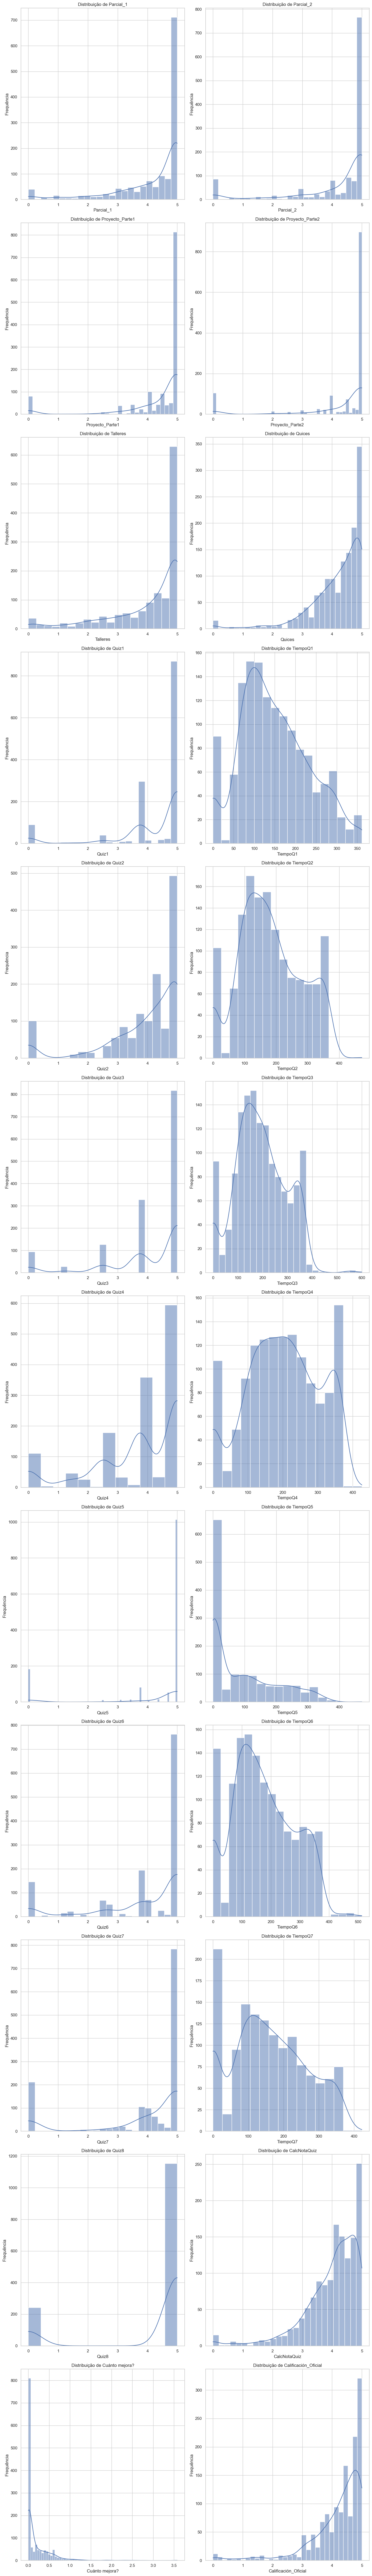

In [14]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = numerical_columns.drop('Grupo', errors='ignore')

# Para plots no Colab
%matplotlib inline
sns.set(style="whitegrid")

# Distribuições Numéricas: Histogramas e KDE
fig, axes = plt.subplots(nrows=(len(numerical_columns) + 1) // 2, ncols=2, figsize=(14, len(numerical_columns) * 4))
axes = axes.flatten()
for i, col in enumerate(numerical_columns):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f'Distribuição de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequência')
plt.tight_layout()
plt.show()


### 4.1.2. Análise Univariada
Análise univariada das variáveis numéricas, incluindo medidas de tendência central e dispersão.

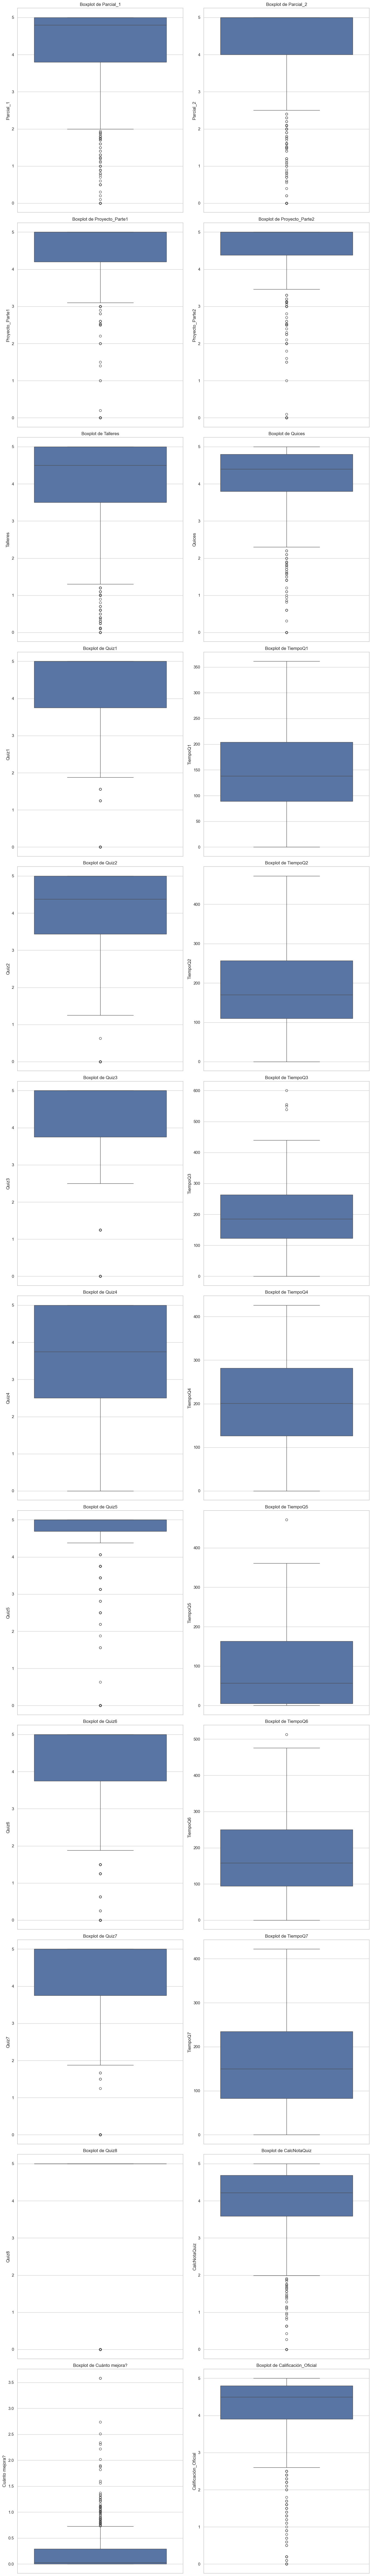

In [15]:
relevant_variables = ['Parcial_1', 'Parcial_2', 'Proyecto_Parte1', 'Proyecto_Parte2', 'Talleres', 'Quices', 'Calificación_Oficial']

# Boxplots para Numéricas (detecção de outliers)
fig, axes = plt.subplots(nrows=(len(numerical_columns) + 1) // 2, ncols=2, figsize=(14, len(numerical_columns) * 4))
axes = axes.flatten()
for i, col in enumerate(numerical_columns):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

### 4.1.3. Análises de Correlações

##### Heatmaps
Heatmaps ajudam a identificar visualmente as relações entre variáveis numéricas, destacando quais variáveis têm correlações fortes ou fracas entre si, considerando sua matriz. Os valores variam de -1 a 1:

1: Correlação linear positiva perfeita (quando uma variável aumenta, a outra também aumenta).
0: Nenhuma correlação linear.
-1: Correlação linear negativa perfeita (quando uma variável aumenta, a outra diminui).

**Mapa de Calor da Correlação entre todas as Variáveis Numéricas**

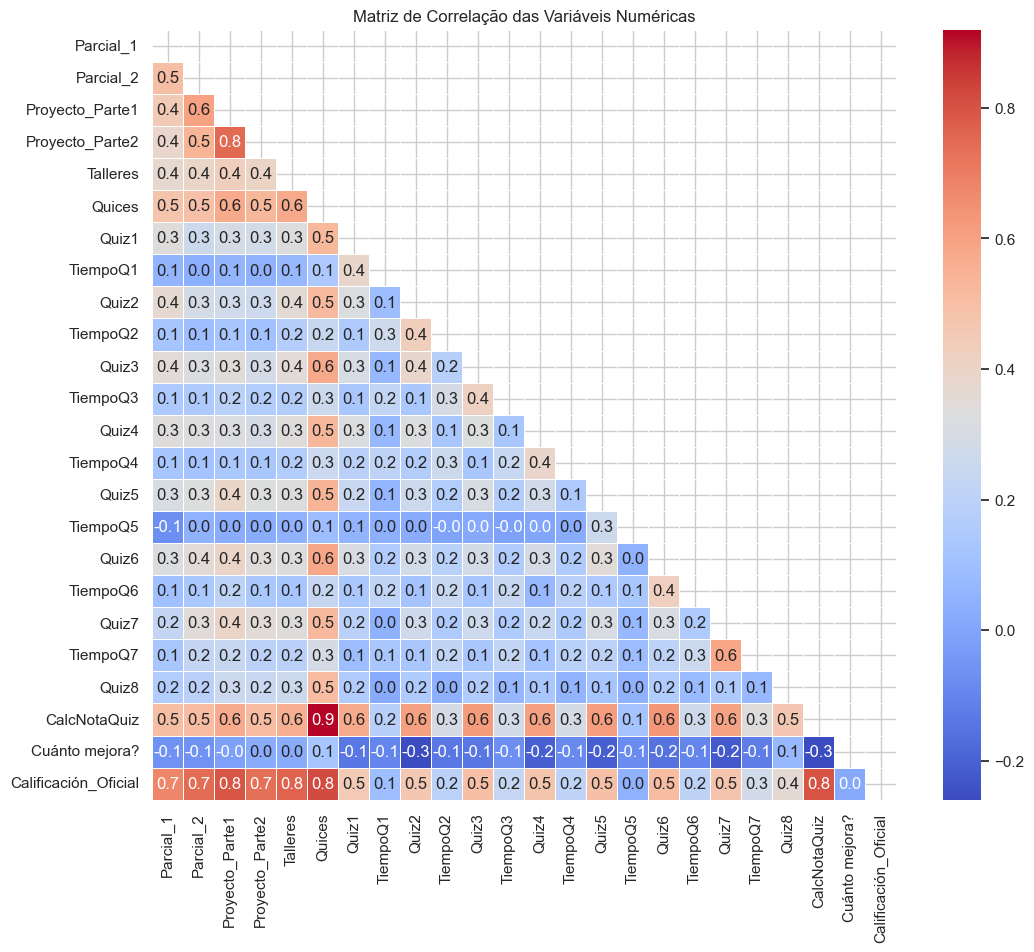

In [16]:
# Matriz de Correlação com Heatmap (para variáveis numéricas)
corr_matrix = df[numerical_columns].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5, mask=mask)
plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.show()

**Mapa de Calor da Correlação entre as Notas**

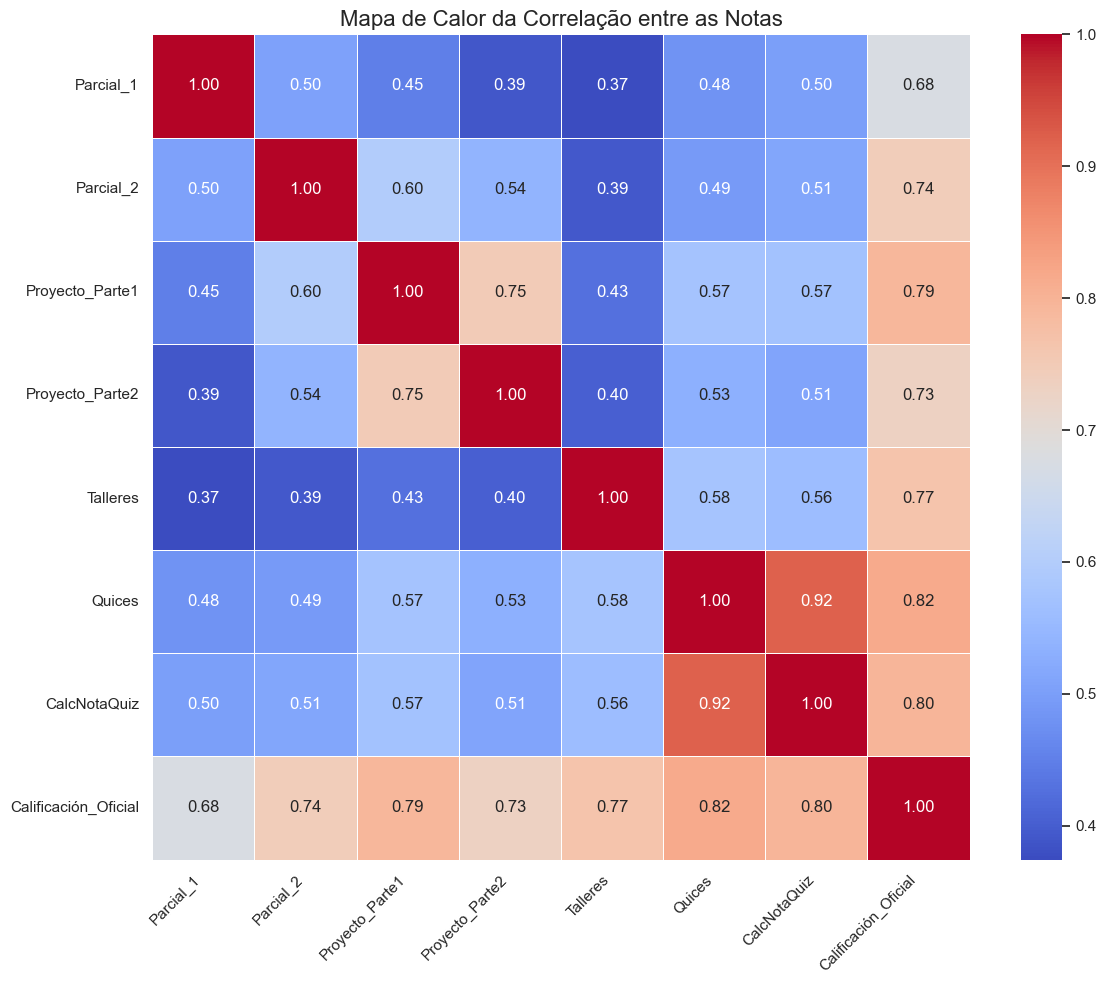

In [17]:
plt.figure(figsize=(12, 10))
grade_cols = [
    'Parcial_1', 'Parcial_2', 'Proyecto_Parte1', 'Proyecto_Parte2',
    'Talleres', 'Quices', 'CalcNotaQuiz', 'Calificación_Oficial'
]
existing_grade_cols = [col for col in grade_cols if col in df.columns]
correlation_matrix = df[existing_grade_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor da Correlação entre as Notas', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##### Gráfico de Barra
Gráficos de barras ajudam a comparar visualmente uma métrica (como uma contagem ou média) entre diferentes grupos ou categorias. Eles são ideais para destacar as diferenças entre esses grupos, permitindo identificar rapidamente quais categorias possuem os valores mais altos, os mais baixos ou se existem tendências claras.

**Gráfico de Barras de Proporção por Período**

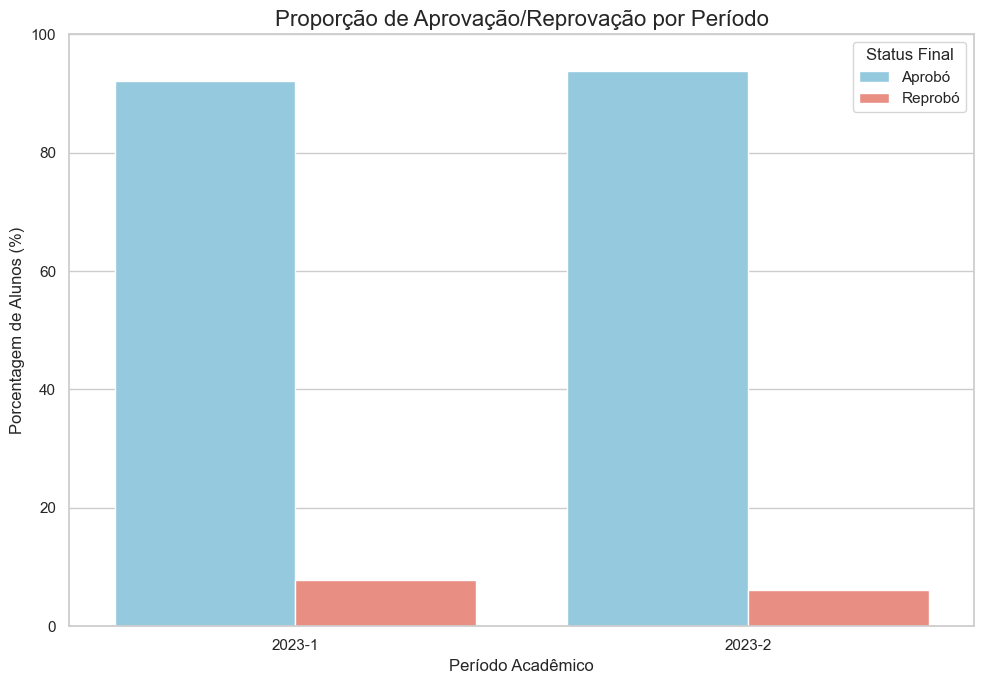

In [18]:
df['Periodo'] = df['Periodo'].astype(str)
periodo_summary = df.groupby('Periodo')['Aprobo'].value_counts(normalize=True).mul(100).rename('Proportion').reset_index()
plt.figure(figsize=(10, 7))
sns.barplot(x='Periodo', y='Proportion', hue='Aprobo', data=periodo_summary, palette={'Aprobó': 'skyblue', 'Reprobó': 'salmon'})
plt.title('Proporção de Aprovação/Reprovação por Período', fontsize=16)
plt.xlabel('Período Acadêmico', fontsize=12)
plt.ylabel('Porcentagem de Alunos (%)', fontsize=12)
plt.legend(title='Status Final')
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('proporcao_por_periodo.png')
plt.show()

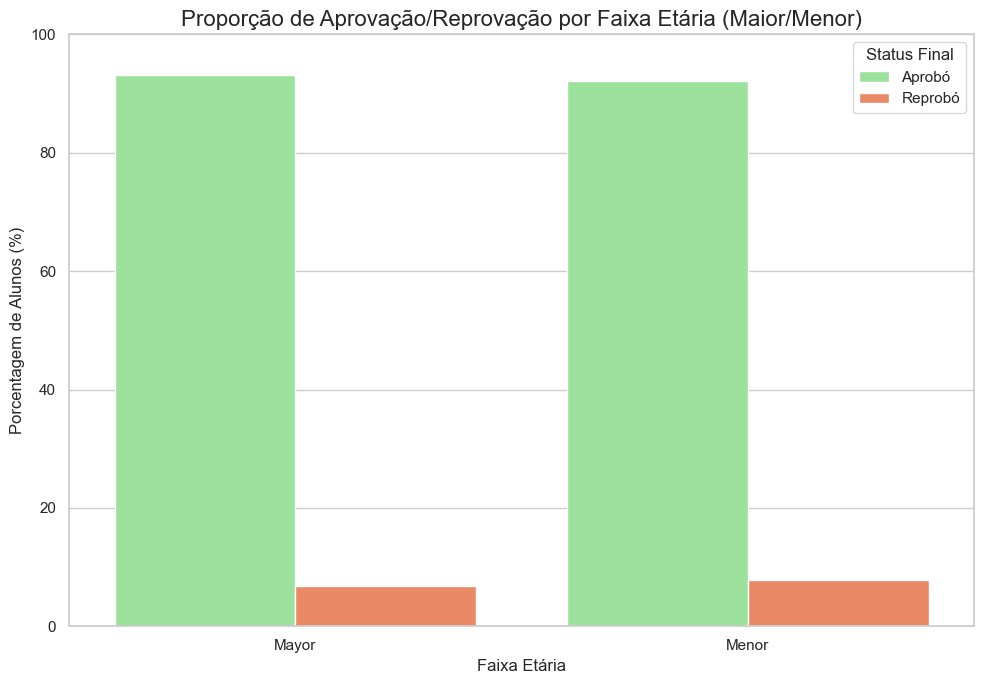

In [19]:

df['Edad'] = df['Edad'].str.strip().str.title()

df_idade_filtrado = df[df['Edad'].isin(['Mayor', 'Menor'])]

if not df_idade_filtrado.empty:
    plt.figure(figsize=(10, 7))
    
    idade_summary = df_idade_filtrado.groupby('Edad')['Aprobo'].value_counts(normalize=True).mul(100).rename('Proportion').reset_index()
    
    sns.barplot(x='Edad', y='Proportion', hue='Aprobo', data=idade_summary, palette={'Aprobó': 'lightgreen', 'Reprobó': 'coral'})
    
    plt.title('Proporção de Aprovação/Reprovação por Faixa Etária (Maior/Menor)', fontsize=16)
    plt.xlabel('Faixa Etária', fontsize=12)
    plt.ylabel('Porcentagem de Alunos (%)', fontsize=12)
    plt.legend(title='Status Final')
    plt.ylim(0, 100)
    plt.savefig('proporcao_por_idade.png')
    plt.tight_layout()
    plt.show()


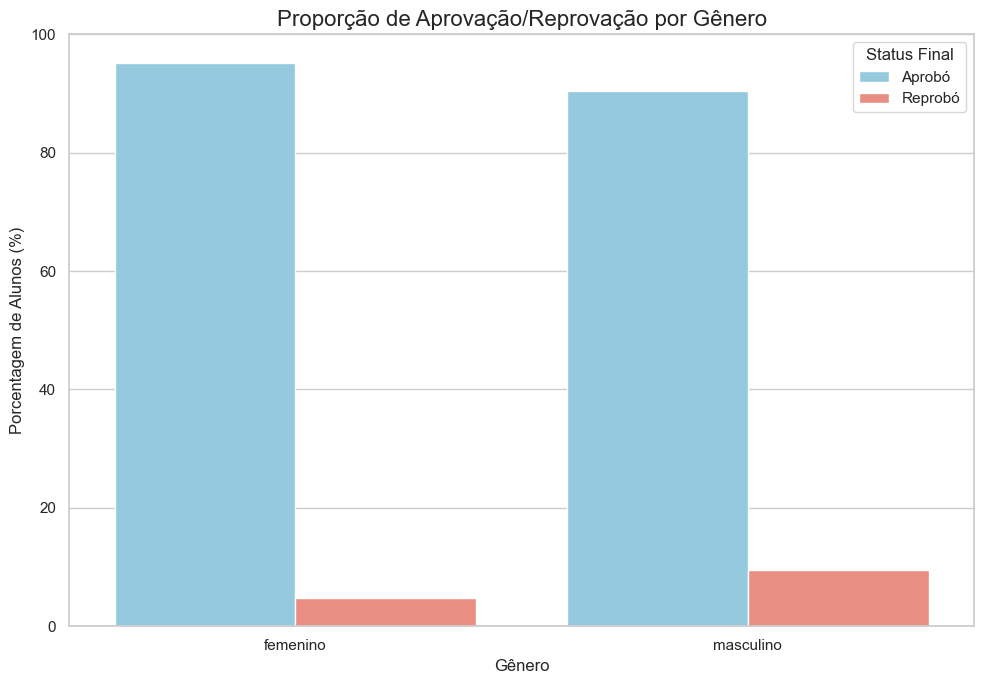

Genero   Aprobo  Proportion
0   femenino   Aprobó       95.17
1   femenino  Reprobó        4.83
2  masculino   Aprobó       90.51
3  masculino  Reprobó        9.49

In [20]:
if 'Genero' in df.columns:
    plt.figure(figsize=(10, 7))
    genero_df = df[df['Genero'].isin(['masculino', 'femenino'])]
    genero_summary = genero_df.groupby('Genero')['Aprobo'].value_counts(normalize=True).mul(100).rename('Proportion').reset_index()
    sns.barplot(x='Genero', y='Proportion', hue='Aprobo', data=genero_summary, palette={'Aprobó': 'skyblue', 'Reprobó': 'salmon'})
    plt.title('Proporção de Aprovação/Reprovação por Gênero', fontsize=16)
    plt.xlabel('Gênero', fontsize=12)
    plt.ylabel('Porcentagem de Alunos (%)', fontsize=12)
    plt.legend(title='Status Final')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.savefig('proporcao_por_genero.png')
    plt.show()
genero_summary.head()

## 4.2. Análise Estatística das Variáveis Categóricas

Apresentando número de valores não nulos, número de categorias, categorias e suas respectivas frequências.

In [21]:
# Estatísticas descritivas para variáveis categóricas
df[categorical_columns].describe().transpose()

count unique       top  freq
Periodo  1395      2    2023-1   774
Edad     1395      2     Mayor  1025
Genero   1395      3  femenino   704
STEM     1395      2        NO  1172
Aprobo   1395      2    Aprobó  1296

In [22]:
df.describe()

Grupo  Parcial_1  Parcial_2  Proyecto_Parte1  Proyecto_Parte2  \
count 1395.00    1395.00    1395.00          1395.00          1395.00   
mean    31.84       4.18       4.17             4.36             4.32   
std     17.97       1.24       1.41             1.24             1.38   
min      1.00       0.00       0.00             0.00             0.00   
25%     17.00       3.80       4.00             4.20             4.38   
50%     32.00       4.80       5.00             5.00             5.00   
75%     47.00       5.00       5.00             5.00             5.00   
max     62.00       5.00       5.00             5.00             5.00   

       Talleres  Quices   Quiz1  TiempoQ1   Quiz2  ...   Quiz5  TiempoQ5  \
count   1395.00 1395.00 1395.00   1395.00 1395.00  ... 1395.00   1395.00   
mean       4.02    4.17    4.25    149.03    3.92  ...    4.18     92.34   
std        1.30    0.92    1.33     83.09    1.37  ...    1.69    105.06   
min        0.00    0.00    0.00      0.00    0.00  ...    0.00      0.00   
25%        3.50    3.80    3.75     89.00    3.44  ...    4.69      5.00   
50%        4.50    4.40    5.00    138.00    4.38  ...    5.00     57.00   
75%        5.00    4.80    5.00    204.00    5.00  ...    5.00    163.00   
max        5.00    5.00    5.00    361.00    5.00  ...    5.00    471.00   

        Quiz6  TiempoQ6   Quiz7  TiempoQ7   Quiz8  CalcNotaQuiz  \
count 1395.00   1395.00 1395.00   1395.00 1395.00       1395.00   
mean     3.88    171.33    3.89    158.17    4.13          4.00   
std      1.63    105.21    1.76    105.62    1.89          0.92   
min      0.00      0.00    0.00      0.00    0.00          0.00   
25%      3.75     94.00    3.75     83.00    5.00          3.59   
50%      5.00    158.00    5.00    150.00    5.00          4.22   
75%      5.00    250.00    5.00    235.00    5.00          4.69   
max      5.00    513.00    5.00    422.00    5.00          5.00   

       Cuánto mejora?  Calificación_Oficial  
count         1395.00               1395.00  
mean             0.19                  4.19  
std              0.34                  0.93  
min              0.00                  0.00  
25%              0.00                  3.90  
50%              0.03                  4.50  
75%              0.29                  4.80  
max              3.58                  5.00  

[8 rows x 25 columns]

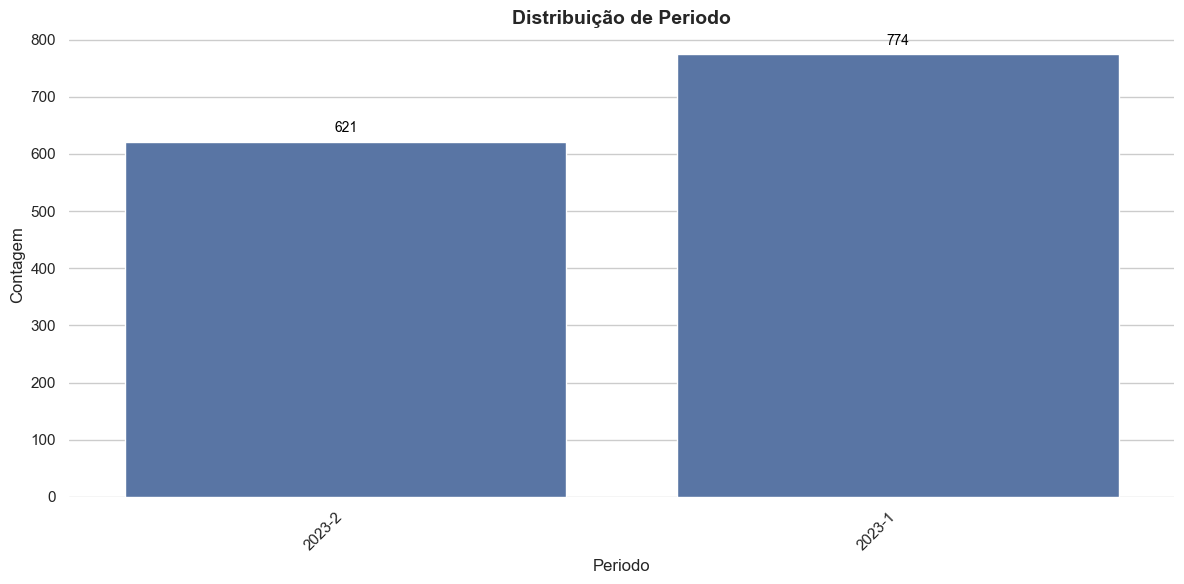

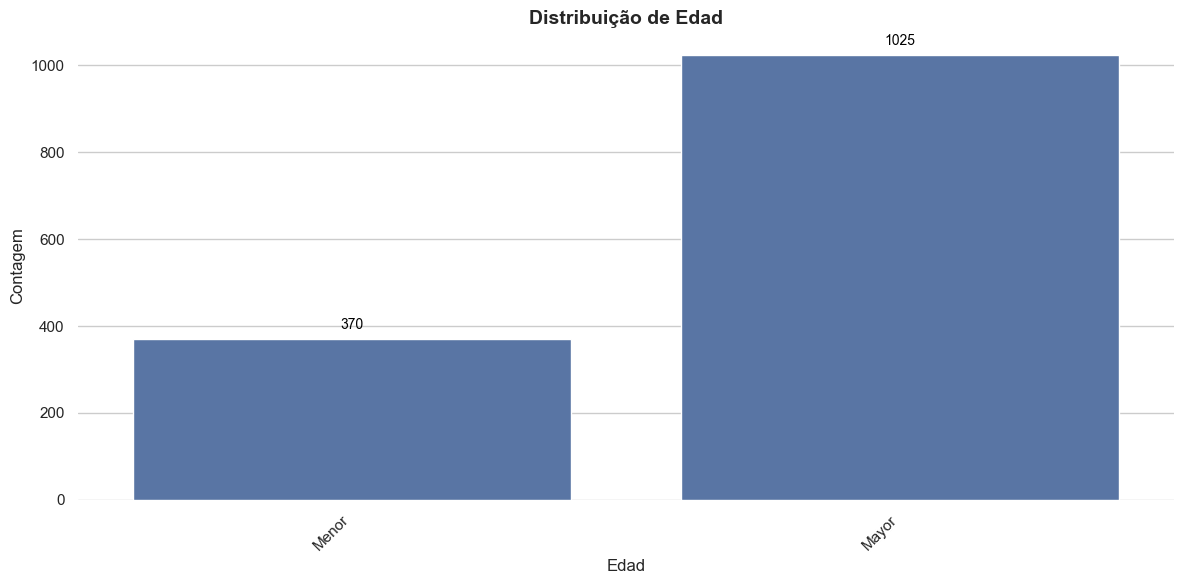

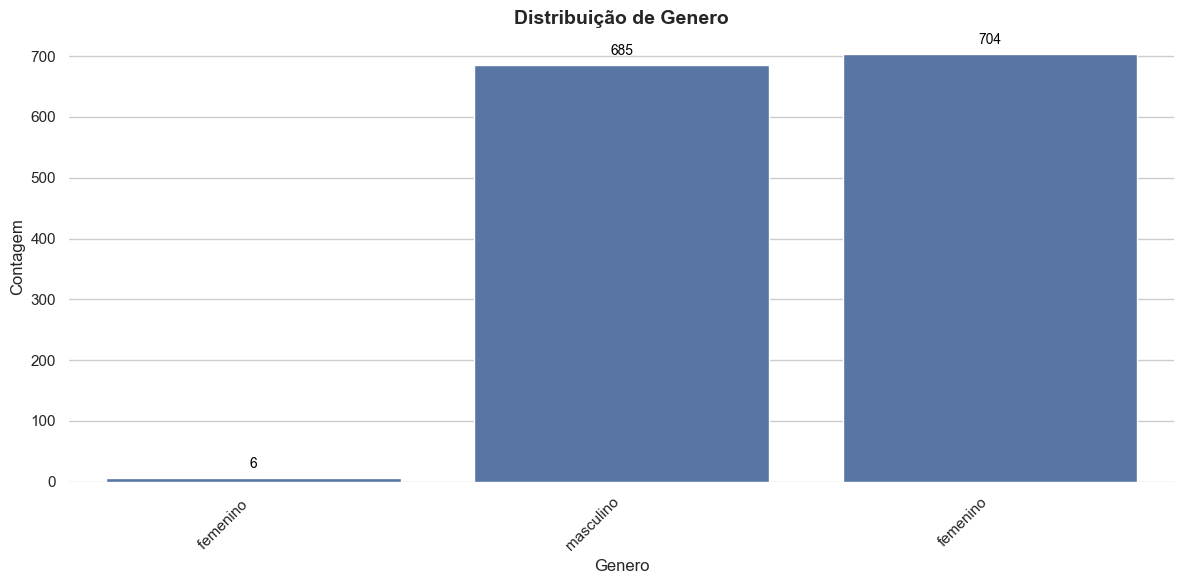

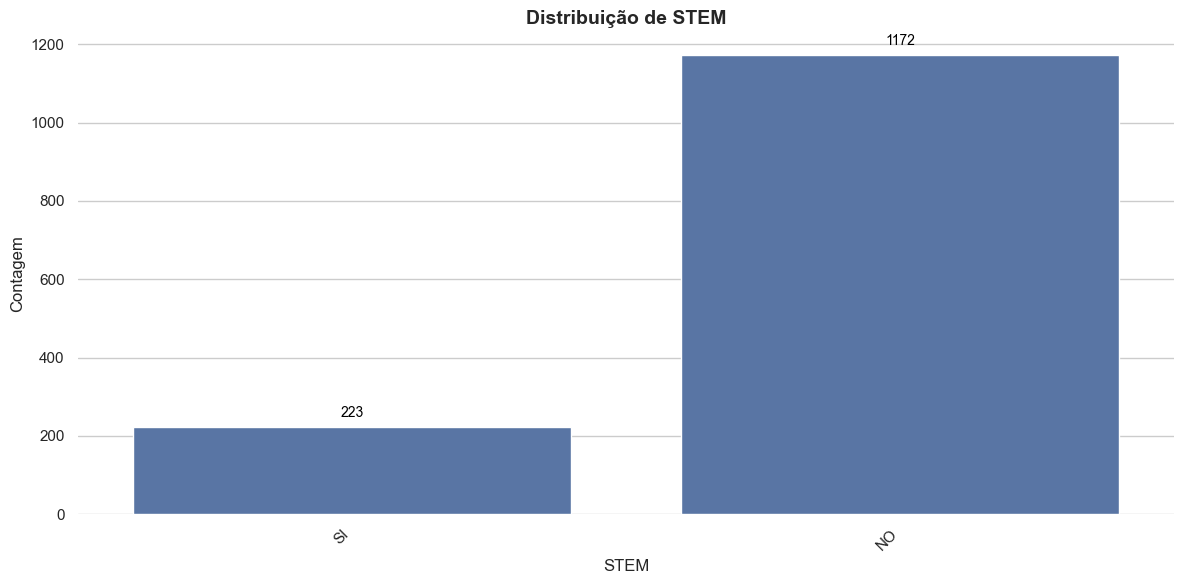

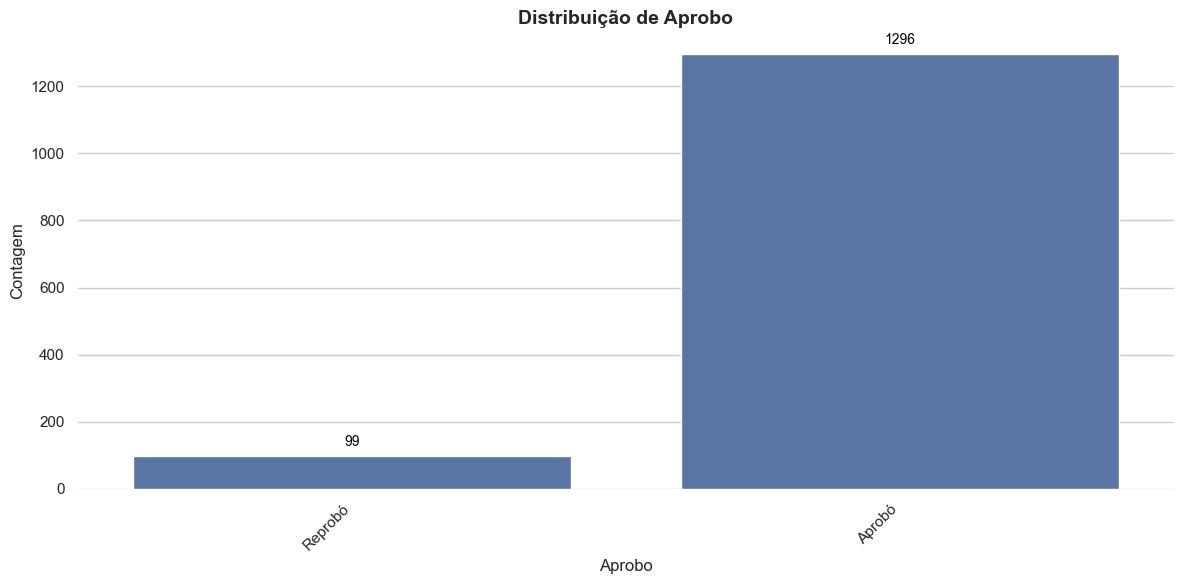

In [23]:

sns.set_theme(style="whitegrid")

for col in categorical_columns:
    if df[col].nunique() < 50:  # Limitar para não poluir
        order = df[col].value_counts().index[::-1]  # Ordenar de baixo pra cima

        plt.figure(figsize=(12, 6))
        ax = sns.countplot(
            x=df[col],
            order=order,
        )

        # Títulos e labels
        ax.set_title(f"Distribuição de {col}", fontsize=14, weight="bold")
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel("Contagem", fontsize=12)

        # Mostrar valores nas barras
        for p in ax.patches:
            ax.annotate(
                f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points'
            )

        # Rotacionar os rótulos se forem muitos
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

        sns.despine(left=True, bottom=True)
        plt.tight_layout()
        plt.show()


# 5. Preparação para o Treinamento dos Modelos Preditivos

## 5.1. Feature Engineering 

Remoção de variáveis que se correlacionam diretamente com a variável alvo de aprovação final

In [24]:
# Remover o CalcNotaQuiz - Nota calculada dos quizzes (média aritmética das notas dos quizzes)
df.drop(columns=['CalcNotaQuiz'], errors='ignore', inplace=True)
df.drop(columns=['CalcNotaQuiz_norm'], errors='ignore', inplace=True)

# Remover o Cuánto mejora? - Nota calculada dos quizzes (média aritmética das notas dos quizzes)
df.drop(columns=['Cuánto mejora?'], errors='ignore', inplace=True)

# Remover o MejoraNotaQuices - Indica se houve melhora nas notas dos quizzes
df.drop(columns=['MejoraNotaQuices'], errors='ignore', inplace=True)
df.drop(columns=['MejoraNotaQuices_True'], errors='ignore', inplace=True)

# Remover o Calificación_Oficial - Nota final defiinitiva do curso
df.drop(columns=['Calificación_Oficial'], errors='ignore', inplace=True)
df.drop(columns=['Calificación_Oficial_norm'], errors='ignore', inplace=True)

# Remover a coluna Quices - Nota total dos quizzes (possui forte correlação com a nota final)
df.drop(columns=['Quices'], errors='ignore', inplace=True)


# Remove a coluna Periodo para o modelo poder ser usado em qualquer período
df.drop(columns=['Periodo'], errors='ignore', inplace=True)

Realilza a transfomação das variáveis categóricas para inteiros numéricos utilizando o OneHotEnconder

In [25]:
# Verifica valores únicos nas colunas categóricas (opcional, para depuração)
categorical_columns = ['Edad', 'Genero', 'STEM', 'Aprobo'] 


# Aplica one-hot encoding
# O parâmetro 'drop_first=True' evita multicolinearidade removendo uma categoria por coluna (opcional, mas recomendado para modelos lineares)
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True, dtype=int)

# Exiba o resultado para verificar
print(df.head().to_markdown())  # Mostra as primeiras linhas do novo DataFrame
print("Shape: ", df.shape)   # Verifica o novo shape (colunas aumentam com as dummies)
print(df.dtypes)  # Confirma que as novas colunas são int (0/1)

|    |   Grupo |   Parcial_1 |   Parcial_2 |   Proyecto_Parte1 |   Proyecto_Parte2 |   Talleres |   Quiz1 |   TiempoQ1 |   Quiz2 |   TiempoQ2 |   Quiz3 |   TiempoQ3 |   Quiz4 |   TiempoQ4 |   Quiz5 |   TiempoQ5 |   Quiz6 |   TiempoQ6 |   Quiz7 |   TiempoQ7 |   Quiz8 |   Edad_Menor |   Genero_femenino  |   Genero_masculino |   STEM_SI |   Aprobo_Reprobó |
|---:|--------:|------------:|------------:|------------------:|------------------:|-----------:|--------:|-----------:|--------:|-----------:|--------:|-----------:|--------:|-----------:|--------:|-----------:|--------:|-----------:|--------:|-----------:|--------:|-------------:|-------------------:|-------------------:|----------:|-----------------:|
|  0 |      11 |        4.2  |         0   |              0    |              0    |       4.5  |    5    |        195 |    0    |          0 |    0    |          0 |     2.5 |        269 |       0 |          0 |    0    |          0 |       0 |          0 |       5 |            0 |   

## 5.2. Divisão dos dados em semanas

Divisão de diferentes datasets para análise de desempenho dos modelos em cada um dos períodos. 

In [26]:
# Aqui criamos os dataframes para cada semana, removendo as colunas que não seriam conhecidas até aquele ponto do semestre
# SEMANA 4
df_week4 = df.copy()
df_week4 = df_week4.drop(columns = ['Parcial_1', 'Parcial_2', 'Proyecto_Parte1', 'Proyecto_Parte2',
       'Talleres', 'Quiz2', 'TiempoQ2', 'Quiz3',
       'TiempoQ3', 'Quiz4', 'TiempoQ4', 'Quiz5', 'TiempoQ5', 'Quiz6',
       'TiempoQ6', 'Quiz7', 'TiempoQ7', 'Quiz8'], errors='ignore')
# SEMANA 8
df_week8 = df.copy()
df_week8 = df_week8.drop(columns=[ 'Parcial_2', 'Proyecto_Parte1', 'Proyecto_Parte2',
       'Talleres', 'Quiz4', 'TiempoQ4', 'Quiz5', 'TiempoQ5', 'Quiz6',
       'TiempoQ6', 'Quiz7', 'TiempoQ7', 'Quiz8'], errors='ignore')
# SEMANA 12
df_week12 = df.copy()
df_week12 = df_week12.drop(columns=['Proyecto_Parte1', 'Parcial_2', 'Proyecto_Parte2',
       'Talleres', 'Quiz6', 'TiempoQ6', 'Quiz7', 'TiempoQ7', 'Quiz8'], errors='ignore')
# SEMANA 15
df_week15 = df.copy()
df_week15 = df_week15.drop(columns=['Proyecto_Parte2','Parcial_2',
       'Talleres', 'Quiz8'], errors='ignore')


Função para dividir os dados em treino, teste e validação

In [27]:
# Faz a divisão dos dados utilizados no treino (X) e o que está sendo previsto (y)
X_week4 = df_week4.drop(columns=['Aprobo_Reprobó'], errors='ignore')
y_week4 = df_week4['Aprobo_Reprobó']

# Divide os dados em treino (70%), validação (15%) e teste (15%)
X_train_w4, X_temp_w4, y_train_w4, y_temp_w4 = train_test_split(X_week4, y_week4, test_size=0.3, random_state=42)
X_val_w4, X_test_w4, y_val_w4, y_test_w4 = train_test_split(X_temp_w4, y_temp_w4, test_size=0.5, random_state=42, stratify=y_temp_w4)


# Semana 8
X_week8 = df_week8.drop(columns=['Aprobo_Reprobó'], errors='ignore')
y_week8 = df_week8['Aprobo_Reprobó']

X_train_w8, X_temp_w8, y_train_w8, y_temp_w8 = train_test_split(X_week8, y_week8, test_size=0.3, random_state=42)
X_val_w8, X_test_w8, y_val_w8, y_test_w8 = train_test_split(X_temp_w8, y_temp_w8, test_size=0.5, random_state=42, stratify=y_temp_w8)


# Semana 12
X_week12 = df_week12.drop(columns=['Aprobo_Reprobó'], errors='ignore')
y_week12 = df_week12['Aprobo_Reprobó']

X_train_w12, X_temp_w12, y_train_w12, y_temp_w12 = train_test_split(X_week12, y_week12, test_size=0.3, random_state=42)
X_val_w12, X_test_w12, y_val_w12, y_test_w12 = train_test_split(X_temp_w12, y_temp_w12, test_size=0.5, random_state=42, stratify=y_temp_w12)


# Semana 15
X_week15 = df_week15.drop(columns=['Aprobo_Reprobó'], errors='ignore')
y_week15 = df_week15['Aprobo_Reprobó']

X_train_w15, X_temp_w15, y_train_w15, y_temp_w15 = train_test_split(X_week15, y_week15, test_size=0.3, random_state=42)
X_val_w15, X_test_w15, y_val_w15, y_test_w15 = train_test_split(X_temp_w15, y_temp_w15, test_size=0.5, random_state=42, stratify=y_temp_w15)

# 6. Escalonamento e Normalização dos Dados

Normalização dos dados utilizando MinMaxScaler para os dados de treino e teste separadamente

In [28]:
from sklearn.preprocessing import MinMaxScaler

# Seleciona colunas numéricas (sem a target)
num_cols_w4 = X_train_w4.select_dtypes(include=np.number).columns

# Cria o scaler e ajusta só com os dados de treino
scaler_w4 = MinMaxScaler()
scaler_w4.fit(X_train_w4[num_cols_w4])

# Transforma treino, validação e teste usando o mesmo scaler
X_train_w4[num_cols_w4] = scaler_w4.transform(X_train_w4[num_cols_w4])
X_val_w4[num_cols_w4]   = scaler_w4.transform(X_val_w4[num_cols_w4])
X_test_w4[num_cols_w4]  = scaler_w4.transform(X_test_w4[num_cols_w4])

# Semana 8
num_cols_w8 = X_train_w8.select_dtypes(include=np.number).columns
scaler_w8 = MinMaxScaler().fit(X_train_w8[num_cols_w8])
X_train_w8[num_cols_w8] = scaler_w8.transform(X_train_w8[num_cols_w8])
X_val_w8[num_cols_w8]   = scaler_w8.transform(X_val_w8[num_cols_w8])
X_test_w8[num_cols_w8]  = scaler_w8.transform(X_test_w8[num_cols_w8])

# Semana 12
num_cols_w12 = X_train_w12.select_dtypes(include=np.number).columns
scaler_w12 = MinMaxScaler().fit(X_train_w12[num_cols_w12])
X_train_w12[num_cols_w12] = scaler_w12.transform(X_train_w12[num_cols_w12])
X_val_w12[num_cols_w12]   = scaler_w12.transform(X_val_w12[num_cols_w12])
X_test_w12[num_cols_w12]  = scaler_w12.transform(X_test_w12[num_cols_w12])

# Semana 15
num_cols_w15 = X_train_w15.select_dtypes(include=np.number).columns
scaler_w15 = MinMaxScaler().fit(X_train_w15[num_cols_w15])
X_train_w15[num_cols_w15] = scaler_w15.transform(X_train_w15[num_cols_w15])
X_val_w15[num_cols_w15]   = scaler_w15.transform(X_val_w15[num_cols_w15])
X_test_w15[num_cols_w15]  = scaler_w15.transform(X_test_w15[num_cols_w15])


In [29]:
X_val_w12.head()

Grupo  Parcial_1  Quiz1  TiempoQ1  Quiz2  TiempoQ2  Quiz3  TiempoQ3  \
997    0.57       0.70   1.00      0.55   1.00      0.73   0.75      0.10   
793    0.77       0.06   0.75      0.43   0.31      0.50   0.00      0.00   
1128   0.82       1.00   1.00      0.77   1.00      0.76   1.00      0.56   
67     0.28       0.43   0.75      0.14   0.88      0.21   0.75      0.13   
679    0.46       1.00   1.00      0.32   1.00      0.23   1.00      0.20   

      Quiz4  TiempoQ4  Quiz5  TiempoQ5  Edad_Menor  Genero_femenino   \
997    0.00      0.00   0.00      0.00        0.00              0.00   
793    0.31      0.70   0.88      0.59        0.00              0.00   
1128   1.00      0.64   1.00      0.01        0.00              0.00   
67     0.06      0.14   1.00      0.42        1.00              0.00   
679    1.00      0.33   0.00      0.00        0.00              0.00   

      Genero_masculino  STEM_SI  
997               0.00     0.00  
793               0.00     0.00  
1128              0.00     0.00  
67                0.00     1.00  
679               1.00     0.00

Aplicar o SMOTE

In [30]:
smote = SMOTE(random_state=42)
X_train_w4_smote, y_train_w4_smote = smote.fit_resample(X_train_w4, y_train_w4)
X_train_w8_smote, y_train_w8_smote = smote.fit_resample(X_train_w8, y_train_w8)
X_train_w12_smote, y_train_w12_smote = smote.fit_resample(X_train_w12, y_train_w12)
X_train_w15_smote, y_train_w15_smote = smote.fit_resample(X_train_w15, y_train_w15)

# Preaparação do GridSearch

In [31]:
def plot_grid_and_dist(grid_search, x_param="param_n_estimators", 
                       y_param="param_learning_rate", depth_param="param_estimator__max_depth"):
    """
    Plota heatmaps e gráficos de distribuição para todos os valores de max_depth
    a partir de um GridSearchCV ajustado.
    """
    results = pd.DataFrame(grid_search.cv_results_)
    depth_values = sorted(results[depth_param].unique())
    
    for depth in depth_values:
        subset = results[results[depth_param] == depth]
        pivot = subset.pivot(index=y_param, columns=x_param, values="mean_test_score")
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
        plt.title(f"Acurácia Média CV (max_depth={depth})")
        plt.ylabel(y_param)
        plt.xlabel(x_param)
        plt.show()
        
        plt.figure(figsize=(8, 6))
        sns.violinplot(x=y_param, y="mean_test_score", data=subset)
        plt.title(f"Distribuição das acurácias CV por {y_param} (max_depth={depth})")
        plt.ylabel("Acurácia Média CV")
        plt.xlabel(y_param)
        plt.show()


In [32]:
def hyperparameters_tuning(estimator, param_grid, scoring, cv, n_jobs, verbose, show_plots=False): 
  best_estimators = {}
  
  weeks = {
      'week4': (X_train_w4_smote, y_train_w4_smote),
      'week8': (X_train_w8_smote, y_train_w8_smote),
      'week12': (X_train_w12_smote, y_train_w12_smote),
      'week15': (X_train_w15_smote, y_train_w15_smote)
  }
  
  
  for week_name, (X_train, y_train) in weeks.items():
    gridSearch = GridSearchCV(estimator=estimator,
                              param_grid=param_grid,
                              scoring=scoring,
                              cv=cv,
                              n_jobs=n_jobs,
                              verbose=verbose)

    gridSearch.fit(X_train, y_train)
    
    print("Resultados do GridSearch para", week_name)
    print("Melhores hiperparâmetros:", gridSearch.best_params_)
    print("Melhor score de validação:", gridSearch.best_score_)
    best_estimators[week_name] = gridSearch.best_estimator_
    
    if show_plots:
      # Plot grid and distribution for this week
      plot_grid_and_dist(gridSearch, x_param="param_n_estimators", 
                          y_param="param_learning_rate", depth_param="param_estimator__max_depth")
      
  return best_estimators

 # 7. Regressão Logistica 

Diferentemente da regressão linear tradicional, a regressão logística utiliza a função sigmoide para transformar qualquer combinação de variáveis de entrada em uma probabilidade entre 0 e 1, tornando-a ideal para predições de classificação. Uma das principais vantagens da regressão logística neste contexto educacional é sua interpretabilidade: os coeficientes do modelo podem ser facilmente compreendidos pelos educadores, permitindo identificar quais fatores mais influenciam o risco de reprovação. O modelo foi implementado para quatro momentos distintos do semestre (semanas 4, 8, 12 e 15), permitindo que a instituição identifique alunos em risco progressivamente ao longo do curso e implemente intervenções pedagógicas antes que seja tarde demais para a recuperação acadêmica.


Preparação do GridSearch

In [33]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': np.logspace(-4, 4, 20),
    'solver': ['lbfgs', 'newton-cg', 'liblinear'],
    'max_iter': [100, 1000, 2500, 5000],
    'class_weight': ['balanced']
}

model = LogisticRegression()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_estimators = hyperparameters_tuning(model, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


Resultados do GridSearch para week4
Melhores hiperparâmetros: {'C': np.float64(4.281332398719396), 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Melhor score de validação: 0.7078483806037736
Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Resultados do GridSearch para week8
Melhores hiperparâmetros: {'C': np.float64(1.623776739188721), 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Melhor score de validação: 0.8408705221821478
Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Resultados do GridSearch para week12
Melhores hiperparâmetros: {'C': np.float64(11.288378916846883), 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Melhor score de validação: 0.8511711745010018
Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Resultados do GridSearch para week15
Melhores hiperparâmetros: {'C': np.float64(0.0001), 'class_weight': 'balanced',

### 7.1 SEMANA 4

VALIDAÇÃO - SEMANA 4
              precision    recall  f1-score   support

           0       0.94      0.74      0.83       193
           1       0.12      0.44      0.19        16

    accuracy                           0.71       209
   macro avg       0.53      0.59      0.51       209
weighted avg       0.88      0.71      0.78       209


TESTE
              precision    recall  f1-score   support

           0       0.97      0.73      0.83       194
           1       0.17      0.69      0.28        16

    accuracy                           0.72       210
   macro avg       0.57      0.71      0.55       210
weighted avg       0.91      0.72      0.79       210


MATRIZ DE CONFUSÃO - TESTE - SEMANA 4
[[141  53]
 [  5  11]]
Erro treino = 0.237
Erro validação = 0.287
Erro teste = 0.276


<Figure size 800x600 with 0 Axes>

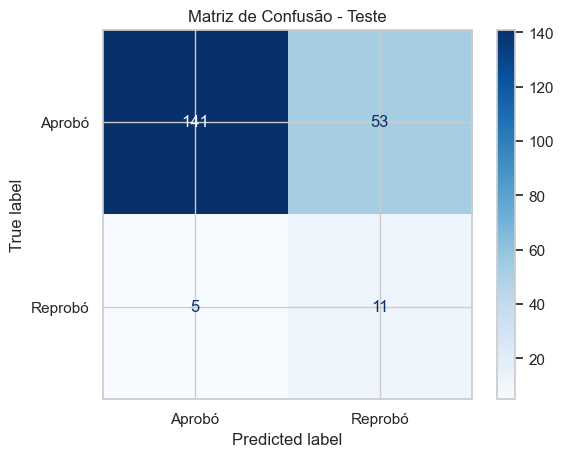

In [34]:
# Treinamento do modelo
best_lr_model_w4 = best_estimators['week4']

# Predição no conjunto de teste
y_train_w4_pred = best_lr_model_w4.predict(X_train_w4)
y_val_w4_pred = best_lr_model_w4.predict(X_val_w4)
y_test_w4_pred = best_lr_model_w4.predict(X_test_w4)

# Resultados
print("VALIDAÇÃO - SEMANA 4")
print(classification_report(y_val_w4, y_val_w4_pred))

print("\nTESTE")
print(classification_report(y_test_w4, y_test_w4_pred))

# Matriz de confusão para teste
print("\nMATRIZ DE CONFUSÃO - TESTE - SEMANA 4")
cm_test = confusion_matrix(y_test_w4, y_test_w4_pred)
print(cm_test)

print(f"Erro treino = {mean_squared_error(y_train_w4, y_train_w4_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val_w4, y_val_w4_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w4, y_test_w4_pred):.3f}")

plt.figure(figsize=(8, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Aprobó', 'Reprobó'])
disp_test.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Teste')
plt.show()

Na semana 4, com apenas dados demográficos e o primeiro quiz disponível, o modelo apresenta limitações esperadas na identificação de casos de reprovação, refletindo a natureza precoce da predição. A matriz mostra uma tendência do modelo em classificar mais casos como aprovação, o que é compreensível dado o volume limitado de informações acadêmicas disponíveis neste estágio inicial.

### 7.2 SEMANA 8

VALIDAÇÃO  - SEMANA 8
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       193
           1       0.28      0.81      0.42        16

    accuracy                           0.83       209
   macro avg       0.63      0.82      0.66       209
weighted avg       0.93      0.83      0.86       209


TESTE
              precision    recall  f1-score   support

           0       0.98      0.88      0.92       194
           1       0.33      0.75      0.46        16

    accuracy                           0.87       210
   macro avg       0.66      0.81      0.69       210
weighted avg       0.93      0.87      0.89       210


MATRIZ DE CONFUSÃO - TESTE - SEMANA 8
[[170  24]
 [  4  12]]
Erro treino = 0.141
Erro validação = 0.172
Erro teste = 0.133


<Figure size 800x600 with 0 Axes>

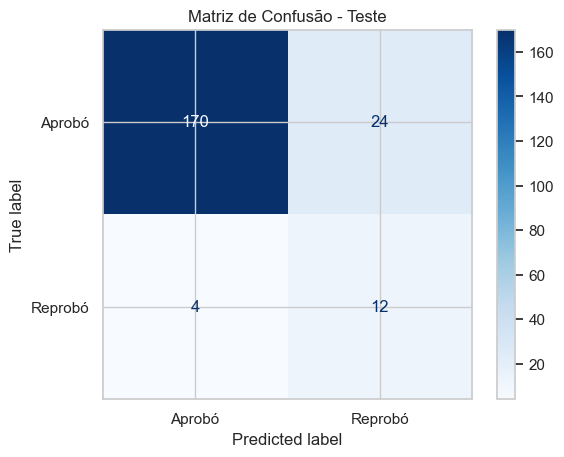

In [35]:
# Treinamento do modelo
best_lr_model_w8 = best_estimators['week8']

# Predições
y_train_w8_pred = best_lr_model_w8.predict(X_train_w8)
y_val_w8_pred = best_lr_model_w8.predict(X_val_w8)  
y_test_w8_pred = best_lr_model_w8.predict(X_test_w8)

# Resultados
print("VALIDAÇÃO  - SEMANA 8")
print(classification_report(y_val_w8, y_val_w8_pred))

print("\nTESTE")
print(classification_report(y_test_w8, y_test_w8_pred))

# Matriz de confusão para teste
print("\nMATRIZ DE CONFUSÃO - TESTE - SEMANA 8")
cm_test = confusion_matrix(y_test_w8, y_test_w8_pred)
print(cm_test)

print(f"Erro treino = {mean_squared_error(y_train_w8, y_train_w8_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val_w8, y_val_w8_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w8, y_test_w8_pred):.3f}")

plt.figure(figsize=(8, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Aprobó', 'Reprobó'])
disp_test.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Teste')
plt.show()

### 7.3 SEMANA 12

VALIDAÇÃO - SEMANA 12
              precision    recall  f1-score   support

           0       0.99      0.80      0.89       193
           1       0.28      0.94      0.43        16

    accuracy                           0.81       209
   macro avg       0.64      0.87      0.66       209
weighted avg       0.94      0.81      0.85       209


TESTE - SEMANA 12
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       194
           1       0.41      0.81      0.54        16

    accuracy                           0.90       210
   macro avg       0.69      0.86      0.74       210
weighted avg       0.94      0.90      0.91       210


MATRIZ DE CONFUSÃO - TESTE - SEMANA 12
[[175  19]
 [  3  13]]
Erro treino = 0.130
Erro validação = 0.187
Erro teste = 0.105


<Figure size 1200x600 with 0 Axes>

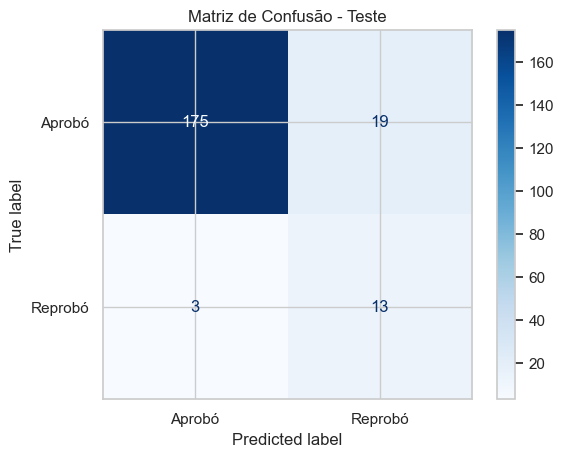

In [36]:
# Treinamento do modelo
best_lr_model_w12 = best_estimators['week12']

# Predições
y_train_w12_pred = best_lr_model_w12.predict(X_train_w12)
y_val_w12_pred = best_lr_model_w12.predict(X_val_w12)
y_test_w12_pred = best_lr_model_w12.predict(X_test_w12)

# Resultados
print("VALIDAÇÃO - SEMANA 12")
print(classification_report(y_val_w12, y_val_w12_pred))

print("\nTESTE - SEMANA 12")
print(classification_report(y_test_w12, y_test_w12_pred))

# Matriz de confusão para teste
print("\nMATRIZ DE CONFUSÃO - TESTE - SEMANA 12")
cm_test = confusion_matrix(y_test_w12, y_test_w12_pred)
print(cm_test)

print(f"Erro treino = {mean_squared_error(y_train_w12, y_train_w12_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val_w12, y_val_w12_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w12, y_test_w12_pred):.3f}")

plt.figure(figsize=(12, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Aprobó', 'Reprobó'])
disp_test.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Teste')
plt.show()

Conforme avançamos para as semanas 8 e 12, incorporando dados das parciais e quizzes adicionais, observa-se uma redução significativa nos falsos negativos, casos onde alunos reprovados foram incorretamente classificados como aprovados. Esta melhoria é crucial do ponto de vista pedagógico, pois reduz o risco de não identificar estudantes que realmente necessitam de intervenção acadêmica.

### 7.4 SEMANA 15

VALIDAÇÃO - SEMANA 15
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       193
           1       0.54      0.94      0.68        16

    accuracy                           0.93       209
   macro avg       0.77      0.94      0.82       209
weighted avg       0.96      0.93      0.94       209


TESTE - SEMANA 15
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       194
           1       0.72      0.81      0.76        16

    accuracy                           0.96       210
   macro avg       0.85      0.89      0.87       210
weighted avg       0.96      0.96      0.96       210


MATRIZ DE CONFUSÃO - TESTE - SEMANA 15
[[189   5]
 [  3  13]]
Erro treino = 0.029
Erro validação = 0.067
Erro teste = 0.038


<Figure size 800x600 with 0 Axes>

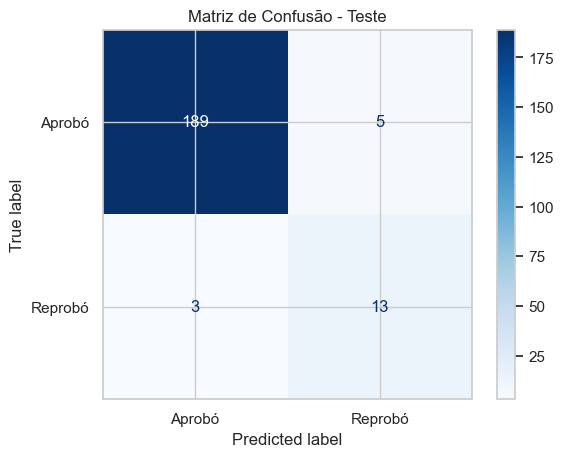

In [37]:
# Treinamento do modelo
best_lr_model_w15 = best_estimators['week15']

# Predições
y_train_w15_pred = best_lr_model_w15.predict(X_train_w15)
y_val_w15_pred = best_lr_model_w15.predict(X_val_w15)
y_test_w15_pred = best_lr_model_w15.predict(X_test_w15)

# Resultados
print("VALIDAÇÃO - SEMANA 15")
print(classification_report(y_val_w15, y_val_w15_pred))

print("\nTESTE - SEMANA 15")
print(classification_report(y_test_w15, y_test_w15_pred))

# Matriz de confusão para teste
print("\nMATRIZ DE CONFUSÃO - TESTE - SEMANA 15")
cm_test = confusion_matrix(y_test_w15, y_test_w15_pred)
print(cm_test)

print(f"Erro treino = {mean_squared_error(y_train_w15, y_train_w15_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val_w15, y_val_w15_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w15, y_test_w15_pred):.3f}")

plt.figure(figsize=(8, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Aprobó', 'Reprobó'])
disp_test.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Teste')
plt.show()

Na semana 15, com o dataset quase completo, a matriz de confusão demonstra a máxima capacidade preditiva do modelo, com melhor balanceamento entre sensibilidade e especificidade. O modelo mostra-se particularmente eficaz na identificação de aprovações verdadeiras, mantendo um bom número de falsos positivos, casos onde alunos aprovados foram classificados como em risco de reprovação.


# 8. K-Nearest Neighbors (KNN)

### 8.1. SEMANA 4

Treinamento do modelo e avaliação dos resultados

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Resultados do GridSearch para week4
Melhores hiperparâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
Melhor score de validação: 0.8971361971361972
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Resultados do GridSearch para week8
Melhores hiperparâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'uniform'}
Melhor score de validação: 0.9615036478672842
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Resultados do GridSearch para week12
Melhores hiperparâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'uniform'}
Melhor score de validação: 0.968651045923773
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Resultados do GridSearch para week15
Melhores hiperparâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'uniform'}
Melhor score de validação: 0.9917521872067327

<Figure size 800x600 with 0 Axes>

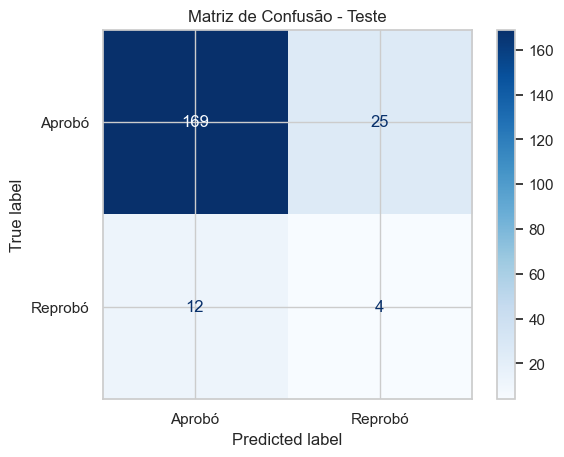


Relatório de classificação semana 4:
               precision    recall  f1-score   support

           0       0.93      0.87      0.90       194
           1       0.14      0.25      0.18        16

    accuracy                           0.82       210
   macro avg       0.54      0.56      0.54       210
weighted avg       0.87      0.82      0.85       210



In [38]:

pipeline = Pipeline([
    ('knn', KNeighborsClassifier())       # Modelo KNN
])

# Defininição dos hiperparâmetros para testar
param_grid = {
    'knn__n_neighbors': list(range(1, 21)),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

# GridSearchCV para buscar os melhores hiperparâmetros
grid_w4 = hyperparameters_tuning(pipeline, param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

# Avaliar no conjunto de teste
best_model_w4 = grid_w4['week4']
y_train_w4_pred = best_model_w4.predict(X_train_w4)
y_val_w4_pred = best_model_w4.predict(X_val_w4)
y_test_w4_pred = best_model_w4.predict(X_test_w4)

print("\nAcurácia no teste semana 4:", accuracy_score(y_test_w4, y_test_w4_pred))
print("\nMatriz de confusão semana 4:\n", confusion_matrix(y_test_w4, y_test_w4_pred))
cm_test = confusion_matrix(y_test_w4, y_test_w4_pred)

print(f"Erro treino = {mean_squared_error(y_train_w4, y_train_w4_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val_w4, y_val_w4_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w4, y_test_w4_pred):.3f}")

plt.figure(figsize=(8, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Aprobó', 'Reprobó'])
disp_test.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Teste')
plt.show()
print("\nRelatório de classificação semana 4:\n", classification_report(y_test_w4, y_test_w4_pred))

Análise de Feature Importance

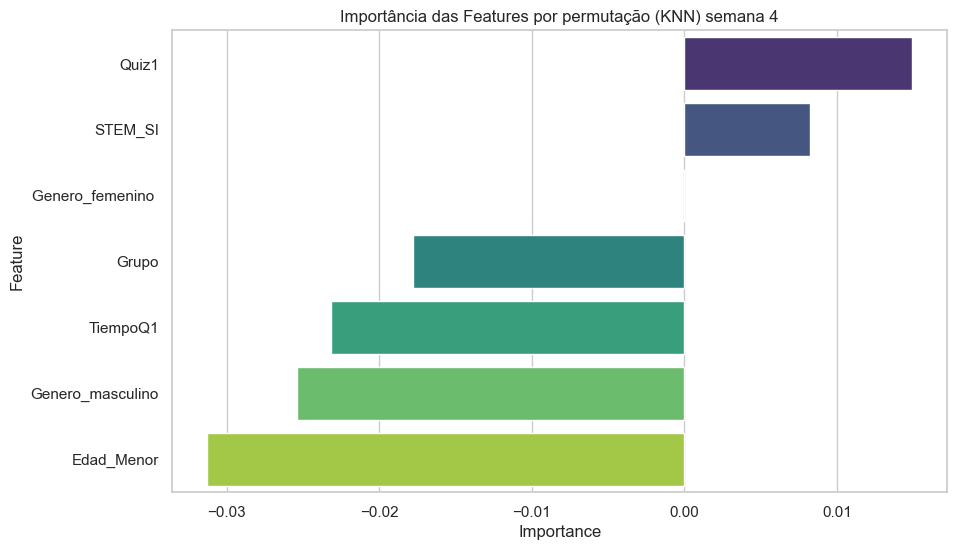

In [39]:
# Feature Importance
# Usa o melhor modelo do GridSearchCV
# Calcula importâncias por permutação
result = permutation_importance(best_model_w4, X_test_w4, y_test_w4, n_repeats=30, random_state=42)

# Organiza em DataFrame
importances = result.importances_mean
features = X_train_w4.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Importância das Features por permutação (KNN) semana 4")
plt.show()

### 8.2. SEMANA 8

Treinamento do modelo e avaliação dos resultados

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Resultados do GridSearch para week4
Melhores hiperparâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
Melhor score de validação: 0.8971361971361972
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Resultados do GridSearch para week8
Melhores hiperparâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'uniform'}
Melhor score de validação: 0.9615036478672842
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Resultados do GridSearch para week12
Melhores hiperparâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'uniform'}
Melhor score de validação: 0.968651045923773
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Resultados do GridSearch para week15
Melhores hiperparâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'uniform'}
Melhor score de validação: 0.9917521872067327

<Figure size 800x600 with 0 Axes>

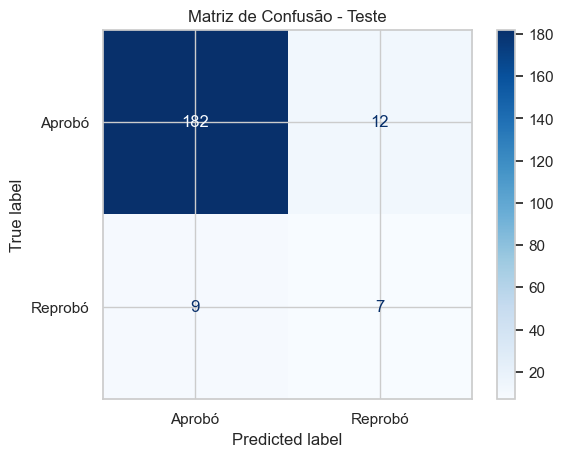


Relatório de classificação semana 8:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       194
           1       0.37      0.44      0.40        16

    accuracy                           0.90       210
   macro avg       0.66      0.69      0.67       210
weighted avg       0.91      0.90      0.90       210



In [40]:
# GridSearchCV para buscar os melhores hiperparâmetros
grid_w8 = hyperparameters_tuning(pipeline, param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

# Avaliar no conjunto de teste
best_model_s8 = grid_w8['week8']
y_train_w8_pred = best_model_s8.predict(X_train_w8)
y_val_w8_pred = best_model_s8.predict(X_val_w8)
y_test_w8_pred = best_model_s8.predict(X_test_w8)

print("\nAcurácia no teste semana 8:", accuracy_score(y_test_w8, y_test_w8_pred))
print("\nMatriz de confusão semana 8:\n", confusion_matrix(y_test_w8, y_test_w8_pred))
cm_test = confusion_matrix(y_test_w8, y_test_w8_pred)

print(f"Erro treino = {mean_squared_error(y_train_w8, y_train_w8_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val_w8, y_val_w8_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w8, y_test_w8_pred):.3f}")

plt.figure(figsize=(8, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Aprobó', 'Reprobó'])
disp_test.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Teste')
plt.show()
print("\nRelatório de classificação semana 8:\n", classification_report(y_test_w8, y_test_w8_pred))

Análise de Feature Importance

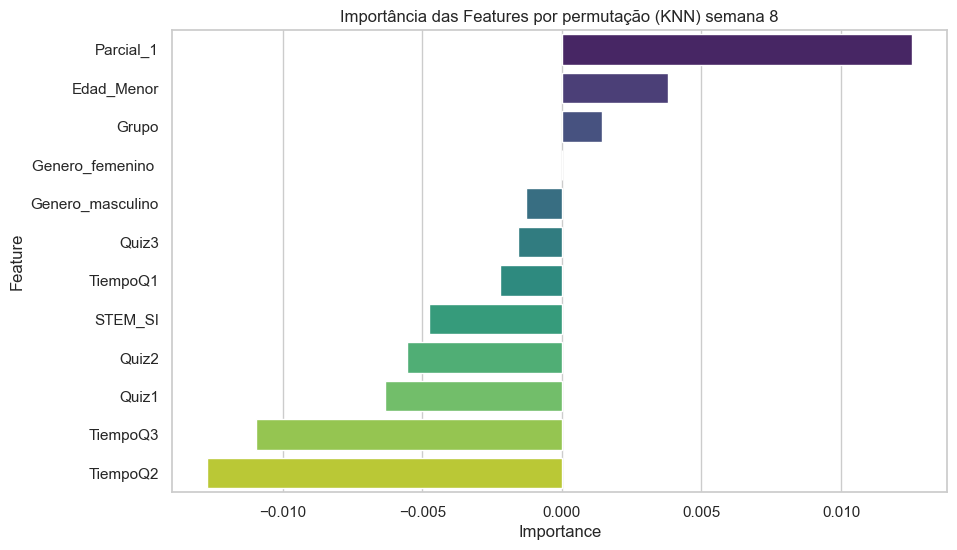

In [41]:
# Feature Importance
# Calcula importâncias por permutação
result = permutation_importance(best_model_s8, X_test_w8, y_test_w8, n_repeats=30, random_state=42)

# Organiza em DataFrame
importances = result.importances_mean
features = X_train_w8.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Importância das Features por permutação (KNN) semana 8")
plt.show()

### 8.3. SEMANA 12

Treinamento do modelo e avaliação dos resultados

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Resultados do GridSearch para week4
Melhores hiperparâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
Melhor score de validação: 0.8971361971361972
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Resultados do GridSearch para week8
Melhores hiperparâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'uniform'}
Melhor score de validação: 0.9615036478672842
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Resultados do GridSearch para week12
Melhores hiperparâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'uniform'}
Melhor score de validação: 0.968651045923773
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Resultados do GridSearch para week15
Melhores hiperparâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'uniform'}
Melhor score de validação: 0.9917521872067327

<Figure size 800x600 with 0 Axes>

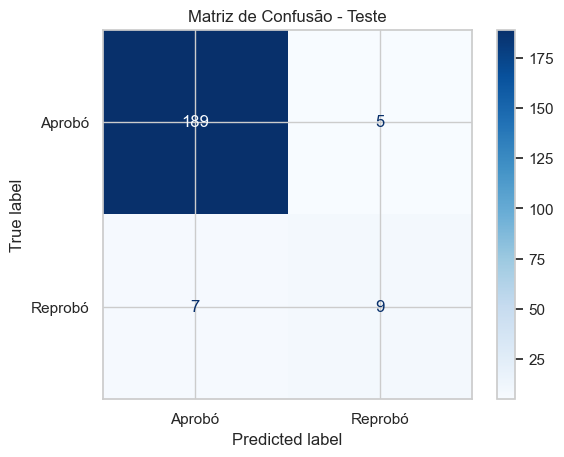


Relatório de classificação semana 12:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       194
           1       0.64      0.56      0.60        16

    accuracy                           0.94       210
   macro avg       0.80      0.77      0.78       210
weighted avg       0.94      0.94      0.94       210



In [42]:
# GridSearchCV para buscar os melhores hiperparâmetros
grid_s12 = hyperparameters_tuning(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Avaliar no conjunto de teste  
best_model_s12 = grid_s12['week12']
y_train_w12_pred = best_model_s12.predict(X_train_w12)
y_val_w12_pred = best_model_s12.predict(X_val_w12)
y_test_w12_pred = best_model_s12.predict(X_test_w12)

print("\nAcurácia no teste semana 12:", accuracy_score(y_test_w12, y_test_w12_pred))
print("\nMatriz de confusão semana 12:\n", confusion_matrix(y_test_w12, y_test_w12_pred))
cm_test = confusion_matrix(y_test_w12, y_test_w12_pred)

print(f"Erro treino = {mean_squared_error(y_train_w12, y_train_w12_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val_w12, y_val_w12_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w12, y_test_w12_pred):.3f}")

plt.figure(figsize=(8, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Aprobó', 'Reprobó'])
disp_test.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Teste')
plt.show()
print("\nRelatório de classificação semana 12:\n", classification_report(y_test_w12, y_test_w12_pred))

Análise de Feature Importance

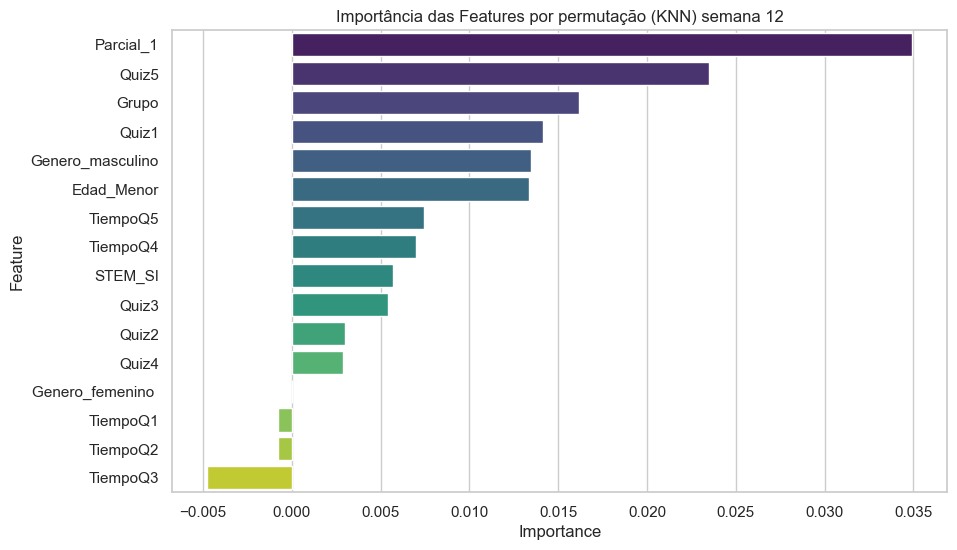

In [43]:
# Feature Importance
# Calcula importâncias por permutação
result = permutation_importance(best_model_s12, X_test_w12, y_test_w12, n_repeats=30, random_state=42)

# Organiza em DataFrame
importances = result.importances_mean
features = X_train_w12.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Importância das Features por permutação (KNN) semana 12")
plt.show()

### 8.4. SEMANA 15

Treinamento do modelo e avaliação dos resultados

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Resultados do GridSearch para week4
Melhores hiperparâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
Melhor score de validação: 0.8971361971361972
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Resultados do GridSearch para week8
Melhores hiperparâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'uniform'}
Melhor score de validação: 0.9615036478672842
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Resultados do GridSearch para week12
Melhores hiperparâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'uniform'}
Melhor score de validação: 0.968651045923773
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Resultados do GridSearch para week15
Melhores hiperparâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'uniform'}
Melhor score de validação: 0.9917521872067327

<Figure size 800x600 with 0 Axes>

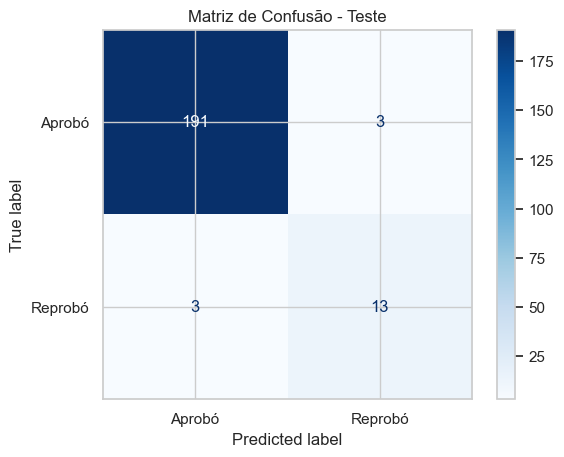


Relatório de classificação semana 15:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       194
           1       0.81      0.81      0.81        16

    accuracy                           0.97       210
   macro avg       0.90      0.90      0.90       210
weighted avg       0.97      0.97      0.97       210



In [44]:
# GridSearchCV para buscar os melhores hiperparâmetros
grid_s15 = hyperparameters_tuning(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)


# Avaliar no conjunto de teste
best_model_s15 = grid_s15['week15']
y_train_w15_pred = best_model_s15.predict(X_train_w15)
y_test_w15_pred = best_model_s15.predict(X_test_w15)
y_val_w15_pred = best_model_s15.predict(X_val_w15)

print("\nAcurácia no teste semana 15:", accuracy_score(y_test_w15, y_test_w15_pred))
print("\nMatriz de confusão semana 15:\n", confusion_matrix(y_test_w15, y_test_w15_pred))
cm_test = confusion_matrix(y_test_w15, y_test_w15_pred)

print(f"Erro treino = {mean_squared_error(y_train_w15, y_train_w15_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val_w15, y_val_w15_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w15, y_test_w15_pred):.3f}")

plt.figure(figsize=(8, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Aprobó', 'Reprobó'])
disp_test.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Teste')
plt.show()
print("\nRelatório de classificação semana 15:\n", classification_report(y_test_w15, y_test_w15_pred))

Análise de Feature Importance

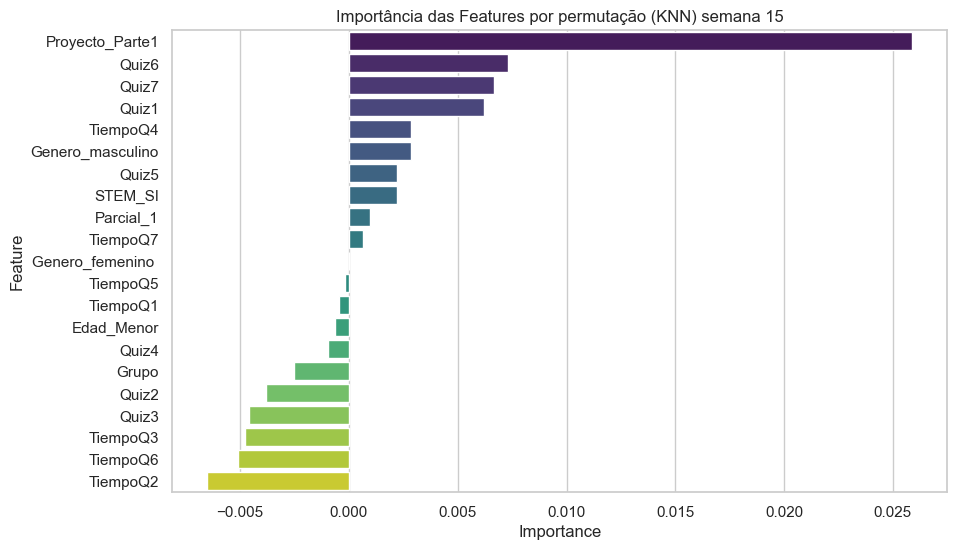

In [45]:
# Feature Importance
# Calcula importâncias por permutação
result = permutation_importance(best_model_s15, X_test_w15, y_test_w15, n_repeats=30, random_state=42)

# Organiza em DataFrame
importances = result.importances_mean
features = X_train_w15.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Importância das Features por permutação (KNN) semana 15")
plt.show()

# 9. Lazy Predict

In [46]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, average_precision_score, precision_recall_curve, f1_score
from sklearn.metrics.pairwise import pairwise_distances
from lazypredict.Supervised import LazyClassifier

# Force LazyPredict to use text-based progress bars instead of notebook widgets
os.environ['TQDM_DISABLE'] = '0'

TARGET_COL   = "Aprobo_Reprobó"
DROP_ALWAYS  = ["Calificación_Oficial_norm", "CalcNotaQuiz_norm"]

# critério de ordenação do ranking (Top-1 por semana)
ORDER_BY     = "Balanced Accuracy"

# métricas adicionais do campeão
TOP_K_PCT      = 0.10   # Precision@K (ex.: 10% mais arriscados)
TARGET_RECALL  = 0.75   # limiar que atinja pelo menos este recall

LABEL_MAP = {
    "Aprobó": 1, "Aprobo": 1, "APROBO": 1, "aprobó": 1,
    "Reprobó": 0, "Reprobo": 0, "REPROBO": 0, "reprobó": 0
}


def preprocess_xy(df):
    y = df[TARGET_COL].copy()

    drop_cols = [c for c in DROP_ALWAYS if c in df.columns]
    X = df.drop(columns=[TARGET_COL] + drop_cols, errors="ignore").copy()

    if y.dtype == "object":
        y = y.astype(str).str.strip()
        unknown = set(y.unique()) - set(LABEL_MAP.keys())
        if unknown:
            raise ValueError(
                f"Valores de alvo não mapeados: {unknown}. "
                f"Ajuste LABEL_MAP para cobrir todos os valores."
            )
        y = y.map(LABEL_MAP)

    X = X.replace([np.inf, -np.inf], np.nan)
    X_cat = X.select_dtypes(exclude=[np.number])
    X_num = X.select_dtypes(include=[np.number])
    if not X_cat.empty:
        X_cat = pd.get_dummies(X_cat, drop_first=True)
        X = pd.concat([X_num, X_cat], axis=1)
    else:
        X = X_num

    X = X.fillna(X.median(numeric_only=True))
    if X.shape[1] == 0:
        raise ValueError("Após o pré-processamento, não sobraram colunas preditoras.")
    return X, y

def run_lazy(X, y, test_size=0.5, seed=123):
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=seed, stratify=y
        )
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=seed
        )
    
    # Initialize LazyClassifier with additional parameters to avoid widget issues
    try:
        # Try to force text-based progress bar
        clf = LazyClassifier(
            verbose=0, 
            ignore_warnings=True, 
            custom_metric=None,
            predictions=True  # This might help avoid some widget-related issues
        )
    except TypeError:
        # Fallback to basic initialization
        clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    
    models_df, _ = clf.fit(X_train, X_test, y_train, y_test)
    return models_df, clf, X_test, y_test

# score contínuo para modelos sem probas/decision_function (NearestCentroid: margem de distância)
def get_scores(est, X):
    if hasattr(est, "predict_proba"):
        return est.predict_proba(X)[:, 1]
    if hasattr(est, "decision_function"):
        s = est.decision_function(X)
        return s if np.ndim(s) == 1 else s[:, 1]
    try:
        from sklearn.neighbors import NearestCentroid
        if isinstance(est, NearestCentroid) and hasattr(est, "centroids_") and hasattr(est, "classes_"):
            classes = list(est.classes_)
            if 0 in classes and 1 in classes:
                c0 = est.centroids_[classes.index(0)]
                c1 = est.centroids_[classes.index(1)]
                d0 = pairwise_distances(X, c0.reshape(1, -1))
                d1 = pairwise_distances(X, c1.reshape(1, -1))
                margin = (d0 - d1).ravel()
                return margin
    except Exception:
        pass
    return est.predict(X)

def add_precision_recall_via_models(models_df, clf, X_test, y_test):
    y_true = pd.Series(y_test).reset_index(drop=True)
    precisions, recalls = {}, {}
    for model_name, est in clf.models.items():
        try:
            y_pred = pd.Series(est.predict(X_test)).reset_index(drop=True)
            if len(y_pred) != len(y_true):
                precisions[model_name] = np.nan
                recalls[model_name] = np.nan
                continue
            precisions[model_name] = precision_score(y_true, y_pred, zero_division=0)
            recalls[model_name]    = recall_score(y_true, y_pred, zero_division=0)
        except Exception:
            precisions[model_name] = np.nan
            recalls[model_name] = np.nan

    tbl = models_df.copy().reset_index().rename(columns={"index": "Model"})
    tbl["Precision"] = tbl["Model"].map(precisions)
    tbl["Recall"]    = tbl["Model"].map(recalls)
    return tbl

def extra_metrics_of_best(est, X_test, y_test, top_k_pct=0.10, target_recall=0.75):
    y_true  = np.asarray(pd.Series(y_test).reset_index(drop=True)).astype(int)
    scores  = np.asarray(get_scores(est, X_test))
    ap      = float(average_precision_score(y_true, scores))

    k = max(1, int(round(top_k_pct * len(scores))))
    order = np.argsort(scores)[::-1]
    precision_at_k = float(y_true[order[:k]].mean())

    prec, rec, thr = precision_recall_curve(y_true, scores)
    idx = np.where(rec[:-1] >= target_recall)[0]
    if len(idx):
        t = float(thr[idx[0]])
        y_pred_thr = (scores >= t).astype(int)
        p_thr = float(precision_score(y_true, y_pred_thr, zero_division=0))
        r_thr = float(recall_score(y_true, y_pred_thr, zero_division=0))
        f_thr = float(f1_score(y_true, y_pred_thr, zero_division=0))
    else:
        t = np.nan; p_thr = np.nan; r_thr = np.nan; f_thr = np.nan

    return {
        "Avg Precision (AUC-PR)": ap,
        f"Precision@{int(top_k_pct*100)}%": precision_at_k,
        f"Threshold@Recall≥{target_recall:.2f}": t,
        "Precision@Threshold": p_thr,
        "Recall@Threshold": r_thr,
        "F1@Threshold": f_thr,
    }


# Execução por semana


weekly_tables = {}
summary_rows  = []

prec_k_key  = f"Precision@{int(TOP_K_PCT*100)}%"
thr_key     = f"Threshold@Recall≥{TARGET_RECALL:.2f}"

# dicionário com os DataFrames já prontos
DATASETS = {
    "week4": df_week4,
    "week8": df_week8,
    "week12": df_week12,
    "week15": df_week15,
}

for week_tag, dfw in DATASETS.items():
    print(f"\n===== {week_tag.upper()} =====")
    X, y = preprocess_xy(dfw)

    models_df, clf, X_test, y_test = run_lazy(X, y, test_size=0.5, seed=123)

    models_sorted = (
        models_df.sort_values(ORDER_BY, ascending=False)
        if ORDER_BY in models_df.columns else models_df.copy()
    )

    full_table = add_precision_recall_via_models(models_sorted, clf, X_test, y_test)

    try:
        from IPython.display import display
        display(full_table)
    except Exception:
        print(full_table.to_string(index=False))

    weekly_tables[week_tag] = full_table

    top_row   = full_table.iloc[0]
    best_name = top_row["Model"]
    best_est  = clf.models.get(best_name)

    extras = extra_metrics_of_best(
        best_est, X_test, y_test,
        top_k_pct=TOP_K_PCT,
        target_recall=TARGET_RECALL
    )

    row = {
        "week": week_tag,
        "TopModel_by": ORDER_BY,
        "Model": best_name,
        "Accuracy": top_row.get("Accuracy", np.nan),
        "Balanced Accuracy": top_row.get("Balanced Accuracy", np.nan),
        "Precision": top_row.get("Precision", np.nan),
        "Recall": top_row.get("Recall", np.nan),
        "F1 Score": top_row.get("F1 Score", np.nan),
        "ROC AUC": top_row.get("ROC AUC", np.nan),
        "Time Taken": top_row.get("Time Taken", np.nan),
        "n_models": len(full_table),
        **extras
    }
    summary_rows.append(row)

    print("----- Detalhes do campeão (Balanced Accuracy) -----")
    print(f"Modelo: {best_name}")
    print(f"Balanced Accuracy: {row['Balanced Accuracy']:.4f} | Accuracy: {row['Accuracy']:.4f} | F1: {row['F1 Score']:.4f}")
    print(f"AUC-PR (Average Precision): {row['Avg Precision (AUC-PR)']:.4f}")
    print(f"{prec_k_key}: {row[prec_k_key]:.4f}")
    print(f"Threshold p/ Recall ≥ {TARGET_RECALL:.2f}: {row[thr_key]}")
    print(f"  -> Precision@thr: {row['Precision@Threshold']}, Recall@thr: {row['Recall@Threshold']}, F1@thr: {row['F1@Threshold']}")

# Consolidação
df_summary = pd.DataFrame(summary_rows)

print("\n===== TOP-1 por semana =====")
print(df_summary.to_string(index=False))




===== WEEK4 =====


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 49, number of negative: 648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 697, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070301 -> initscore=-2.582070
[LightGBM] [Info] Start training from score -2.582070
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

Model  Accuracy  Balanced Accuracy  ROC AUC  \
0                 NearestCentroid      0.82               0.68     0.68   
1      LinearDiscriminantAnalysis      0.91               0.67     0.67   
2                   SGDClassifier      0.89               0.66     0.66   
3                      Perceptron      0.90               0.66     0.66   
4   QuadraticDiscriminantAnalysis      0.47               0.60     0.60   
5               BaggingClassifier      0.94               0.59     0.59   
6                   XGBClassifier      0.93               0.58     0.58   
7            ExtraTreesClassifier      0.92               0.57     0.57   
8          RandomForestClassifier      0.93               0.57     0.57   
9                  LGBMClassifier      0.93               0.57     0.57   
10         DecisionTreeClassifier      0.89               0.56     0.56   
11           KNeighborsClassifier      0.94               0.56     0.56   
12                 LabelSpreading      0.92               0.56     0.56   
13            ExtraTreeClassifier      0.89               0.55     0.55   
14               LabelPropagation      0.91               0.55     0.55   
15             AdaBoostClassifier      0.93               0.54     0.54   
16    PassiveAggressiveClassifier      0.81               0.51     0.51   
17                     GaussianNB      0.08               0.50     0.50   
18             LogisticRegression      0.93               0.50     0.50   
19                DummyClassifier      0.93               0.50     0.50   
20                RidgeClassifier      0.93               0.50     0.50   
21              RidgeClassifierCV      0.93               0.50     0.50   
22         CalibratedClassifierCV      0.93               0.50     0.50   
23                            SVC      0.93               0.50     0.50   
24                    BernoulliNB      0.93               0.50     0.50   
25                      LinearSVC      0.93               0.50     0.50   

    F1 Score  Time Taken  Precision  Recall  
0       0.85        0.01       0.20    0.52  
1       0.91        0.02       0.39    0.38  
2       0.90        0.01       0.30    0.40  
3       0.91        0.01       0.35    0.38  
4       0.57        0.01       0.10    0.76  
5       0.92        0.02       0.69    0.18  
6       0.91        0.13       0.56    0.18  
7       0.91        0.06       0.36    0.16  
8       0.91        0.07       0.70    0.14  
9       0.91        0.33       0.58    0.14  
10      0.89        0.01       0.20    0.18  
11      0.91        0.02       0.86    0.12  
12      0.90        0.02       0.32    0.14  
13      0.89        0.01       0.20    0.16  
14      0.90        0.01       0.25    0.14  
15      0.91        0.07       0.67    0.08  
16      0.84        0.01       0.08    0.16  
17      0.02        0.01       0.07    1.00  
18      0.89        0.01       0.00    0.00  
19      0.89        0.00       0.00    0.00  
20      0.89        0.01       0.00    0.00  
21      0.89        0.01       0.00    0.00  
22      0.89        0.02       0.00    0.00  
23      0.89        0.02       0.00    0.00  
24      0.89        0.01       0.00    0.00  
25      0.89        0.01       0.00    0.00

----- Detalhes do campeão (Balanced Accuracy) -----
Modelo: NearestCentroid
Balanced Accuracy: 0.6798 | Accuracy: 0.8166 | F1: 0.8513
AUC-PR (Average Precision): 0.2540
Precision@10%: 0.3000
Threshold p/ Recall ≥ 0.75: 0.0026417043681547917
  -> Precision@thr: 0.07163323782234957, Recall@thr: 1.0, F1@thr: 0.13368983957219252

===== WEEK8 =====


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 49, number of negative: 648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 616
[LightGBM] [Info] Number of data points in the train set: 697, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070301 -> initscore=-2.582070
[LightGBM] [Info] Start training from score -2.582070
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Model  Accuracy  Balanced Accuracy  ROC AUC  \
0                 NearestCentroid      0.87               0.82     0.82   
1      LinearDiscriminantAnalysis      0.95               0.81     0.81   
2     PassiveAggressiveClassifier      0.83               0.80     0.80   
3          DecisionTreeClassifier      0.91               0.73     0.73   
4                      Perceptron      0.91               0.72     0.72   
5                  LGBMClassifier      0.94               0.71     0.71   
6              LogisticRegression      0.95               0.71     0.71   
7              AdaBoostClassifier      0.95               0.70     0.70   
8                     BernoulliNB      0.93               0.70     0.70   
9                   XGBClassifier      0.94               0.69     0.69   
10                      LinearSVC      0.95               0.69     0.69   
11              BaggingClassifier      0.94               0.67     0.67   
12                 LabelSpreading      0.93               0.67     0.67   
13               LabelPropagation      0.93               0.67     0.67   
14         CalibratedClassifierCV      0.95               0.66     0.66   
15           KNeighborsClassifier      0.94               0.65     0.65   
16           ExtraTreesClassifier      0.94               0.64     0.64   
17                  SGDClassifier      0.92               0.64     0.64   
18            ExtraTreeClassifier      0.90               0.64     0.64   
19              RidgeClassifierCV      0.95               0.64     0.64   
20                RidgeClassifier      0.95               0.64     0.64   
21         RandomForestClassifier      0.94               0.64     0.64   
22                            SVC      0.94               0.61     0.61   
23  QuadraticDiscriminantAnalysis      0.63               0.61     0.61   
24                     GaussianNB      0.08               0.50     0.50   
25                DummyClassifier      0.93               0.50     0.50   

    F1 Score  Time Taken  Precision  Recall  
0       0.89        0.01       0.32    0.76  
1       0.95        0.02       0.70    0.64  
2       0.86        0.01       0.26    0.76  
3       0.92        0.07       0.40    0.52  
4       0.91        0.01       0.40    0.50  
5       0.94        0.39       0.65    0.44  
6       0.94        0.01       0.78    0.42  
7       0.94        0.05       0.70    0.42  
8       0.93        0.01       0.49    0.44  
9       0.93        0.10       0.59    0.40  
10      0.94        0.04       0.86    0.38  
11      0.93        0.02       0.60    0.36  
12      0.92        0.06       0.51    0.36  
13      0.92        0.02       0.50    0.36  
14      0.94        0.02       0.84    0.32  
15      0.93        0.02       0.79    0.30  
16      0.93        0.06       0.65    0.30  
17      0.91        0.01       0.40    0.32  
18      0.90        0.01       0.31    0.34  
19      0.93        0.01       1.00    0.28  
20      0.93        0.01       0.93    0.28  
21      0.93        0.09       0.78    0.28  
22      0.92        0.01       0.85    0.22  
23      0.72        0.01       0.11    0.58  
24      0.02        0.01       0.07    1.00  
25      0.89        0.01       0.00    0.00

----- Detalhes do campeão (Balanced Accuracy) -----
Modelo: NearestCentroid
Balanced Accuracy: 0.8183 | Accuracy: 0.8682 | F1: 0.8912
AUC-PR (Average Precision): 0.6503
Precision@10%: 0.4714
Threshold p/ Recall ≥ 0.75: 1.0853362321374786e-09
  -> Precision@thr: 0.07163323782234957, Recall@thr: 1.0, F1@thr: 0.13368983957219252

===== WEEK12 =====


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 49, number of negative: 648
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 697, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070301 -> initscore=-2.582070
[LightGBM] [Info] Start training from score -2.582070
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Model  Accuracy  Balanced Accuracy  ROC AUC  \
0                 NearestCentroid      0.88               0.83     0.83   
1      LinearDiscriminantAnalysis      0.95               0.81     0.81   
2                      Perceptron      0.93               0.80     0.80   
3                     BernoulliNB      0.92               0.77     0.77   
4                   SGDClassifier      0.95               0.77     0.77   
5              LogisticRegression      0.96               0.75     0.75   
6              AdaBoostClassifier      0.95               0.75     0.75   
7          DecisionTreeClassifier      0.92               0.73     0.73   
8                  LGBMClassifier      0.95               0.72     0.72   
9                       LinearSVC      0.95               0.72     0.72   
10                  XGBClassifier      0.95               0.72     0.72   
11                 LabelSpreading      0.93               0.71     0.71   
12               LabelPropagation      0.93               0.71     0.71   
13         RandomForestClassifier      0.95               0.69     0.69   
14              BaggingClassifier      0.95               0.69     0.69   
15           ExtraTreesClassifier      0.95               0.68     0.68   
16         CalibratedClassifierCV      0.95               0.68     0.68   
17            ExtraTreeClassifier      0.92               0.66     0.66   
18                RidgeClassifier      0.95               0.65     0.65   
19              RidgeClassifierCV      0.95               0.65     0.65   
20           KNeighborsClassifier      0.95               0.65     0.65   
21                            SVC      0.95               0.64     0.64   
22                     GaussianNB      0.28               0.61     0.61   
23  QuadraticDiscriminantAnalysis      0.41               0.54     0.54   
24    PassiveAggressiveClassifier      0.93               0.52     0.52   
25                DummyClassifier      0.93               0.50     0.50   

    F1 Score  Time Taken  Precision  Recall  
0       0.90        0.01       0.35    0.78  
1       0.95        0.01       0.65    0.64  
2       0.93        0.01       0.50    0.64  
3       0.93        0.01       0.47    0.60  
4       0.95        0.01       0.65    0.56  
5       0.95        0.01       0.79    0.52  
6       0.95        0.06       0.70    0.52  
7       0.92        0.01       0.43    0.52  
8       0.94        0.26       0.72    0.46  
9       0.95        0.01       0.85    0.44  
10      0.94        0.10       0.79    0.44  
11      0.93        0.02       0.55    0.44  
12      0.93        0.01       0.55    0.44  
13      0.94        0.08       0.90    0.38  
14      0.94        0.03       0.79    0.38  
15      0.94        0.07       0.86    0.36  
16      0.94        0.02       0.86    0.36  
17      0.92        0.01       0.45    0.36  
18      0.94        0.01       0.94    0.30  
19      0.94        0.01       0.94    0.30  
20      0.93        0.02       0.83    0.30  
21      0.93        0.01       0.88    0.28  
22      0.35        0.01       0.09    1.00  
23      0.52        0.01       0.08    0.70  
24      0.90        0.01       1.00    0.04  
25      0.89        0.01       0.00    0.00

----- Detalhes do campeão (Balanced Accuracy) -----
Modelo: NearestCentroid
Balanced Accuracy: 0.8337 | Accuracy: 0.8797 | F1: 0.8997
AUC-PR (Average Precision): 0.6800
Precision@10%: 0.4857
Threshold p/ Recall ≥ 0.75: 2.1962348339712895e-13
  -> Precision@thr: 0.07163323782234957, Recall@thr: 1.0, F1@thr: 0.13368983957219252

===== WEEK15 =====


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 49, number of negative: 648
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1294
[LightGBM] [Info] Number of data points in the train set: 697, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070301 -> initscore=-2.582070
[LightGBM] [Info] Start training from score -2.582070
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

Model  Accuracy  Balanced Accuracy  ROC AUC  \
0                   SGDClassifier      0.98               0.94     0.94   
1     PassiveAggressiveClassifier      0.96               0.93     0.93   
2                      Perceptron      0.96               0.92     0.92   
3              LogisticRegression      0.97               0.92     0.92   
4          DecisionTreeClassifier      0.97               0.92     0.92   
5                 NearestCentroid      0.95               0.92     0.92   
6                       LinearSVC      0.97               0.91     0.91   
7              AdaBoostClassifier      0.98               0.90     0.90   
8      LinearDiscriminantAnalysis      0.97               0.89     0.89   
9                  LGBMClassifier      0.98               0.88     0.88   
10                  XGBClassifier      0.97               0.87     0.87   
11              BaggingClassifier      0.96               0.86     0.86   
12                    BernoulliNB      0.92               0.86     0.86   
13         CalibratedClassifierCV      0.97               0.86     0.86   
14                            SVC      0.97               0.85     0.85   
15                RidgeClassifier      0.96               0.85     0.85   
16              RidgeClassifierCV      0.96               0.85     0.85   
17                 LabelSpreading      0.97               0.84     0.84   
18               LabelPropagation      0.97               0.84     0.84   
19                     GaussianNB      0.69               0.84     0.84   
20         RandomForestClassifier      0.97               0.83     0.83   
21           ExtraTreesClassifier      0.97               0.82     0.82   
22           KNeighborsClassifier      0.96               0.78     0.78   
23            ExtraTreeClassifier      0.94               0.76     0.76   
24  QuadraticDiscriminantAnalysis      0.57               0.59     0.59   
25                DummyClassifier      0.93               0.50     0.50   

    F1 Score  Time Taken  Precision  Recall  
0       0.98        0.01       0.79    0.90  
1       0.97        0.02       0.70    0.88  
2       0.96        0.01       0.67    0.88  
3       0.97        0.01       0.80    0.86  
4       0.97        0.01       0.73    0.86  
5       0.95        0.01       0.60    0.88  
6       0.97        0.01       0.76    0.84  
7       0.98        0.10       0.84    0.82  
8       0.97        0.01       0.77    0.80  
9       0.97        0.26       0.88    0.76  
10      0.97        0.06       0.83    0.76  
11      0.96        0.03       0.76    0.74  
12      0.93        0.01       0.48    0.78  
13      0.97        0.02       0.90    0.72  
14      0.97        0.01       0.84    0.72  
15      0.96        0.01       0.77    0.72  
16      0.96        0.01       0.77    0.72  
17      0.96        0.02       0.80    0.70  
18      0.96        0.02       0.80    0.70  
19      0.77        0.01       0.19    1.00  
20      0.97        0.11       0.85    0.66  
21      0.96        0.06       0.84    0.64  
22      0.96        0.02       0.81    0.58  
23      0.94        0.01       0.58    0.56  
24      0.67        0.01       0.10    0.62  
25      0.89        0.01       0.00    0.00

----- Detalhes do campeão (Balanced Accuracy) -----
Modelo: SGDClassifier
Balanced Accuracy: 0.9407 | Accuracy: 0.9756 | F1: 0.9764
AUC-PR (Average Precision): 0.9113
Precision@10%: 0.6571
Threshold p/ Recall ≥ 0.75: -385.8683249319242
  -> Precision@thr: 0.07163323782234957, Recall@thr: 1.0, F1@thr: 0.13368983957219252

===== TOP-1 por semana =====
  week       TopModel_by           Model  Accuracy  Balanced Accuracy  Precision  Recall  F1 Score  ROC AUC  Time Taken  n_models  Avg Precision (AUC-PR)  Precision@10%  Threshold@Recall≥0.75  Precision@Threshold  Recall@Threshold  F1@Threshold
 week4 Balanced Accuracy NearestCentroid      0.82               0.68       0.20    0.52      0.85     0.68        0.01        26                    0.25           0.30                   0.00                 0.07              1.00          0.13
 week8 Balanced Accuracy NearestCentroid      0.87               0.82       0.32    0.76      0.89     0.82        0.01        26                    0.65     

# 10. Árvora de Decisão

Semana 4

Tamanhos dos conjuntos:
Treino: 976 | Validação: 209 | Teste: 210
Acurácia de Treinamento: 0.9436475409836066
Acurácia de Teste: 0.9333333333333333
Erro treino = 0.056
Erro validação = 0.081
Erro teste = 0.067


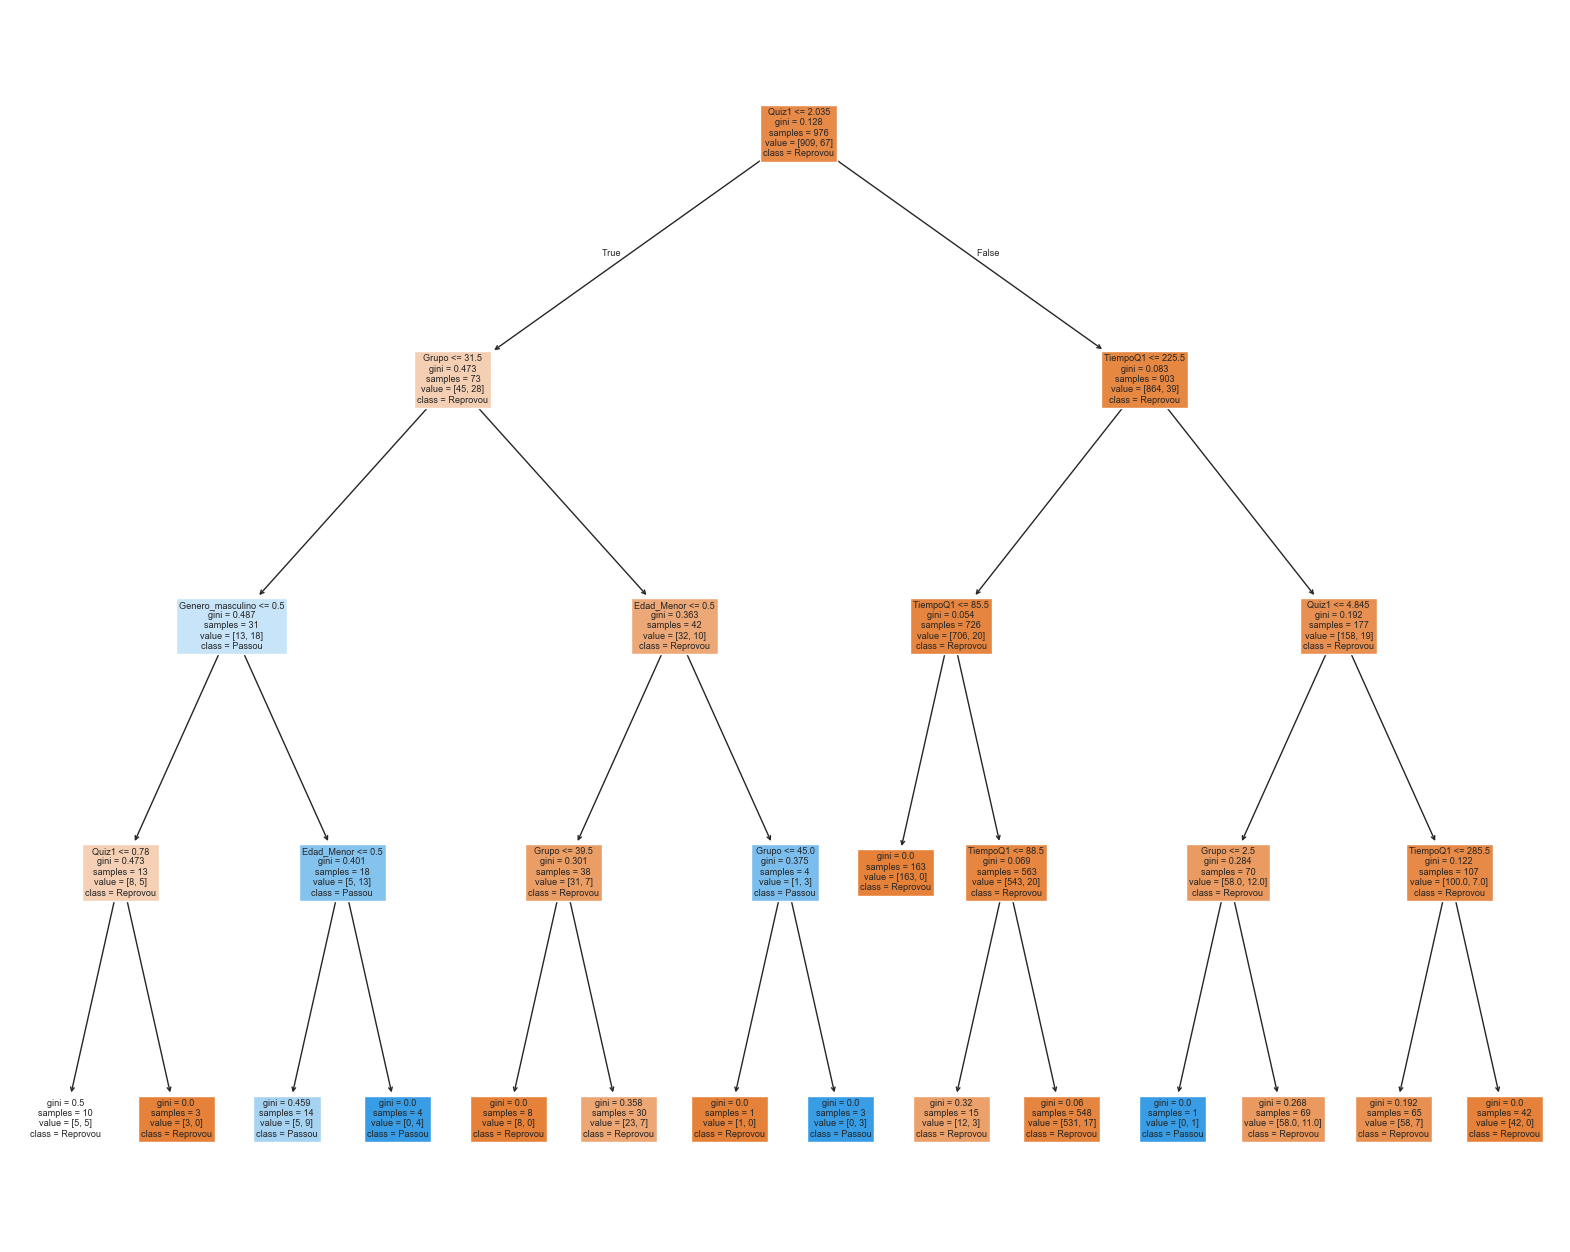

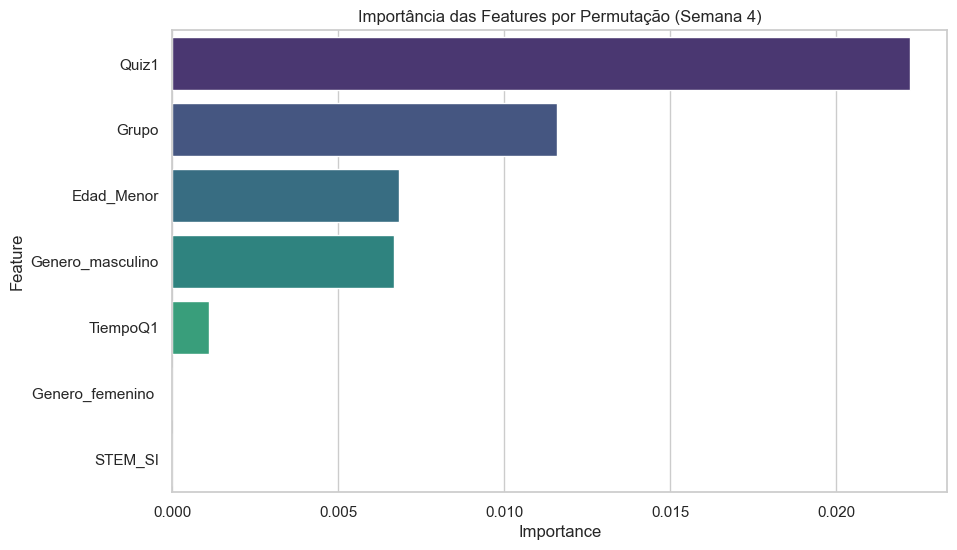

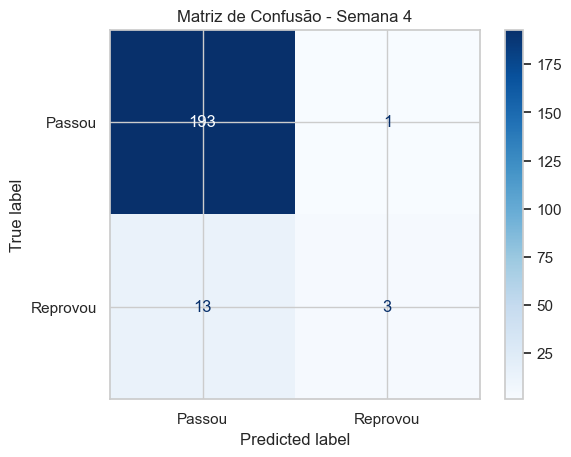


Relatório de classificação semana 4:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       194
           1       0.75      0.19      0.30        16

    accuracy                           0.93       210
   macro avg       0.84      0.59      0.63       210
weighted avg       0.92      0.93      0.91       210



In [47]:
# TESTES SEMANA 4

# Faz a divisão dos dados utilizados no treino (X) e o que está sendo previsto (y)
X = df_week4.drop(columns=['Aprobo_Reprobó'], errors='ignore')
y = df_week4['Aprobo_Reprobó']

# Divide os dados em treino (70%), validação (15%) e teste (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Visualização dos resultados pelo terminal
print("Tamanhos dos conjuntos:")
print(f"Treino: {X_train.shape[0]} | Validação: {X_val.shape[0]} | Teste: {X_test.shape[0]}")

# Cria o modelo de Árvore de Decisão
clf = DecisionTreeClassifier(max_depth=4, random_state=42)

# Treina o modelo
clf.fit(X_train, y_train)

# Predições
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_test)

# Visualização do desempenho do modelo no terminal
print("Acurácia de Treinamento:", clf.score(X_train, y_train))
print("Acurácia de Teste:", clf.score(X_test, y_test))

print(f"Erro treino = {mean_squared_error(y_train, y_train_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val, y_val_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test, y_test_pred):.3f}")

# Gera a visualização gráfica da árvore de decisão
plt.figure(figsize=(20, 16))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=["Reprovou","Passou"])
plt.show()

# Calcula importâncias
result = permutation_importance(clf, X_test, y_test, n_repeats=30, random_state=42)

# Organiza em DataFrame
importances = result.importances_mean
features = X_train.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Importância das Features por Permutação (Semana 4)")
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test, clf.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Passou", "Reprovou"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - Semana 4")
plt.show()

print("\nRelatório de classificação semana 4:\n", classification_report(y_test, clf.predict(X_test)))

Semana 8 

Tamanhos dos conjuntos:
Treino: 976 | Validação: 209 | Teste: 210
Acurácia de Treinamento: 0.9600409836065574
Acurácia de Teste: 0.9285714285714286
Erro treino = 0.040
Erro validação = 0.067
Erro teste = 0.071


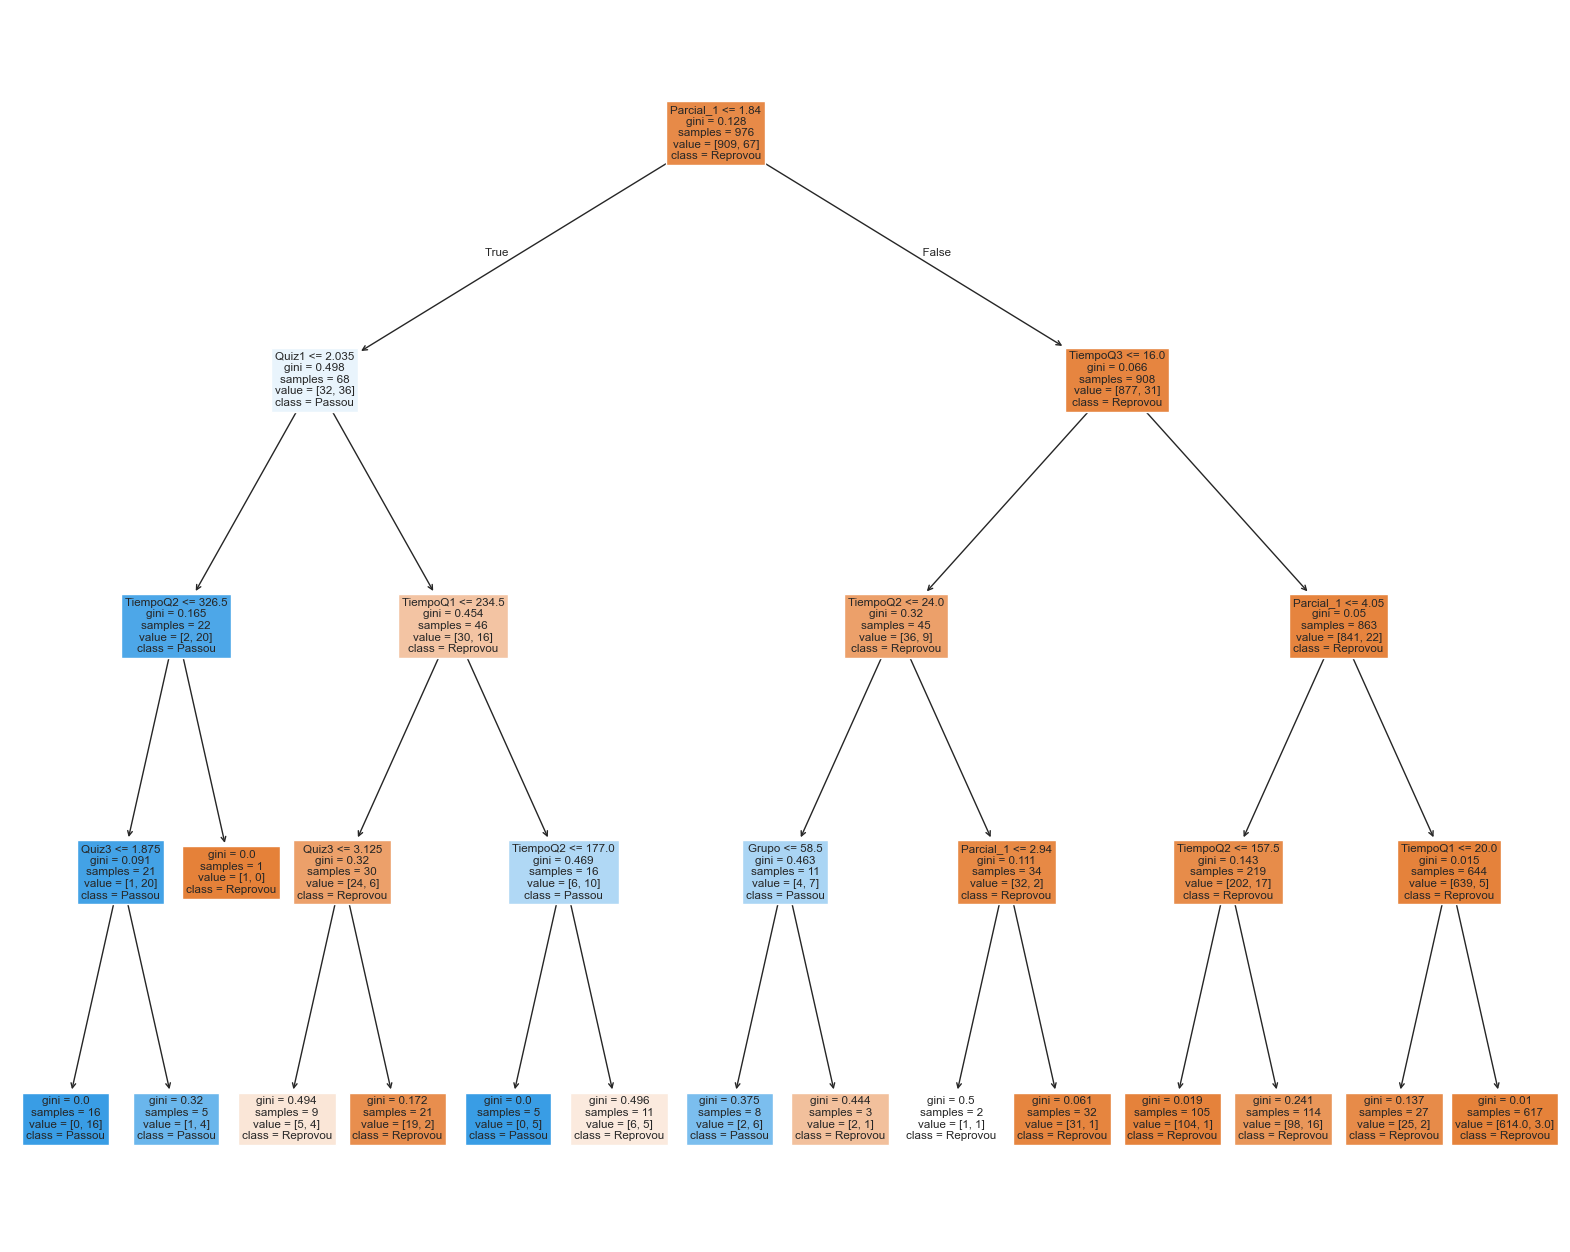

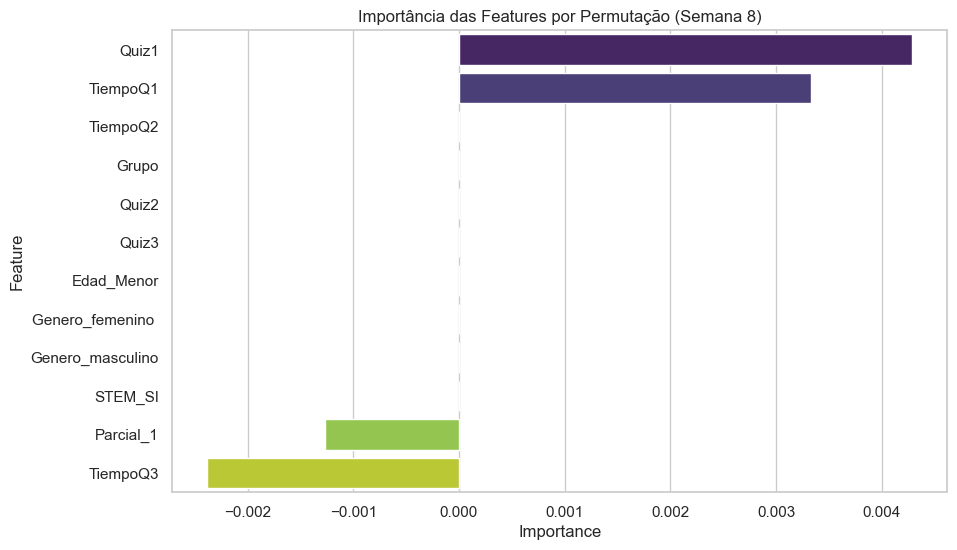

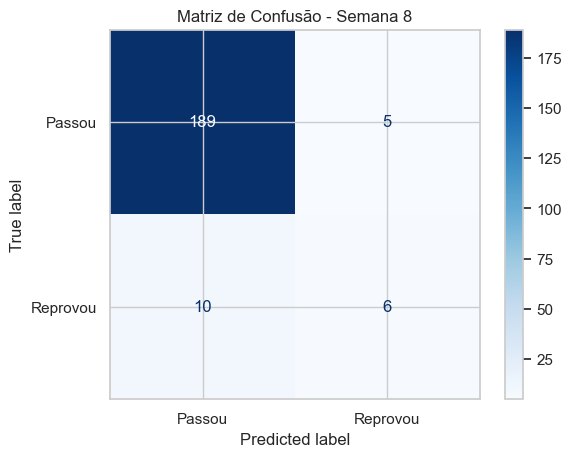


Relatório de classificação semana 8:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       194
           1       0.55      0.38      0.44        16

    accuracy                           0.93       210
   macro avg       0.75      0.67      0.70       210
weighted avg       0.92      0.93      0.92       210



In [48]:
# TESTES SEMANA 8

# Faz a divisão dos dados utilizados no treino (X) e o que está sendo previsto (y)
X = df_week8.drop(columns=['Aprobo_Reprobó'], errors='ignore')
y = df_week8['Aprobo_Reprobó']

# Divide os dados em treino (70%), validação (15%) e teste (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Visualização dos resultados pelo terminal
print("Tamanhos dos conjuntos:")
print(f"Treino: {X_train.shape[0]} | Validação: {X_val.shape[0]} | Teste: {X_test.shape[0]}")

# Cria o modelo de Árvore de Decisão
clf = DecisionTreeClassifier(max_depth=4, random_state=42)

# Treina o modelo
clf.fit(X_train, y_train)

# Predições
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_test)

# Visualização do desempenho do modelo no terminal
print("Acurácia de Treinamento:", clf.score(X_train, y_train))
print("Acurácia de Teste:", clf.score(X_test, y_test))

print(f"Erro treino = {mean_squared_error(y_train, y_train_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val, y_val_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test, y_test_pred):.3f}")

# Gera a visualização gráfica da árvore de decisão
plt.figure(figsize=(20, 16))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=["Reprovou","Passou"])
plt.show()

# Calcula importâncias
result = permutation_importance(clf, X_test, y_test, n_repeats=30, random_state=42)

# Organiza em DataFrame
importances = result.importances_mean
features = X_train.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Importância das Features por Permutação (Semana 8)")
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test, clf.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Passou", "Reprovou"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - Semana 8")
plt.show()

print("\nRelatório de classificação semana 8:\n", classification_report(y_test, clf.predict(X_test)))

Semana 12

Tamanhos dos conjuntos:
Treino: 976 | Validação: 209 | Teste: 210
Acurácia de Treinamento: 0.9661885245901639
Acurácia de Teste: 0.9428571428571428
Erro treino = 0.034
Erro validação = 0.057
Erro teste = 0.057


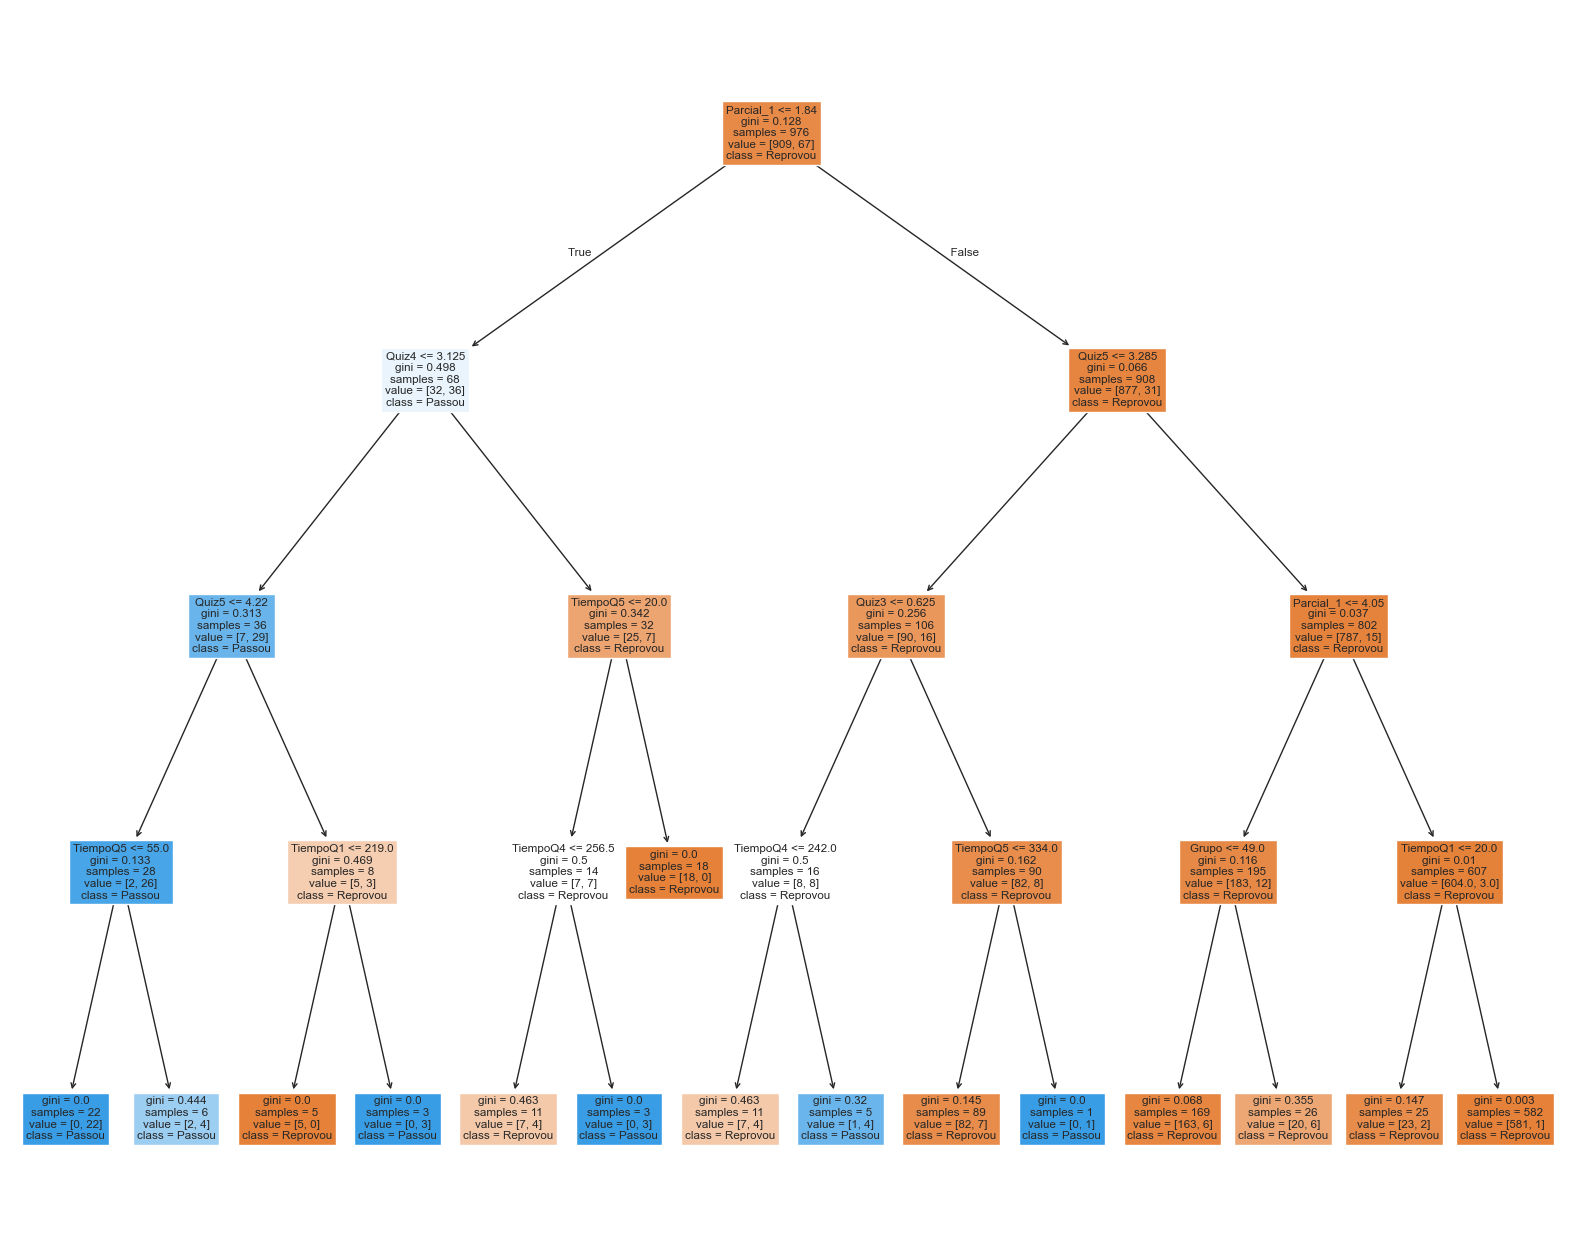

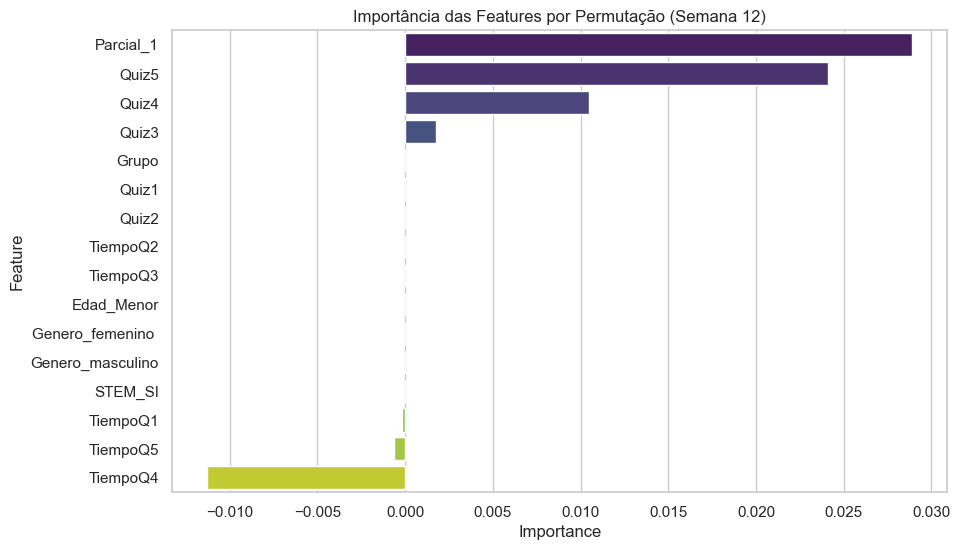

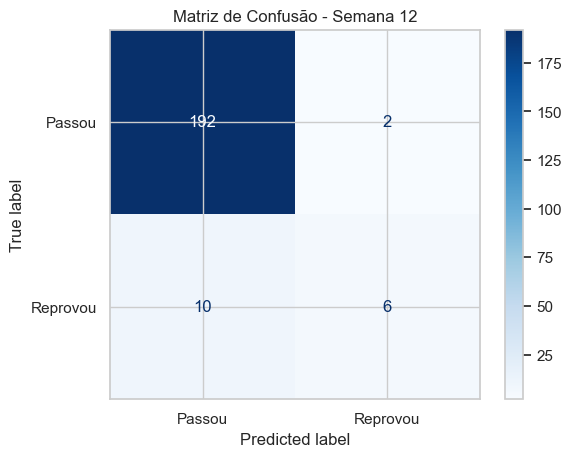


Relatório de classificação semana 12:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       194
           1       0.75      0.38      0.50        16

    accuracy                           0.94       210
   macro avg       0.85      0.68      0.73       210
weighted avg       0.94      0.94      0.93       210



In [49]:
# TESTES SEMANA 12

# Faz a divisão dos dados utilizados no treino (X) e o que está sendo previsto (y)
X = df_week12.drop(columns=['Aprobo_Reprobó'], errors='ignore')
y = df_week12['Aprobo_Reprobó']

# Divide os dados em treino (70%), validação (15%) e teste (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Visualização dos resultados pelo terminal
print("Tamanhos dos conjuntos:")
print(f"Treino: {X_train.shape[0]} | Validação: {X_val.shape[0]} | Teste: {X_test.shape[0]}")

# Cria o modelo de Árvore de Decisão
clf = DecisionTreeClassifier(max_depth=4, random_state=42)

# Treina o modelo
clf.fit(X_train, y_train)

# Predições
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_test)

# Visualização do desempenho do modelo no terminal
print("Acurácia de Treinamento:", clf.score(X_train, y_train))
print("Acurácia de Teste:", clf.score(X_test, y_test))

print(f"Erro treino = {mean_squared_error(y_train, y_train_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val, y_val_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test, y_test_pred):.3f}")

# Gera a visualização gráfica da árvore de decisão
plt.figure(figsize=(20, 16))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=["Reprovou","Passou"])
plt.show()

# Calcula importâncias
result = permutation_importance(clf, X_test, y_test, n_repeats=30, random_state=42)

# Organiza em DataFrame
importances = result.importances_mean
features = X_train.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Importância das Features por Permutação (Semana 12)")
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test, clf.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Passou", "Reprovou"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - Semana 12")
plt.show()

print("\nRelatório de classificação semana 12:\n", classification_report(y_test, clf.predict(X_test)))

Semana 15

Tamanhos dos conjuntos:
Treino: 976 | Validação: 209 | Teste: 210
Acurácia de Treinamento: 0.9825819672131147
Acurácia de Teste: 0.9666666666666667
Erro treino = 0.017
Erro validação = 0.043
Erro teste = 0.033


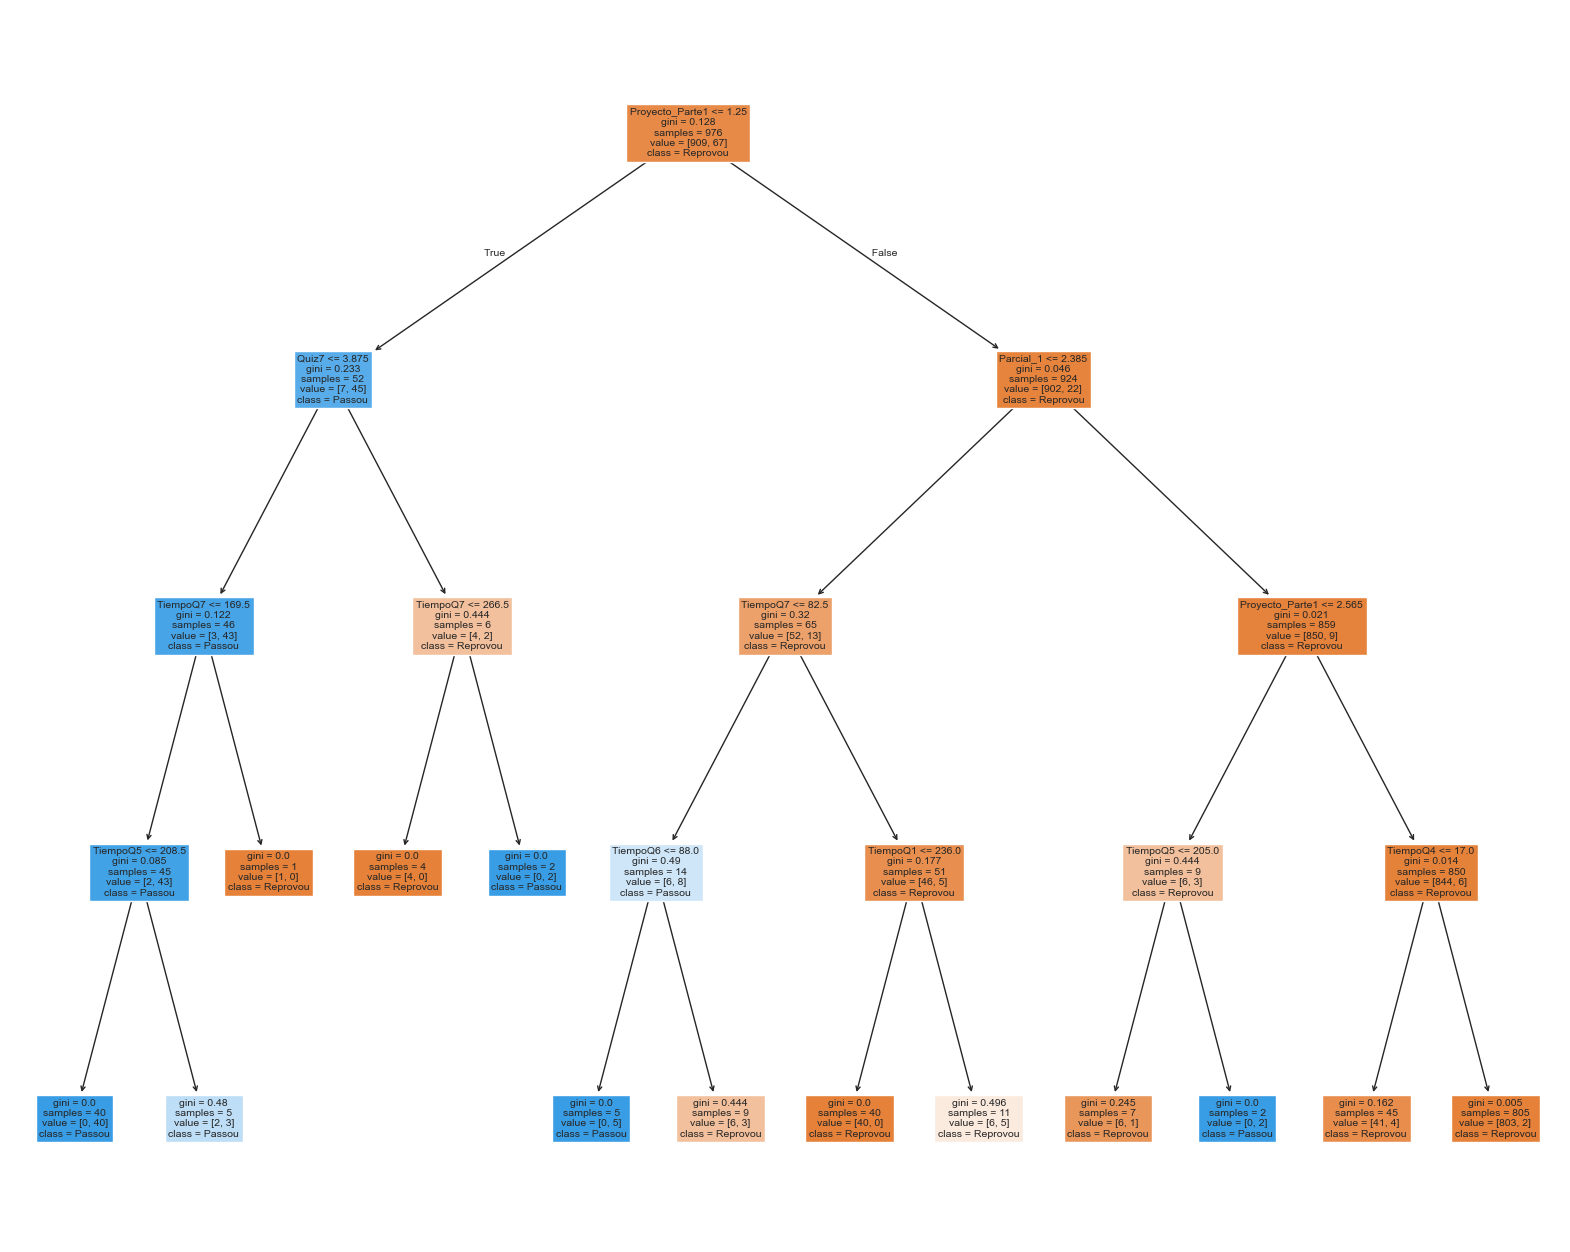

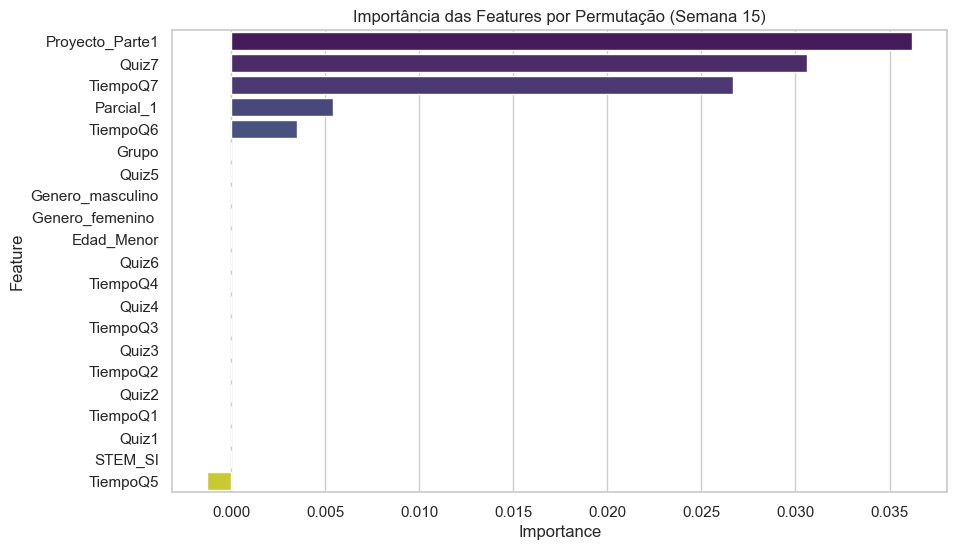

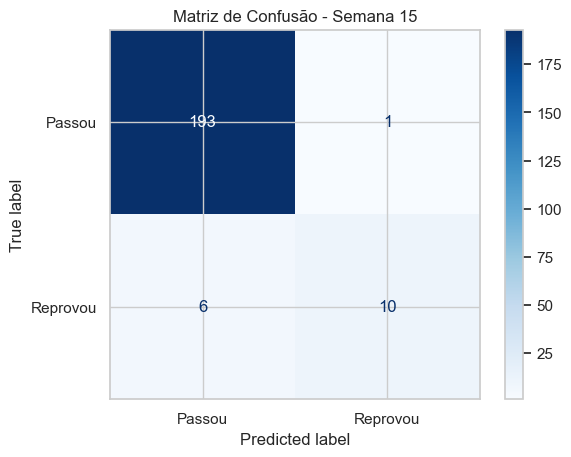


Relatório de classificação semana 15:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       194
           1       0.91      0.62      0.74        16

    accuracy                           0.97       210
   macro avg       0.94      0.81      0.86       210
weighted avg       0.97      0.97      0.96       210



In [50]:
# TESTES SEMANA 15

# Faz a divisão dos dados utilizados no treino (X) e o que está sendo previsto (y)
X = df_week15.drop(columns=['Aprobo_Reprobó'], errors='ignore')
y = df_week15['Aprobo_Reprobó']

# Divide os dados em treino (70%), validação (15%) e teste (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Visualização dos resultados pelo terminal
print("Tamanhos dos conjuntos:")
print(f"Treino: {X_train.shape[0]} | Validação: {X_val.shape[0]} | Teste: {X_test.shape[0]}")

# Cria o modelo de Árvore de Decisão
clf = DecisionTreeClassifier(max_depth=4, random_state=42)

# Treina o modelo
clf.fit(X_train, y_train)

# Predições
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_test)

# Visualização do desempenho do modelo no terminal
print("Acurácia de Treinamento:", clf.score(X_train, y_train))
print("Acurácia de Teste:", clf.score(X_test, y_test))

print(f"Erro treino = {mean_squared_error(y_train, y_train_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val, y_val_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test, y_test_pred):.3f}")

# Gera a visualização gráfica da árvore de decisão
plt.figure(figsize=(20, 16))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=["Reprovou","Passou"])
plt.show()

# Calcula importâncias
result = permutation_importance(clf, X_test, y_test, n_repeats=30, random_state=42)

# Organiza em DataFrame
importances = result.importances_mean
features = X_train.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Importância das Features por Permutação (Semana 15)")
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test, clf.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Passou", "Reprovou"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - Semana 15")
plt.show()

print("\nRelatório de classificação semana 15:\n", classification_report(y_test, clf.predict(X_test)))

Semana 4

Modelo LDA treinado com sucesso para a semana 4.
Acurácia de Treinamento: 0.9159836065573771
Acurácia de Teste: 0.9
Erro treino = 0.084
Erro validação = 0.091
Erro teste = 0.100


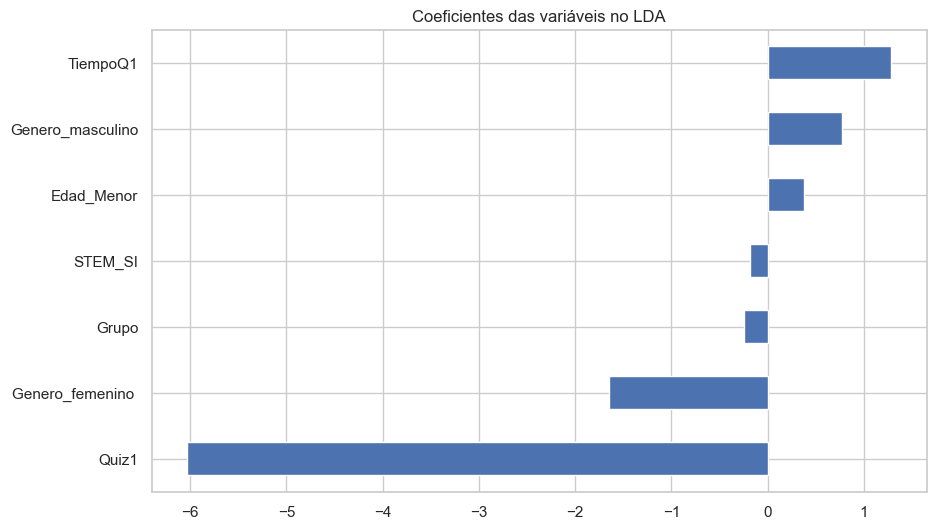

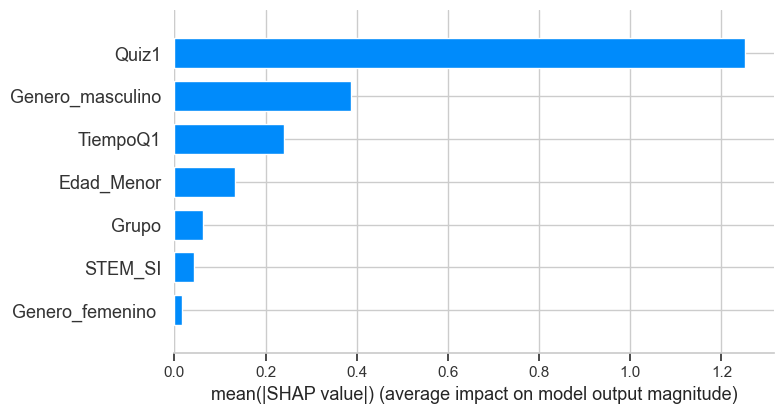

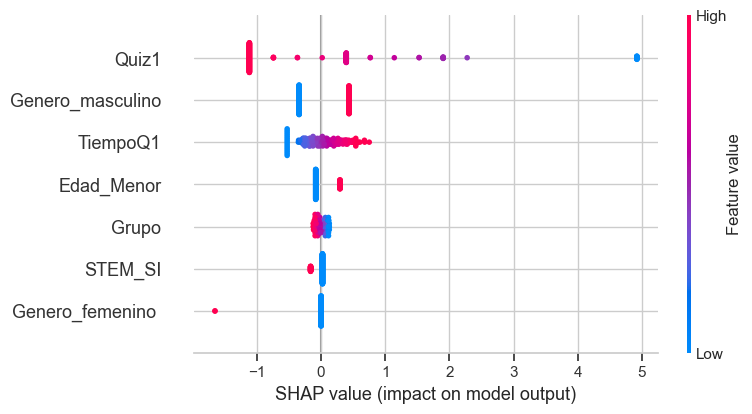

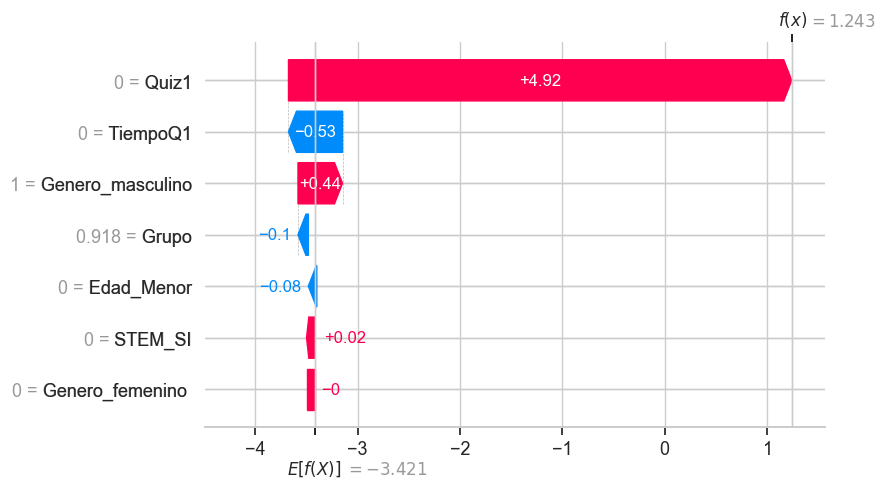

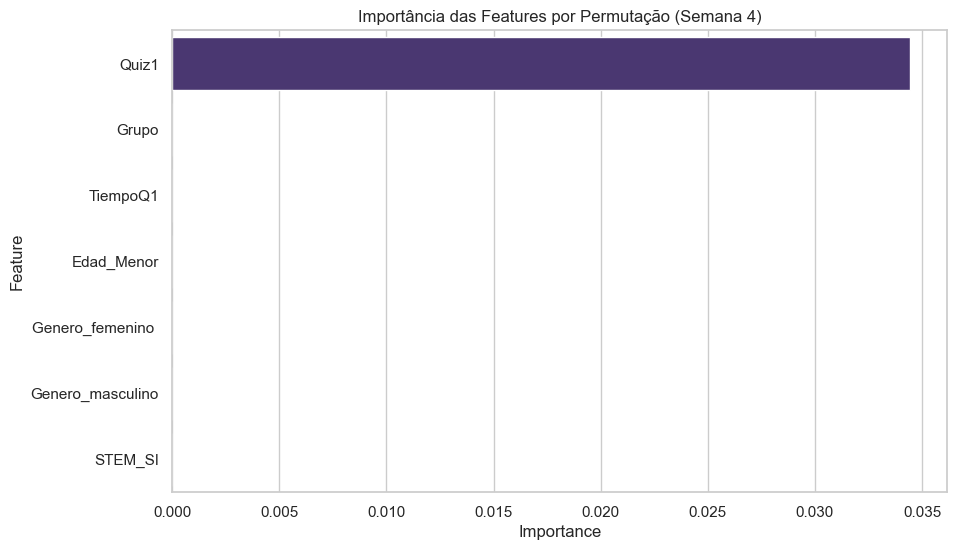

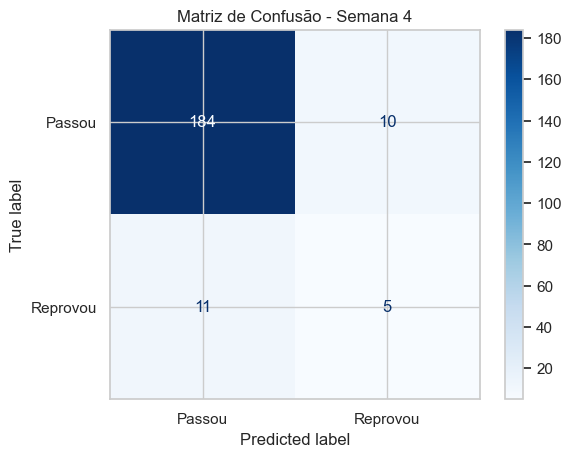


Relatório de classificação semana 4:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95       194
           1       0.33      0.31      0.32        16

    accuracy                           0.90       210
   macro avg       0.64      0.63      0.63       210
weighted avg       0.90      0.90      0.90       210



In [51]:
best_lda_model_w4 = LinearDiscriminantAnalysis()
best_lda_model_w4.fit(X_train_w4, y_train_w4)
print("Modelo LDA treinado com sucesso para a semana 4.")

#Adiciona o SHAP
explainer = shap.Explainer(best_lda_model_w4, X_train_w4)   # cria o explicador
shap_values = explainer(X_test_w4)            # gera os valores SHAP

y_train_w4_pred = best_lda_model_w4.predict(X_train_w4)
y_val_w4_pred = best_lda_model_w4.predict(X_val_w4)
y_test_w4_pred = best_lda_model_w4.predict(X_test_w4)

# Visualização do desempenho do modelo no terminal
print("Acurácia de Treinamento:", best_lda_model_w4.score(X_train_w4, y_train_w4))
print("Acurácia de Teste:", best_lda_model_w4.score(X_test_w4, y_test_w4))

print(f"Erro treino = {mean_squared_error(y_train_w4, y_train_w4_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val_w4, y_val_w4_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w4, y_test_w4_pred):.3f}")

# Gera a visualização gráfica da árvore de decisão
coef = pd.Series(best_lda_model_w4.coef_[0], index=X_week4.columns)

plt.figure(figsize=(10,6))
coef.sort_values().plot(kind='barh')
plt.title("Coeficientes das variáveis no LDA")
plt.show()

# Calcula importâncias
result = permutation_importance(best_lda_model_w4, X_test_w4, y_test_w4, n_repeats=30, random_state=42)

# SHAP summary plot
# INTERPRETAÇÃO GLOBAL

# Gráfico de barras com importância média das features
shap.summary_plot(shap_values, X_test_w4, plot_type="bar")

# Gráfico de pontos (importância + direção do efeito)
shap.summary_plot(shap_values, X_test_w4)

# INTERPRETAÇÃO LOCAL

# Escolhe uma instância específica do teste
i = 5  # por exemplo, a 5ª amostra do conjunto de teste

# Waterfall plot (explicação local da predição)
shap.plots.waterfall(shap_values[i])

# Force plot (explicação interativa – funciona melhor em Jupyter Notebook)
shap.plots.force(shap_values[i])

# Organiza em DataFrame
importances = result.importances_mean
features = X_train_w4.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Importância das Features por Permutação (Semana 4)")
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test_w4, best_lda_model_w4.predict(X_test_w4))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Passou", "Reprovou"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - Semana 4")
plt.show()

print("\nRelatório de classificação semana 4:\n", classification_report(y_test_w4, y_test_w4_pred))

Semana 8

Modelo LDA treinado com sucesso para a semana 8.
Acurácia de Treinamento: 0.9456967213114754
Acurácia de Teste: 0.9380952380952381
Erro treino = 0.054
Erro validação = 0.057
Erro teste = 0.062


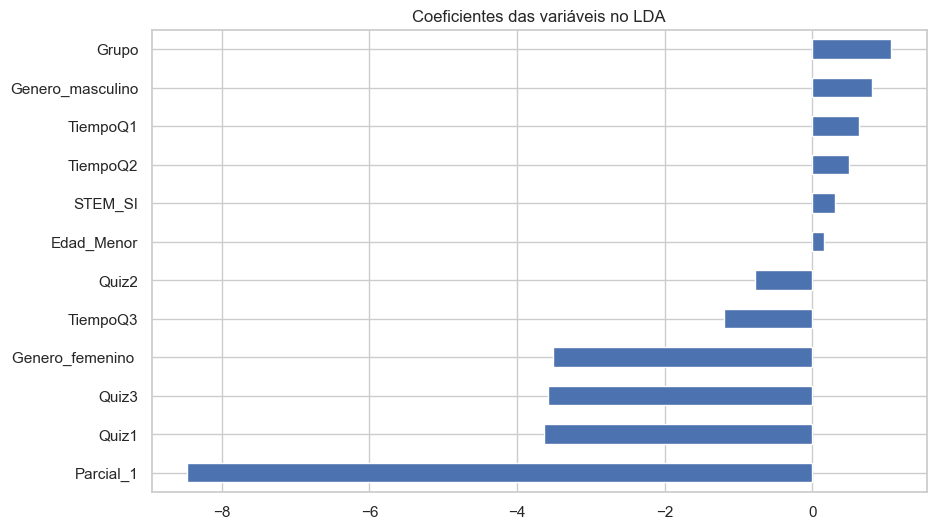

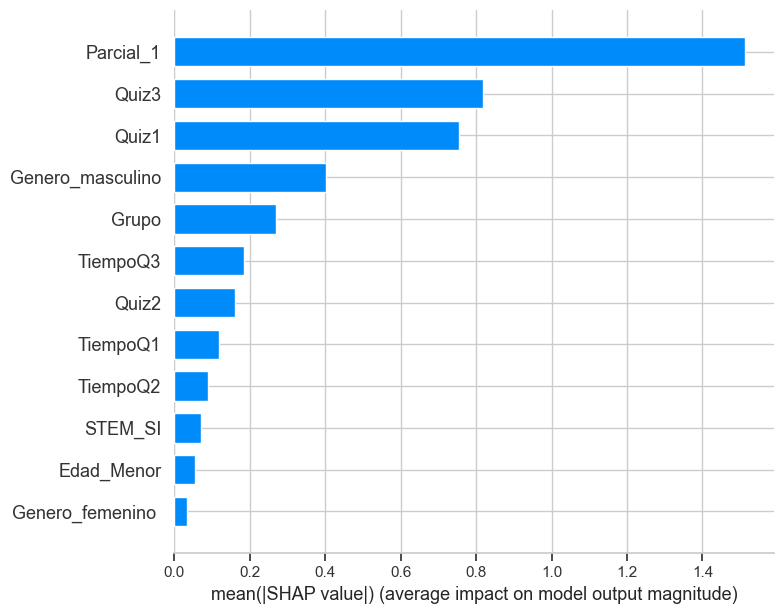

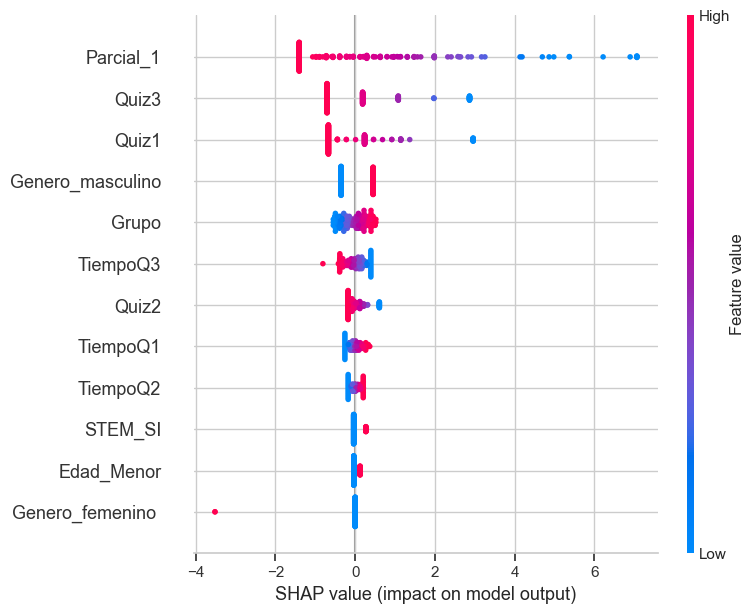

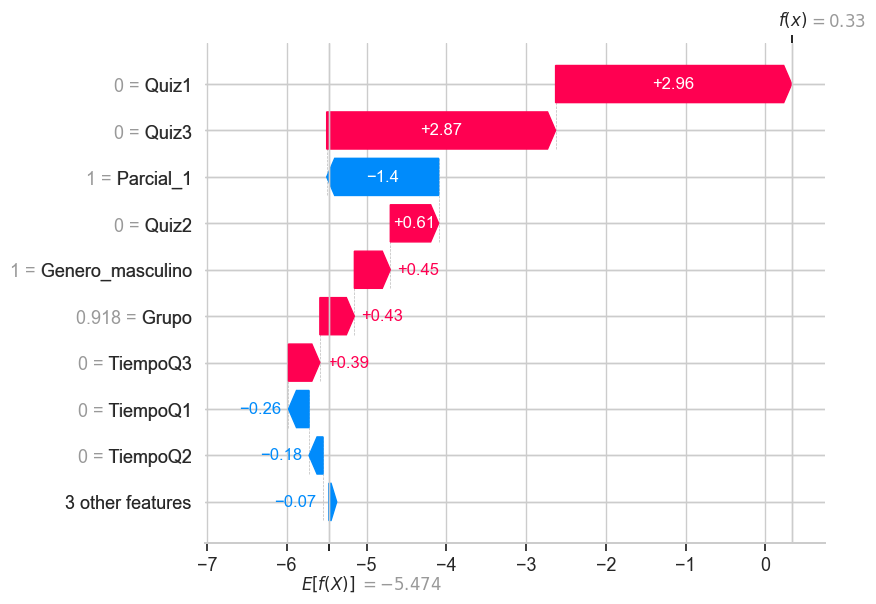

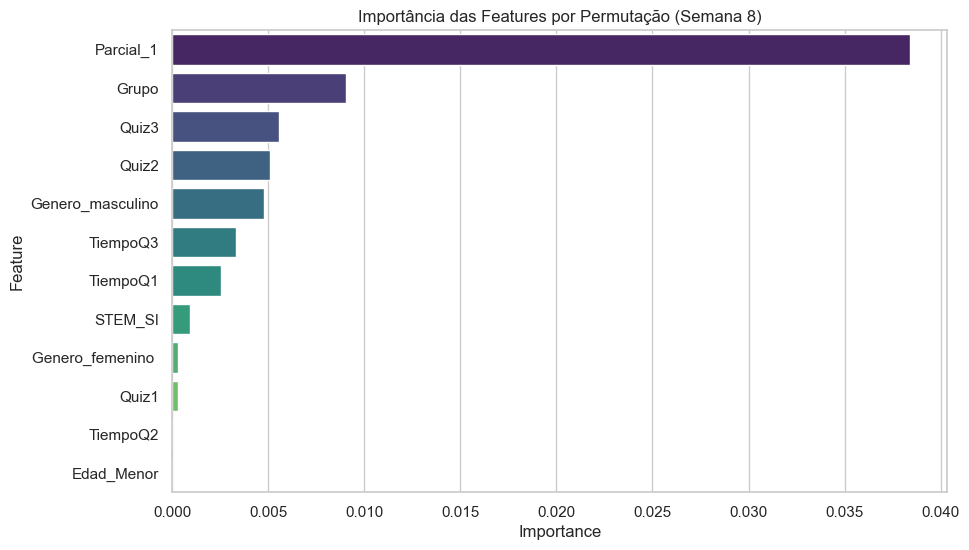

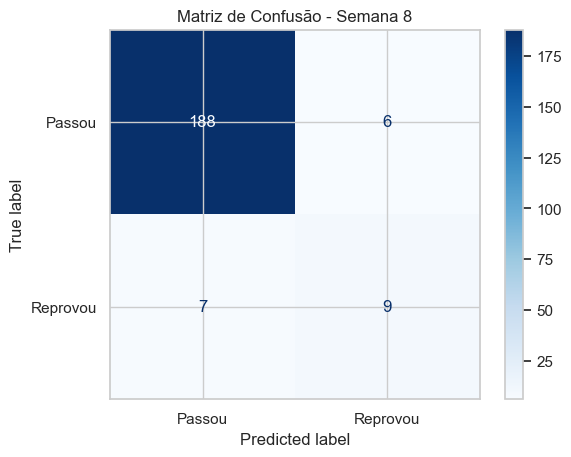


Relatório de classificação semana 8:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       194
           1       0.60      0.56      0.58        16

    accuracy                           0.94       210
   macro avg       0.78      0.77      0.77       210
weighted avg       0.94      0.94      0.94       210



In [52]:
# TESTES SEMANA 8
best_lda_model_w8 = LinearDiscriminantAnalysis()
best_lda_model_w8.fit(X_train_w8, y_train_w8)
print("Modelo LDA treinado com sucesso para a semana 8.")

#Adiciona o SHAP
explainer = shap.Explainer(best_lda_model_w8, X_train_w8)   # cria o explicador
shap_values = explainer(X_test_w8)            # gera os valores SHAP

y_train_w8_pred = best_lda_model_w8.predict(X_train_w8)
y_val_w8_pred = best_lda_model_w8.predict(X_val_w8)
y_test_w8_pred = best_lda_model_w8.predict(X_test_w8)

# Visualização do desempenho do modelo no terminal
print("Acurácia de Treinamento:", best_lda_model_w8.score(X_train_w8, y_train_w8))
print("Acurácia de Teste:", best_lda_model_w8.score(X_test_w8, y_test_w8))

print(f"Erro treino = {mean_squared_error(y_train_w8, y_train_w8_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val_w8, y_val_w8_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w8, y_test_w8_pred):.3f}")

# Gera a visualização gráfica da árvore de decisão
coef = pd.Series(best_lda_model_w8.coef_[0], index=X_week8.columns)

plt.figure(figsize=(10,6))
coef.sort_values().plot(kind='barh')
plt.title("Coeficientes das variáveis no LDA")
plt.show()

# Calcula importâncias
result = permutation_importance(best_lda_model_w8, X_test_w8, y_test_w8, n_repeats=30, random_state=42)

# SHAP summary plot
# INTERPRETAÇÃO GLOBAL

# Gráfico de barras com importância média das features
shap.summary_plot(shap_values, X_test_w8, plot_type="bar")

# Gráfico de pontos (importância + direção do efeito)
shap.summary_plot(shap_values, X_test_w8)

# INTERPRETAÇÃO LOCAL

# Escolhe uma instância específica do teste
i = 5  # por exemplo, a 5ª amostra do conjunto de teste

# Waterfall plot (explicação local da predição)
shap.plots.waterfall(shap_values[i])

# Force plot (explicação interativa – funciona melhor em Jupyter Notebook)
shap.plots.force(shap_values[i])

# Organiza em DataFrame
importances = result.importances_mean
features = X_train_w8.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Importância das Features por Permutação (Semana 8)")
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test_w8, best_lda_model_w8.predict(X_test_w8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Passou", "Reprovou"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - Semana 8")
plt.show()

print("\nRelatório de classificação semana 8:\n", classification_report(y_test_w8, y_test_w8_pred))

Semana 12

Modelo LDA treinado com sucesso para a semana 12.
Acurácia de Treinamento: 0.9528688524590164
Acurácia de Teste: 0.9571428571428572
Erro treino = 0.047
Erro validação = 0.057
Erro teste = 0.043


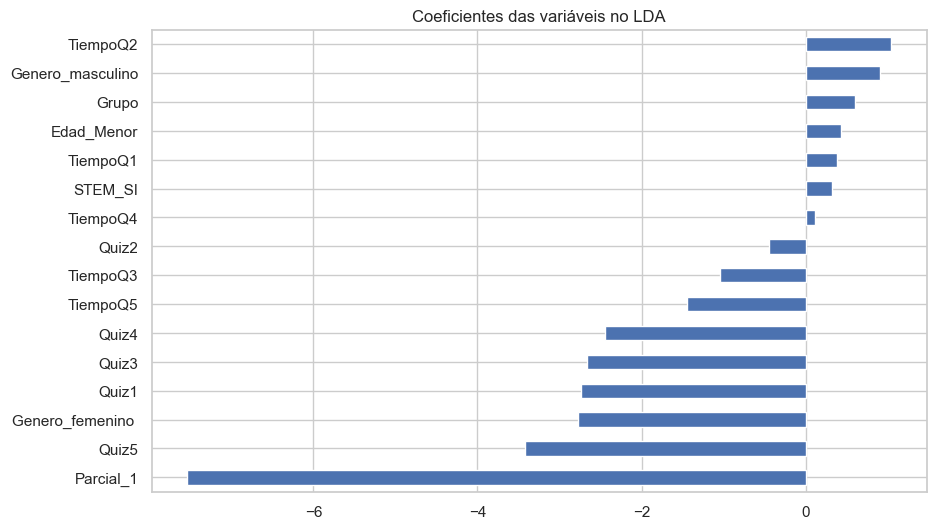

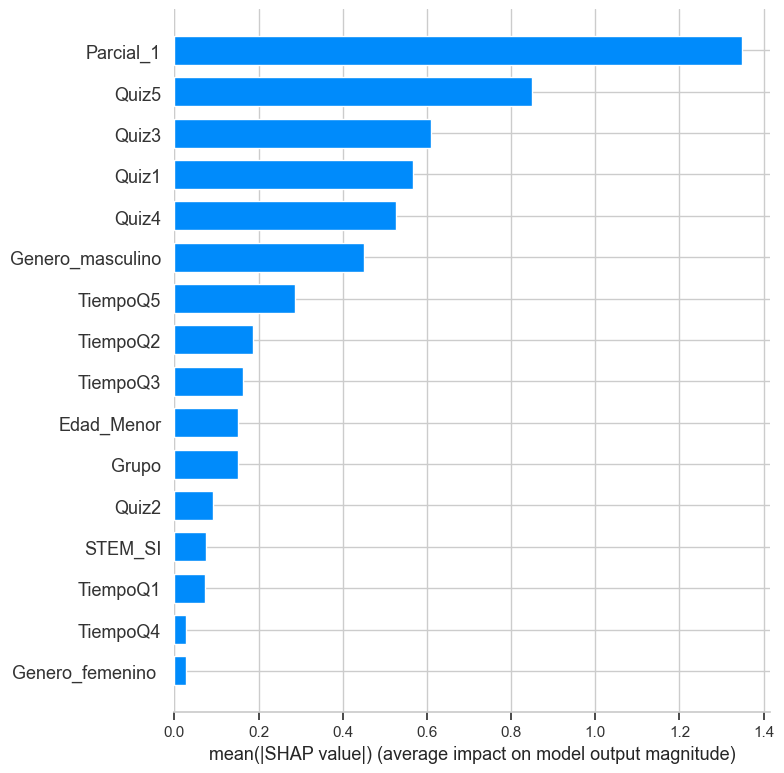

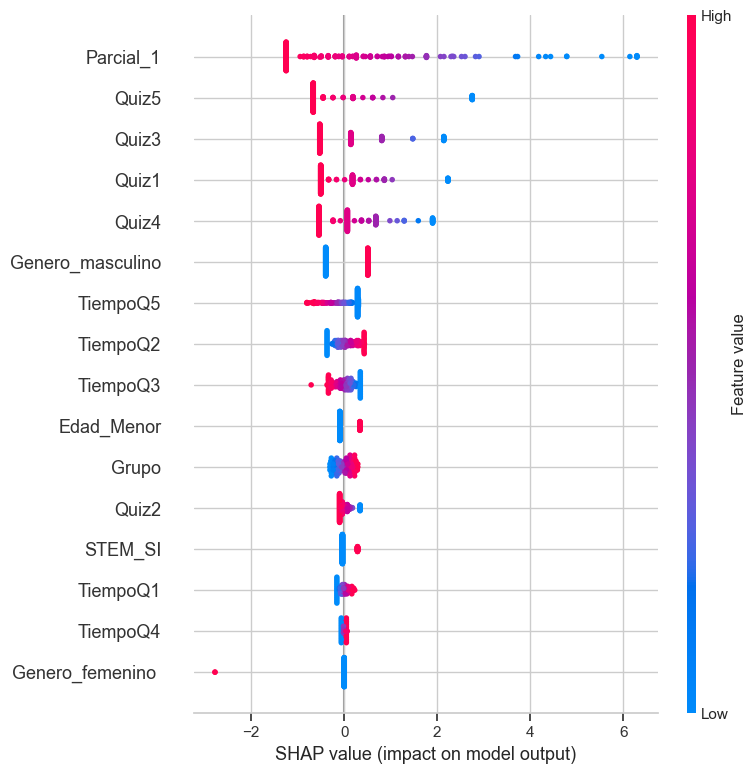

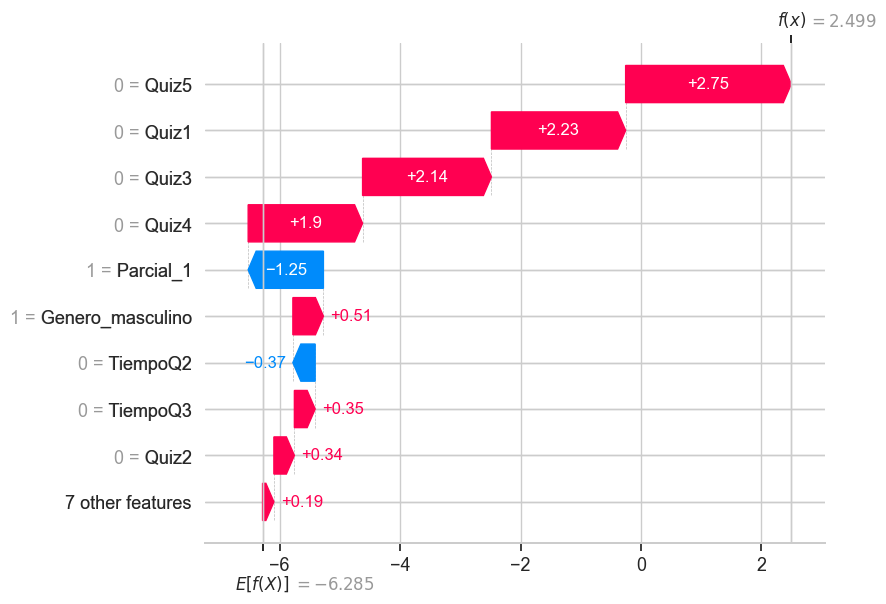

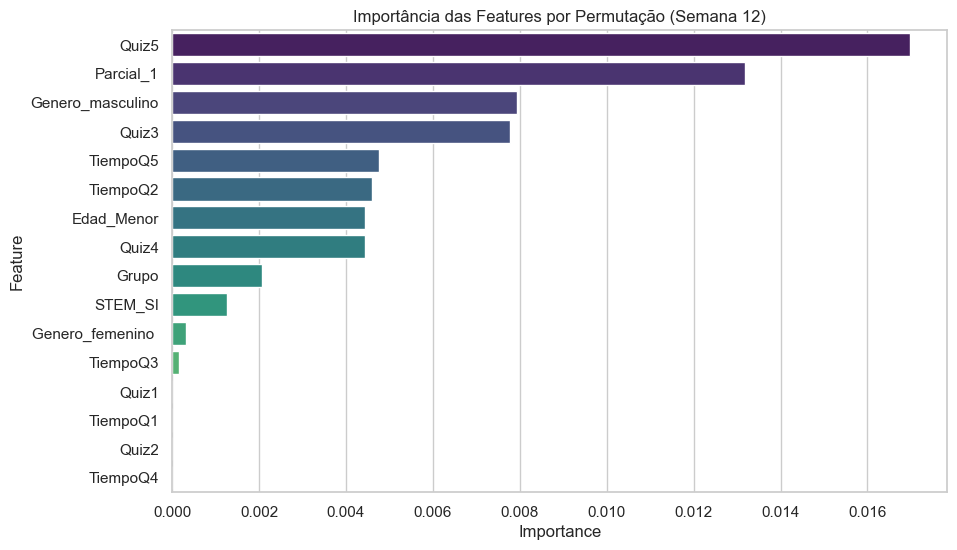

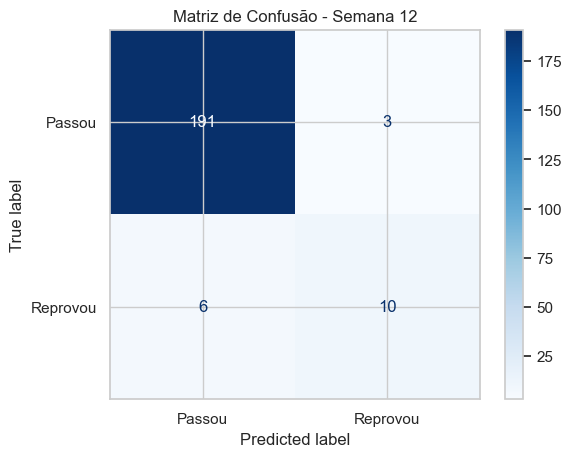


Relatório de classificação semana 12:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       194
           1       0.77      0.62      0.69        16

    accuracy                           0.96       210
   macro avg       0.87      0.80      0.83       210
weighted avg       0.95      0.96      0.96       210



In [53]:
# TESTES SEMANA 12
best_lda_model_w12 = LinearDiscriminantAnalysis()
best_lda_model_w12.fit(X_train_w12, y_train_w12)
print("Modelo LDA treinado com sucesso para a semana 12.")

#Adiciona o SHAP
explainer = shap.Explainer(best_lda_model_w12, X_train_w12)   # cria o explicador
shap_values = explainer(X_test_w12)            # gera os valores SHAP

y_train_w12_pred = best_lda_model_w12.predict(X_train_w12)
y_val_w12_pred = best_lda_model_w12.predict(X_val_w12)
y_test_w12_pred = best_lda_model_w12.predict(X_test_w12)

# Visualização do desempenho do modelo no terminal
print("Acurácia de Treinamento:", best_lda_model_w12.score(X_train_w12, y_train_w12))
print("Acurácia de Teste:", best_lda_model_w12.score(X_test_w12, y_test_w12))

print(f"Erro treino = {mean_squared_error(y_train_w12, y_train_w12_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val_w12, y_val_w12_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w12, y_test_w12_pred):.3f}")

# Gera a visualização gráfica da árvore de decisão
coef = pd.Series(best_lda_model_w12.coef_[0], index=X_week12.columns)

plt.figure(figsize=(10,6))
coef.sort_values().plot(kind='barh')
plt.title("Coeficientes das variáveis no LDA")
plt.show()

# Calcula importâncias
result = permutation_importance(best_lda_model_w12, X_test_w12, y_test_w12, n_repeats=30, random_state=42)

# SHAP summary plot
# INTERPRETAÇÃO GLOBAL

# Gráfico de barras com importância média das features
shap.summary_plot(shap_values, X_test_w12, plot_type="bar")

# Gráfico de pontos (importância + direção do efeito)
shap.summary_plot(shap_values, X_test_w12)

# INTERPRETAÇÃO LOCAL

# Escolhe uma instância específica do teste
i = 5  # por exemplo, a 5ª amostra do conjunto de teste

# Waterfall plot (explicação local da predição)
shap.plots.waterfall(shap_values[i])

# Force plot (explicação interativa – funciona melhor em Jupyter Notebook)
shap.plots.force(shap_values[i])

# Organiza em DataFrame
importances = result.importances_mean
features = X_train_w12.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Importância das Features por Permutação (Semana 12)")
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test_w12, best_lda_model_w12.predict(X_test_w12))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Passou", "Reprovou"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - Semana 12")
plt.show()

print("\nRelatório de classificação semana 12:\n", classification_report(y_test_w12, y_test_w12_pred))

Semana 15

Modelo LDA treinado com sucesso para a semana 15.
Acurácia de Treinamento: 0.9713114754098361
Acurácia de Teste: 0.9761904761904762
Erro treino = 0.029
Erro validação = 0.029
Erro teste = 0.024


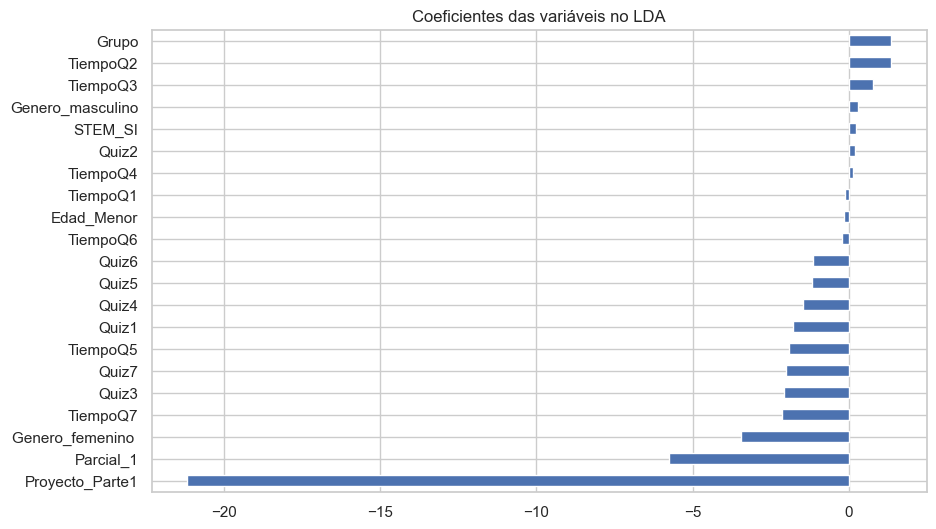

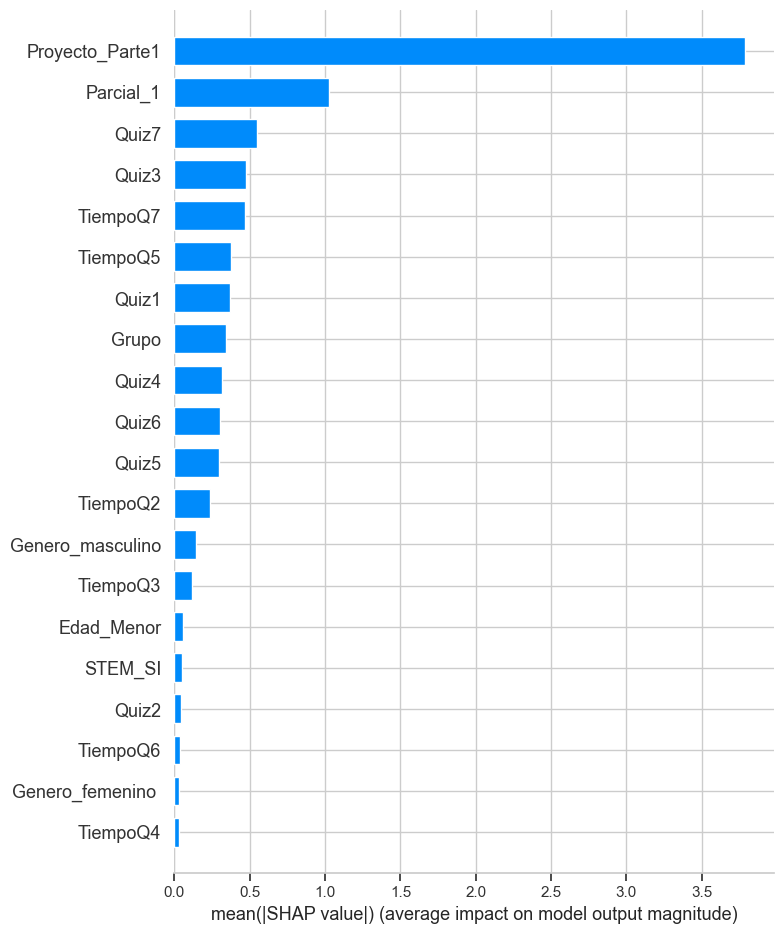

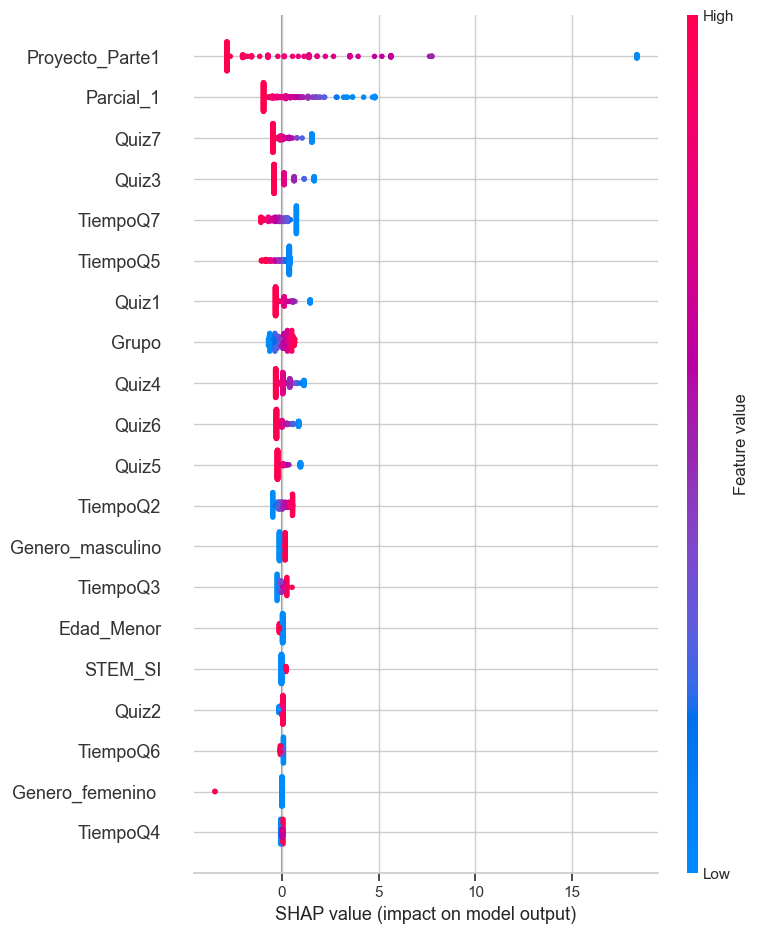

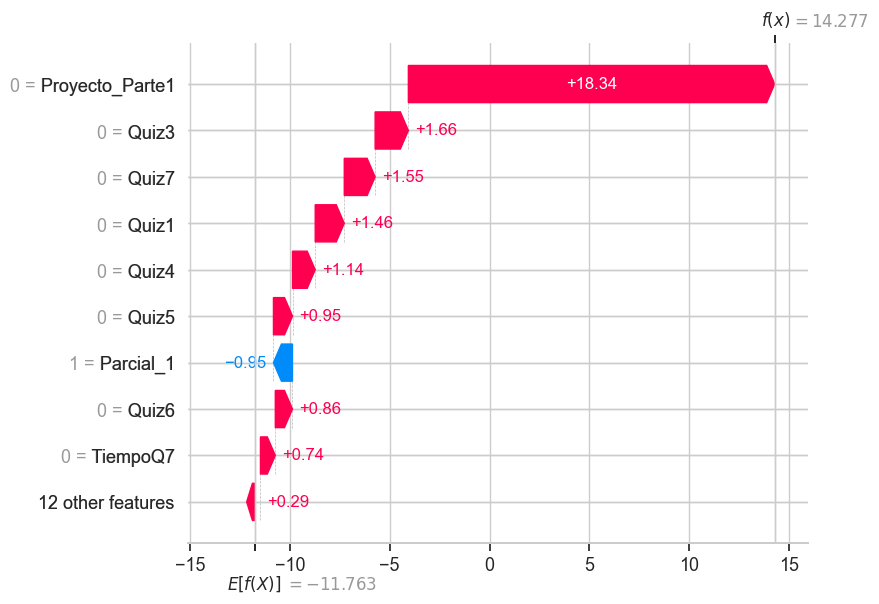

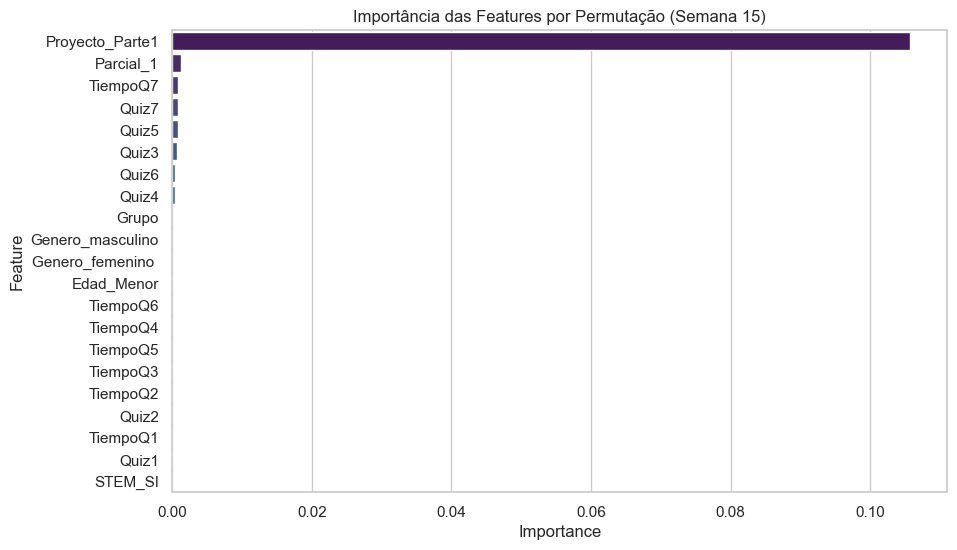

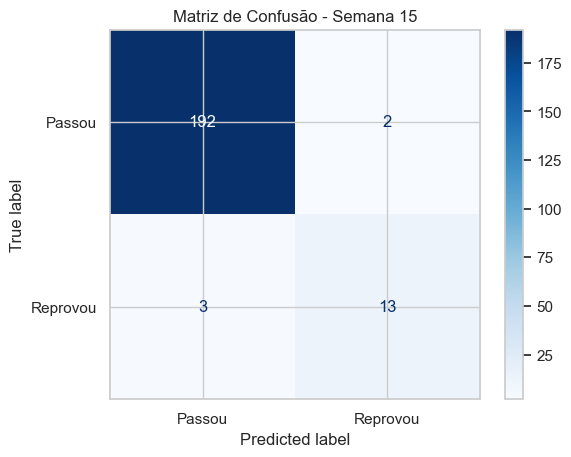


Relatório de classificação semana 15:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       194
           1       0.87      0.81      0.84        16

    accuracy                           0.98       210
   macro avg       0.93      0.90      0.91       210
weighted avg       0.98      0.98      0.98       210



In [54]:
# TESTES SEMANA 15

best_lda_model_w15 = LinearDiscriminantAnalysis()
best_lda_model_w15.fit(X_train_w15, y_train_w15)
print("Modelo LDA treinado com sucesso para a semana 15.")

#Adiciona o SHAP
explainer = shap.Explainer(best_lda_model_w15, X_train_w15)   # cria o explicador
shap_values = explainer(X_test_w15)            # gera os valores SHAP

y_train_w15_pred = best_lda_model_w15.predict(X_train_w15)
y_val_w15_pred = best_lda_model_w15.predict(X_val_w15)
y_test_w15_pred = best_lda_model_w15.predict(X_test_w15)

# Visualização do desempenho do modelo no terminal
print("Acurácia de Treinamento:", best_lda_model_w15.score(X_train_w15, y_train_w15))
print("Acurácia de Teste:", best_lda_model_w15.score(X_test_w15, y_test_w15))

print(f"Erro treino = {mean_squared_error(y_train_w15, y_train_w15_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val_w15, y_val_w15_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w15, y_test_w15_pred):.3f}")

# Gera a visualização gráfica da árvore de decisão
coef = pd.Series(best_lda_model_w15.coef_[0], index=X_week15.columns)

plt.figure(figsize=(10,6))
coef.sort_values().plot(kind='barh')
plt.title("Coeficientes das variáveis no LDA")
plt.show()

# Calcula importâncias
result = permutation_importance(best_lda_model_w15, X_test_w15, y_test_w15, n_repeats=30, random_state=42)

# SHAP summary plot
# INTERPRETAÇÃO GLOBAL

# Gráfico de barras com importância média das features
shap.summary_plot(shap_values, X_test_w15, plot_type="bar")

# Gráfico de pontos (importância + direção do efeito)
shap.summary_plot(shap_values, X_test_w15)

# INTERPRETAÇÃO LOCAL

# Escolhe uma instância específica do teste
i = 5  # por exemplo, a 5ª amostra do conjunto de teste

# Waterfall plot (explicação local da predição)
shap.plots.waterfall(shap_values[i])

# Force plot (explicação interativa – funciona melhor em Jupyter Notebook)
shap.plots.force(shap_values[i])

# Organiza em DataFrame
importances = result.importances_mean
features = X_train_w15.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Importância das Features por Permutação (Semana 15)")
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test_w15, best_lda_model_w15.predict(X_test_w15))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Passou", "Reprovou"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - Semana 15")
plt.show()

print("\nRelatório de classificação semana 15:\n", classification_report(y_test_w15, y_test_w15_pred))

# 12. Random Forest

Configuração do GridSearch

In [55]:
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [10, 20],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)
grid_search_rf = hyperparameters_tuning(estimator=rf, param_grid=param_grid, scoring='recall', n_jobs=-1, cv=5, verbose=1)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Resultados do GridSearch para week4
Melhores hiperparâmetros: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 500}
Melhor score de validação: 0.9252200837836198
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Resultados do GridSearch para week8
Melhores hiperparâmetros: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 300}
Melhor score de validação: 0.9681136543014996
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Resultados do GridSearch para week12
Melhores hiperparâmetros: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 500}
Melhor score de validação: 0.9912087912087912
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Resultados do GridSearch para week15
Melhores hiperparâmetros: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 500}
Melhor score de validaç

### Semana 4

Modelo Random Forest treinado com sucesso para a semana 4.
Acurácia de Treinamento: 0.9456967213114754
Acurácia de Teste: 0.8666666666666667
Erro treino = 0.054
Erro validação = 0.129
Erro teste = 0.133


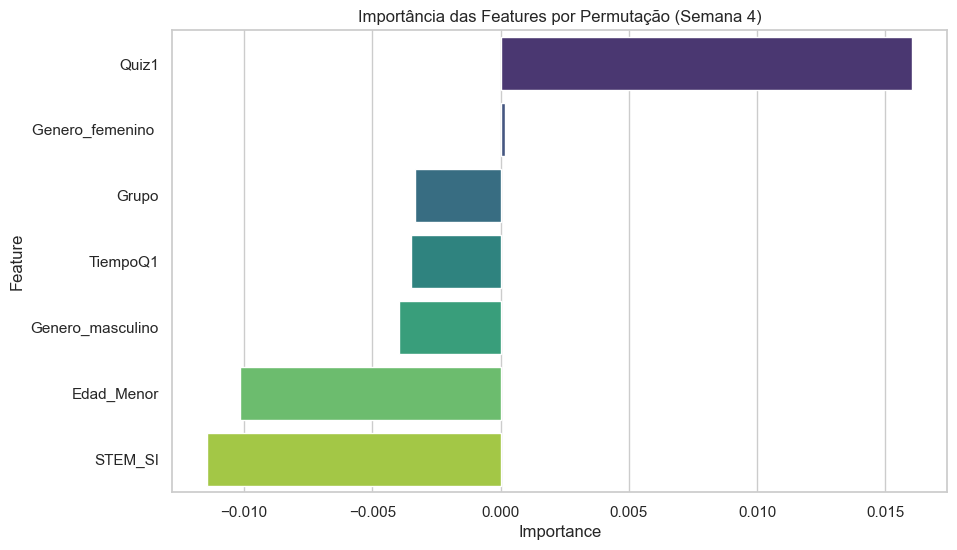

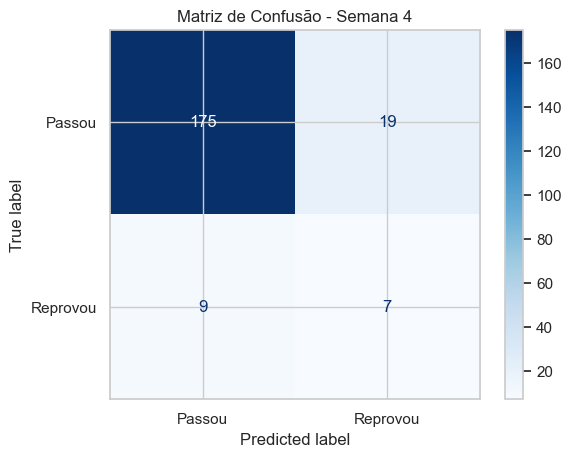


Matriz de confusão semana 4:
 [[175  19]
 [  9   7]]

Relatório de classificação semana 4:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93       194
           1       0.27      0.44      0.33        16

    accuracy                           0.87       210
   macro avg       0.61      0.67      0.63       210
weighted avg       0.90      0.87      0.88       210



In [56]:
# TESTES SEMANA 4
print("Modelo Random Forest treinado com sucesso para a semana 4.")

best_rf_model_w4 = grid_search_rf['week4']
y_train_w4_pred = best_rf_model_w4.predict(X_train_w4)
y_val_w4_pred = best_rf_model_w4.predict(X_val_w4)
y_test_w4_pred = best_rf_model_w4.predict(X_test_w4)

# Visualização do desempenho do modelo no terminal
print("Acurácia de Treinamento:", best_rf_model_w4.score(X_train_w4, y_train_w4))
print("Acurácia de Teste:", best_rf_model_w4.score(X_test_w4, y_test_w4))

print(f"Erro treino = {mean_squared_error(y_train_w4, y_train_w4_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val_w4, y_val_w4_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w4, y_test_w4_pred):.3f}")

# Gera a visualização gráfica da árvore de decisão
if hasattr(best_model_w4, 'feature_importances_'):
  coef = pd.Series(best_rf_model_w4.feature_importances_, index=X_week4.columns)
  plt.figure(figsize=(10,6))
  coef.sort_values().plot(kind='barh', color="skyblue")
  plt.title("Coeficientes das variáveis no Random Forest")
  plt.show()

# Calcula importâncias
result = permutation_importance(best_rf_model_w4, X_test_w4, y_test_w4, n_repeats=30, random_state=42)

# Organiza em DataFrame
importances = result.importances_mean
features = X_week4.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Importância das Features por Permutação (Semana 4)")
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test_w4, best_rf_model_w4.predict(X_test_w4))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Passou", "Reprovou"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - Semana 4")
plt.show()

print("\nMatriz de confusão semana 4:\n", confusion_matrix(y_test_w4, y_test_w4_pred))
print("\nRelatório de classificação semana 4:\n", classification_report(y_test_w4, y_test_w4_pred))


### Semana 8

Acurácia de Treinamento: 0.9979508196721312
Acurácia de Teste: 0.919047619047619
Erro treino = 0.002
Erro validação = 0.091
Erro teste = 0.081


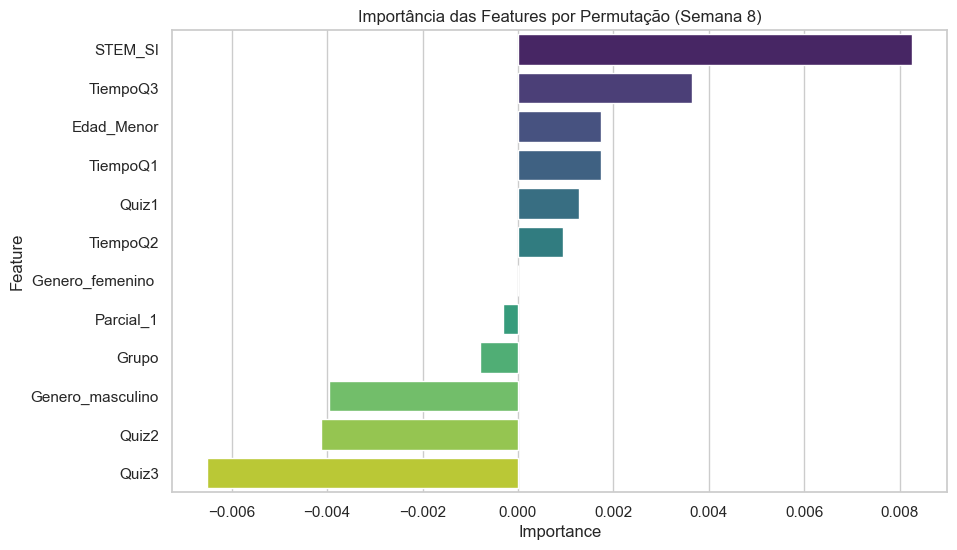

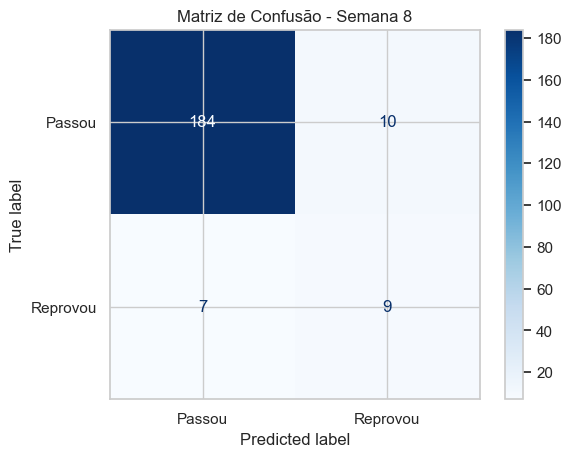


Relatório de classificação semana 8:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       194
           1       0.47      0.56      0.51        16

    accuracy                           0.92       210
   macro avg       0.72      0.76      0.74       210
weighted avg       0.93      0.92      0.92       210



In [57]:
# TESTES SEMANA 8
best_rf_model_w8 = grid_search_rf['week8']

y_train_w8_pred = best_rf_model_w8.predict(X_train_w8)
y_val_w8_pred = best_rf_model_w8.predict(X_val_w8)
y_test_w8_pred = best_rf_model_w8.predict(X_test_w8)

# Visualização do desempenho do modelo no terminal
print("Acurácia de Treinamento:", best_rf_model_w8.score(X_train_w8, y_train_w8))
print("Acurácia de Teste:", best_rf_model_w8.score(X_test_w8, y_test_w8))

print(f"Erro treino = {mean_squared_error(y_train_w8, y_train_w8_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val_w8, y_val_w8_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w8, y_test_w8_pred):.3f}")

# Gera a visualização gráfica da árvore de decisão
if hasattr(best_model_w4, 'feature_importances_'):
  coef = pd.Series(best_rf_model_w8.feature_importances_, index=X_week8.columns)
  plt.figure(figsize=(10,6))
  coef.sort_values().plot(kind='barh', color="skyblue")
  plt.title("Coeficientes das variáveis no Random Forest")
  plt.show()

# Calcula importâncias
result = permutation_importance(best_rf_model_w8, X_test_w8, y_test_w8, n_repeats=30, random_state=42)

# Organiza em DataFrame
importances = result.importances_mean
features = X_train_w8.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Importância das Features por Permutação (Semana 8)")
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test_w8, best_rf_model_w8.predict(X_test_w8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Passou", "Reprovou"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - Semana 8")
plt.show()

print("\nRelatório de classificação semana 8:\n", classification_report(y_test_w8, y_test_w8_pred))


### Semana 12

Acurácia de Treinamento: 1.0
Acurácia de Teste: 0.9571428571428572
Erro treino = 0.000
Erro validação = 0.091
Erro teste = 0.043


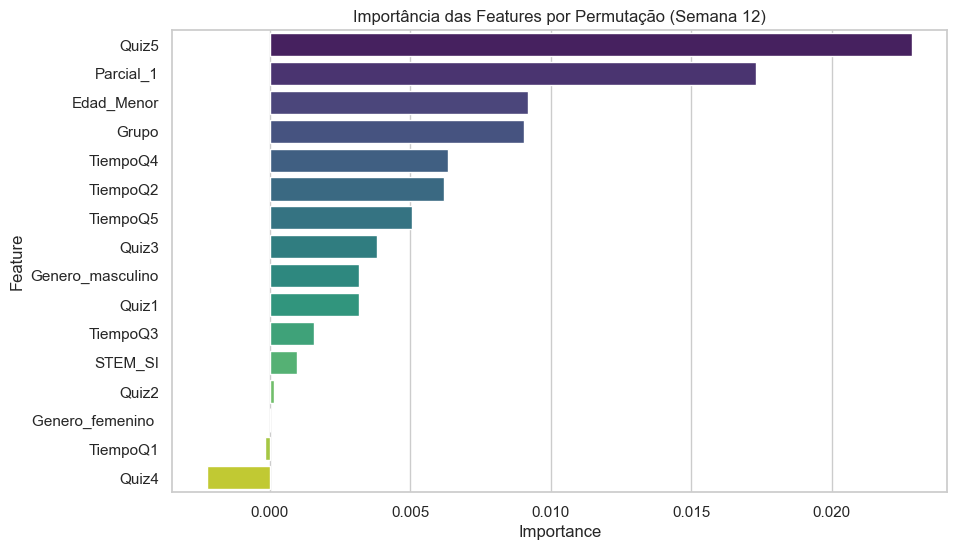

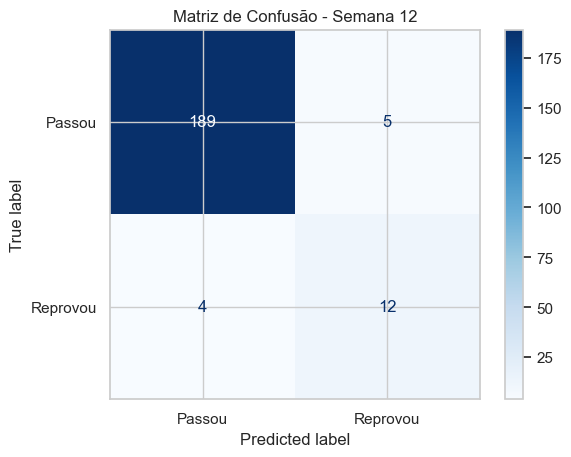


Relatório de classificação semana 12:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       194
           1       0.71      0.75      0.73        16

    accuracy                           0.96       210
   macro avg       0.84      0.86      0.85       210
weighted avg       0.96      0.96      0.96       210



In [58]:
# TESTES SEMANA 12
best_rf_model_w12 = grid_search_rf['week12']

y_train_w12_pred = best_rf_model_w12.predict(X_train_w12)
y_val_pred = best_rf_model_w12.predict(X_val_w12)
y_test_w12_pred = best_rf_model_w12.predict(X_test_w12)

# Visualização do desempenho do modelo no terminal
print("Acurácia de Treinamento:", best_rf_model_w12.score(X_train_w12, y_train_w12))
print("Acurácia de Teste:", best_rf_model_w12.score(X_test_w12, y_test_w12))

print(f"Erro treino = {mean_squared_error(y_train_w12, y_train_w12_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val, y_val_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w12, y_test_w12_pred):.3f}")

# Gera a visualização gráfica da árvore de decisão
if hasattr(best_model_w4, 'feature_importances_'):
  coef = pd.Series(best_rf_model_w12.feature_importances_, index=X_week12.columns)
  plt.figure(figsize=(10,6))
  coef.sort_values().plot(kind='barh', color="skyblue")
  plt.title("Coeficientes das variáveis no Random Forest")
  plt.show()

# Calcula importâncias
result = permutation_importance(best_rf_model_w12, X_test_w12, y_test_w12, n_repeats=30, random_state=42)

# Organiza em DataFrame
importances = result.importances_mean
features = X_train_w12.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Importância das Features por Permutação (Semana 12)")
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test_w12, best_rf_model_w12.predict(X_test_w12))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Passou", "Reprovou"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - Semana 12")
plt.show()

print("\nRelatório de classificação semana 12:\n", classification_report(y_test_w12, y_test_w12_pred))


### Semana 15

Acurácia de Treinamento: 1.0
Acurácia de Teste: 0.9761904761904762
Erro treino = 0.000
Erro validação = 0.024
Erro teste = 0.024


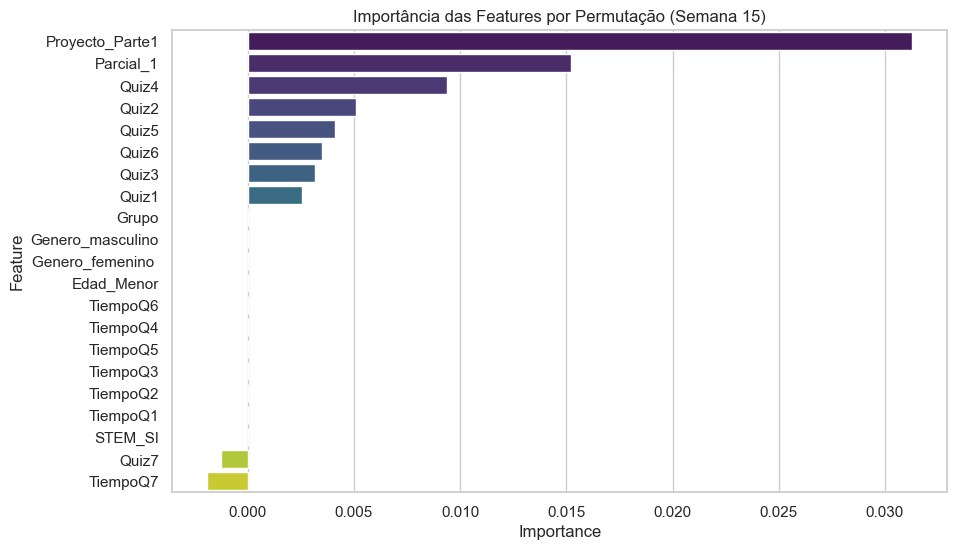

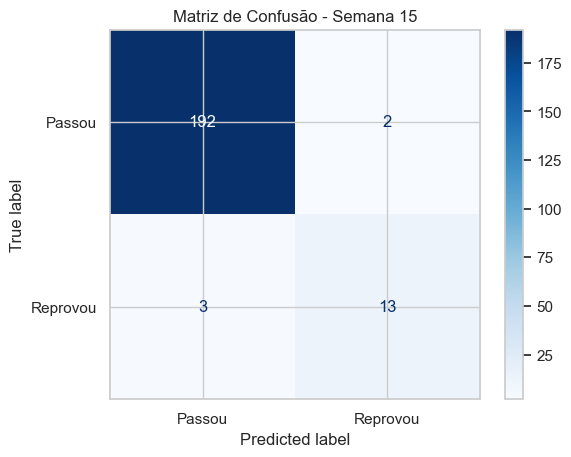


Relatório de classificação semana 15:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       194
           1       0.87      0.81      0.84        16

    accuracy                           0.98       210
   macro avg       0.93      0.90      0.91       210
weighted avg       0.98      0.98      0.98       210



In [59]:
# TESTES SEMANA 15
best_rf_model_w15 = grid_search_rf['week15']

y_train_pred = best_rf_model_w15.predict(X_train_w15)
y_val_pred = best_rf_model_w15.predict(X_val_w15)
y_test_w15_pred = best_rf_model_w15.predict(X_test_w15)

# Visualização do desempenho do modelo no terminal
print("Acurácia de Treinamento:", best_rf_model_w15.score(X_train_w15, y_train))
print("Acurácia de Teste:", best_rf_model_w15.score(X_test_w15, y_test_w15))

print(f"Erro treino = {mean_squared_error(y_train, y_train_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val, y_val_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w15, y_test_w15_pred):.3f}")

# Gera a visualização gráfica da árvore de decisão
if hasattr(best_model_w4, 'feature_importances_'):
  coef = pd.Series(best_rf_model_w15.feature_importances_, index=X_week15.columns)
  plt.figure(figsize=(10,6))
  coef.sort_values().plot(kind='barh', color="skyblue")
  plt.title("Coeficientes das variáveis no Random Forest")
  plt.show()

# Calcula importâncias
result = permutation_importance(best_rf_model_w15, X_test_w15, y_test_w15, n_repeats=30, random_state=42)

# Organiza em DataFrame
importances = result.importances_mean
features = X_train_w15.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Importância das Features por Permutação (Semana 15)")
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test_w15, best_rf_model_w15.predict(X_test_w15))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Passou", "Reprovou"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - Semana 15")
plt.show()

print("\nRelatório de classificação semana 15:\n", classification_report(y_test_w15, y_test_w15_pred))


# 13. AdaBoost

In [60]:
#Adaboost
from sklearn.ensemble import AdaBoostClassifier

# Estimador base
tree = DecisionTreeClassifier(max_depth=2, random_state=42)


Preparação do GridSearch

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Resultados do GridSearch para week4
Melhores hiperparâmetros: {'estimator__max_depth': 3, 'learning_rate': 1.0, 'n_estimators': 200}
Melhor score de validação: 0.9131050767414404


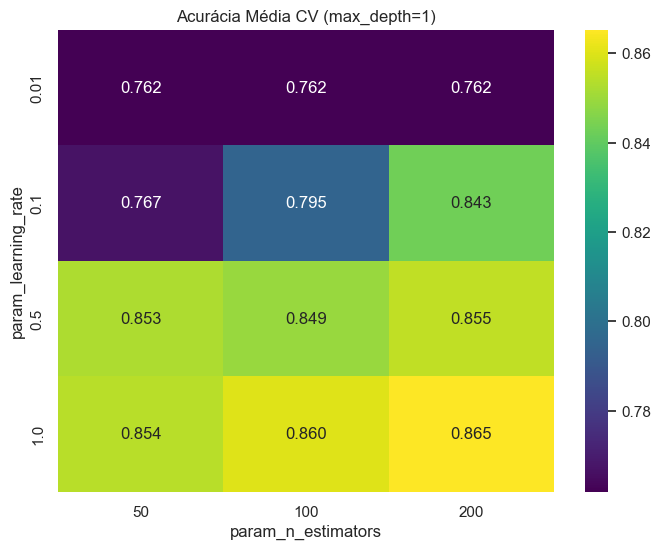

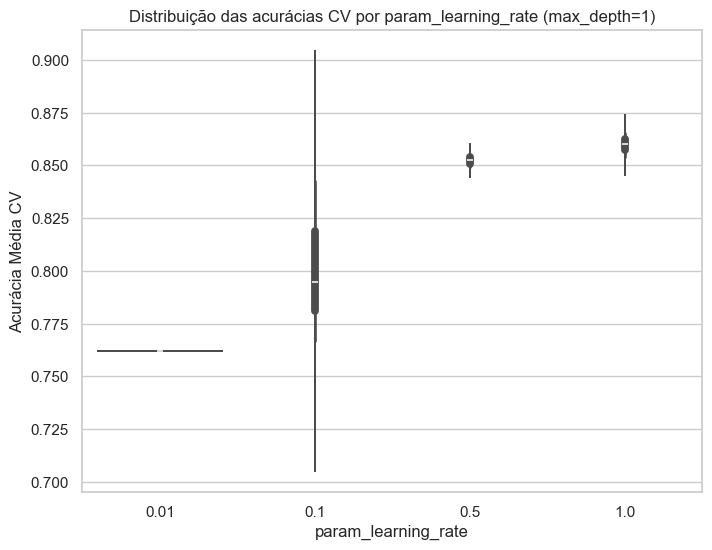

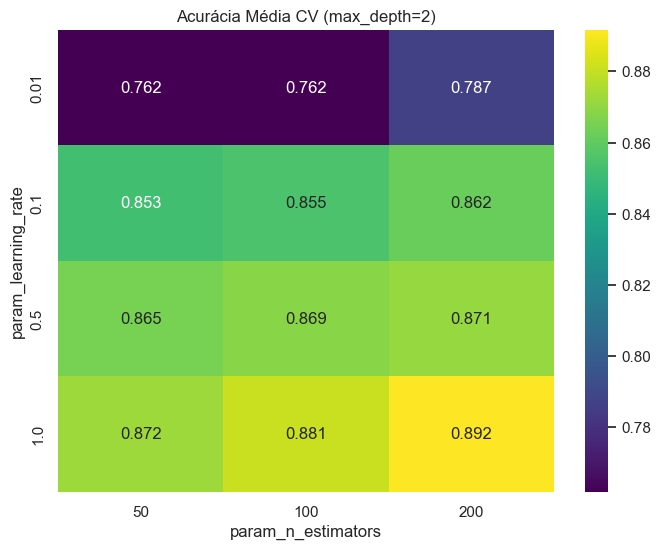

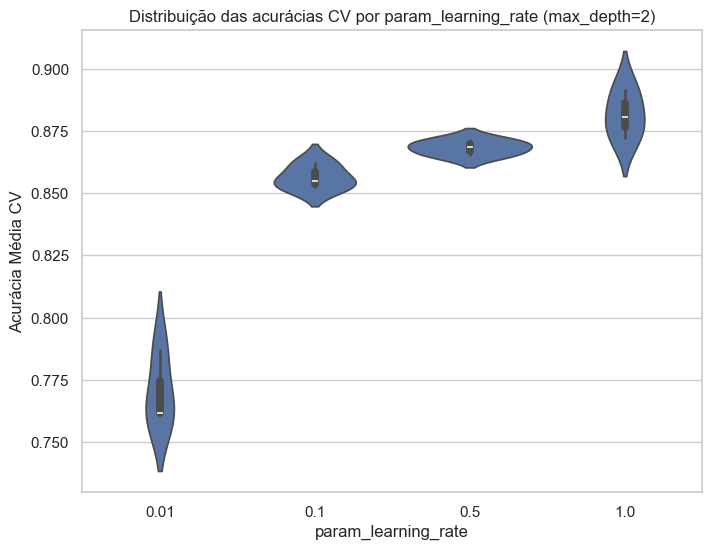

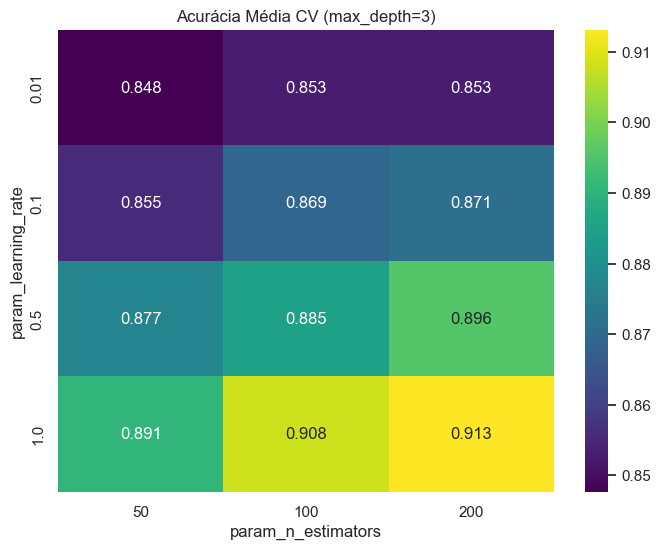

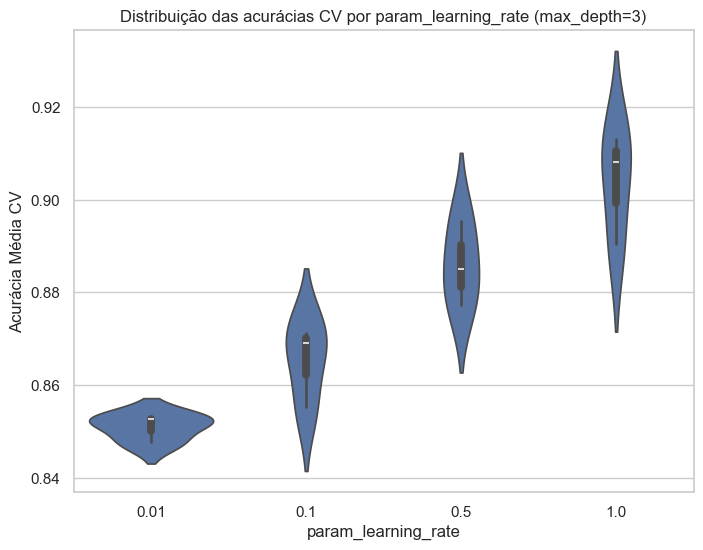

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Resultados do GridSearch para week8
Melhores hiperparâmetros: {'estimator__max_depth': 3, 'learning_rate': 1.0, 'n_estimators': 200}
Melhor score de validação: 0.9664608119153574


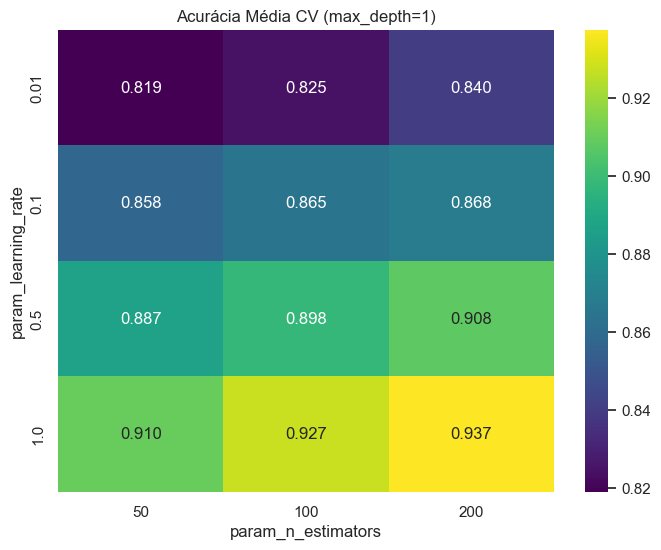

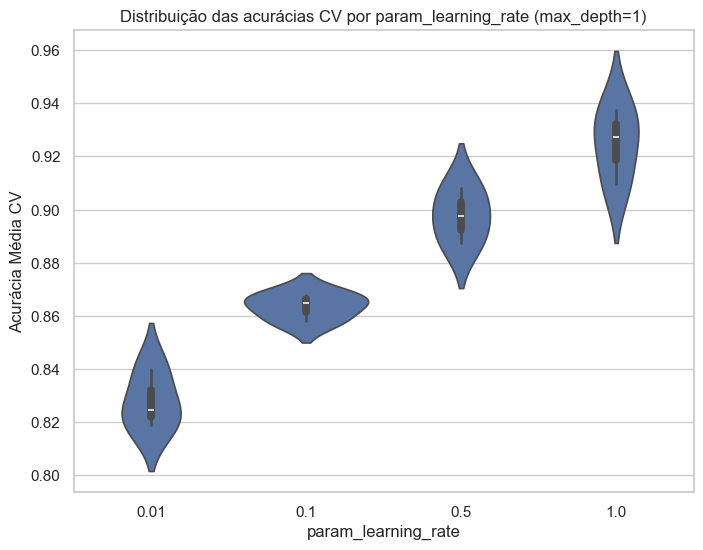

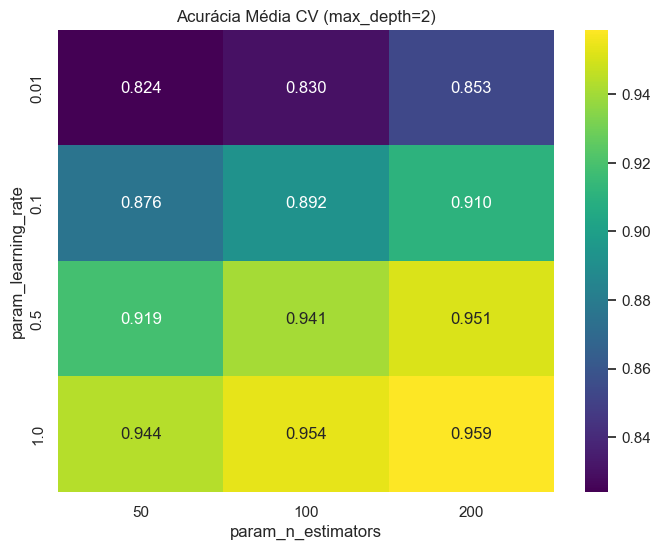

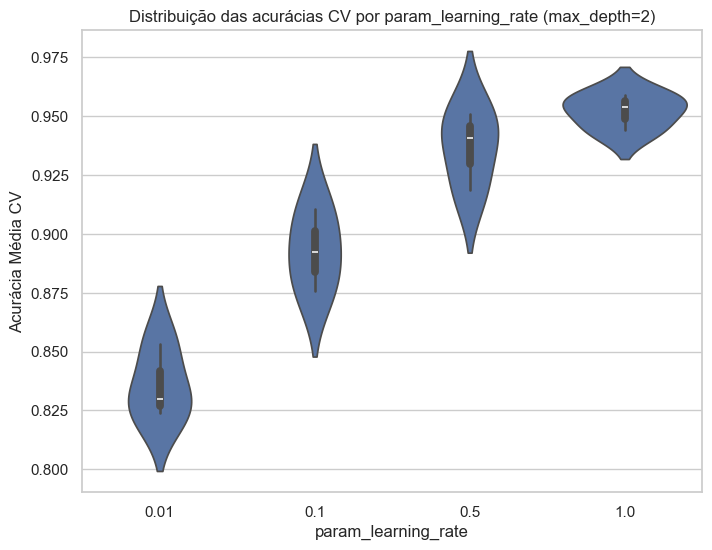

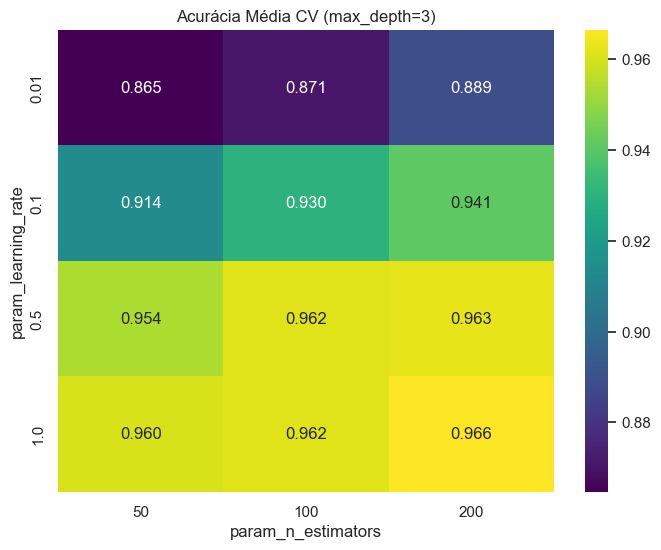

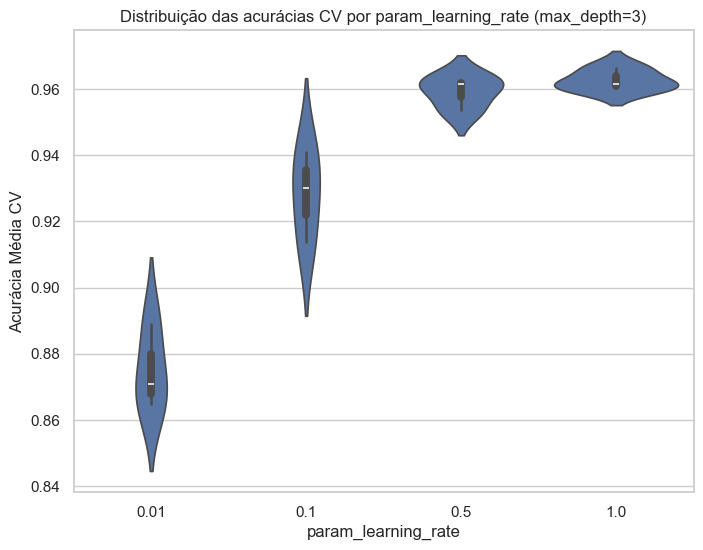

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Resultados do GridSearch para week12
Melhores hiperparâmetros: {'estimator__max_depth': 3, 'learning_rate': 1.0, 'n_estimators': 200}
Melhor score de validação: 0.9697590288499379


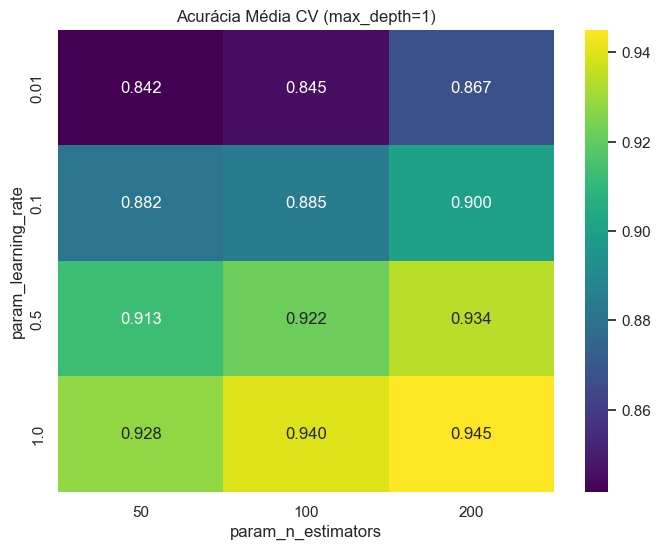

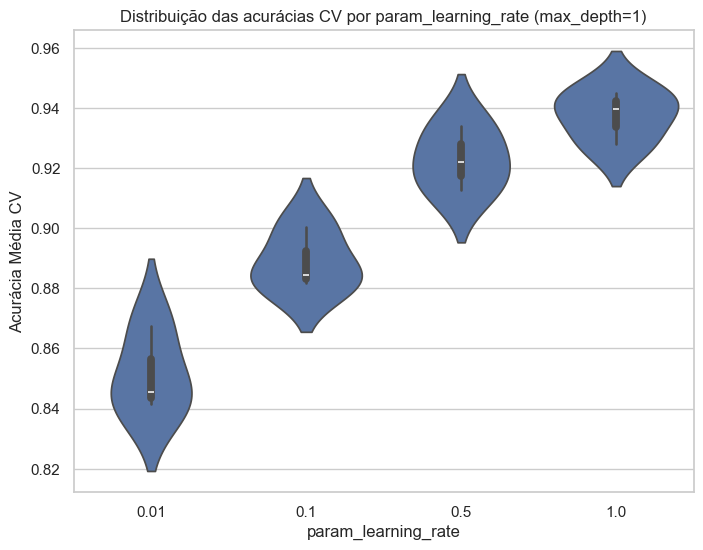

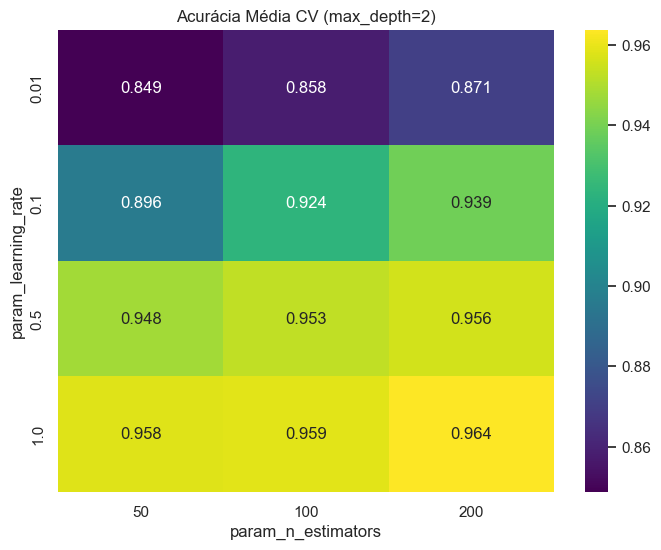

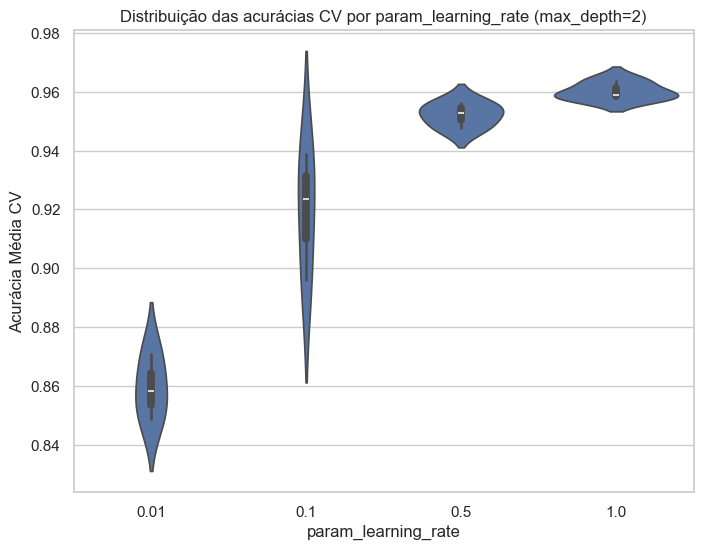

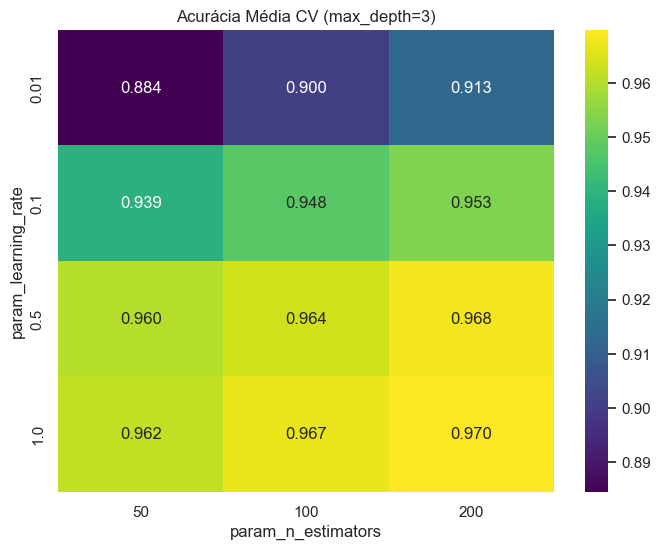

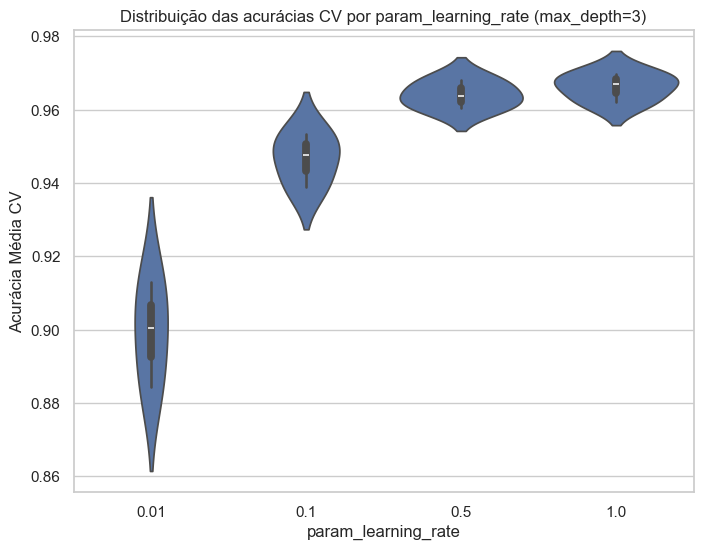

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Resultados do GridSearch para week15
Melhores hiperparâmetros: {'estimator__max_depth': 3, 'learning_rate': 1.0, 'n_estimators': 200}
Melhor score de validação: 0.991747646293101


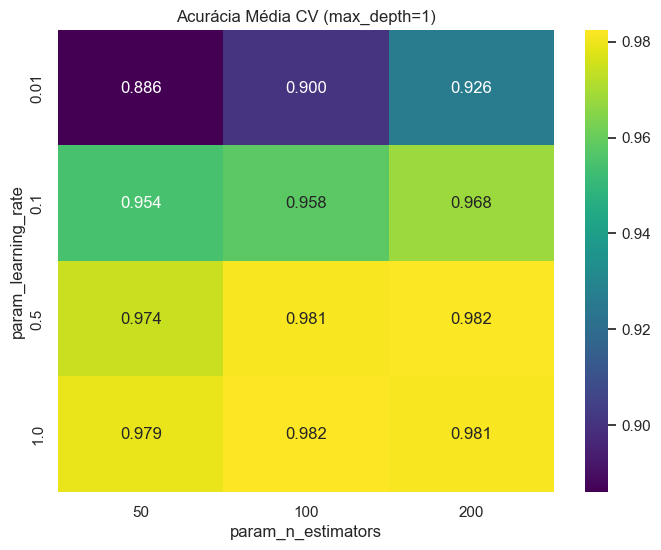

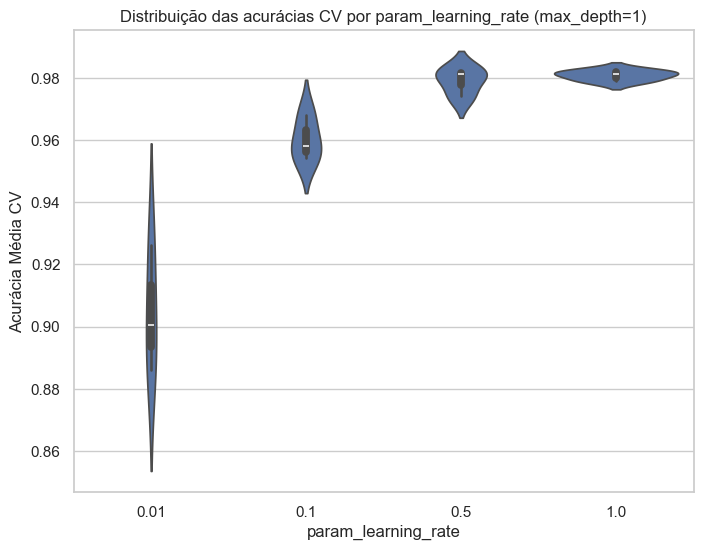

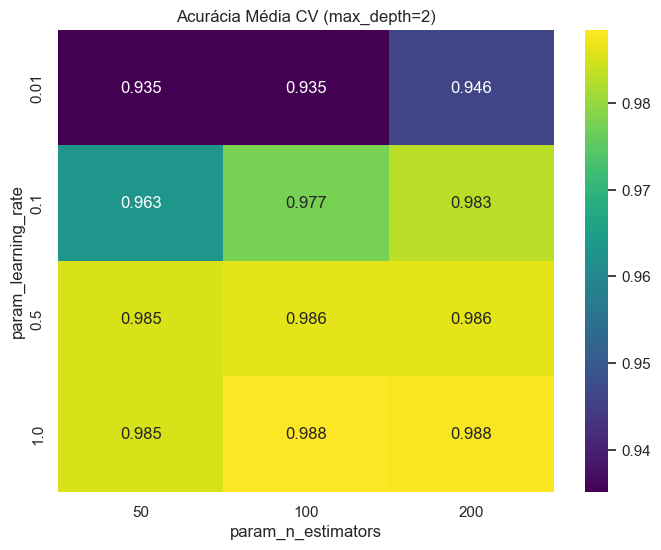

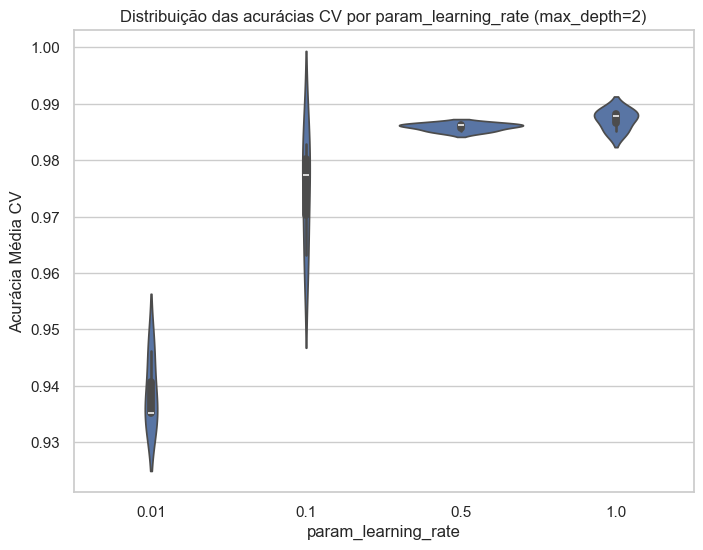

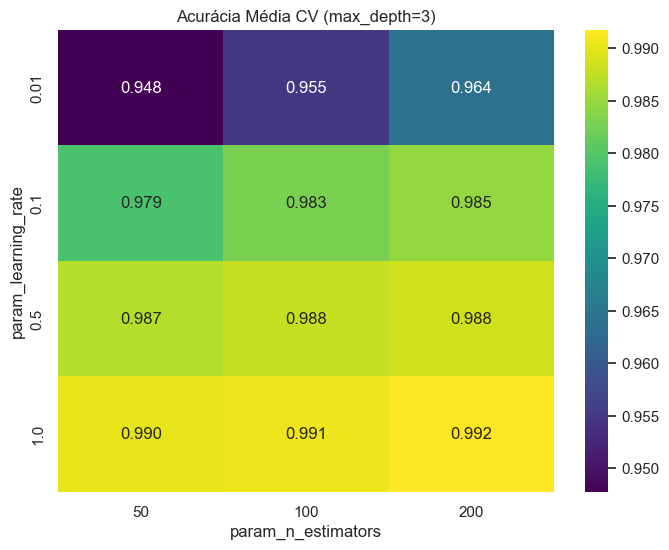

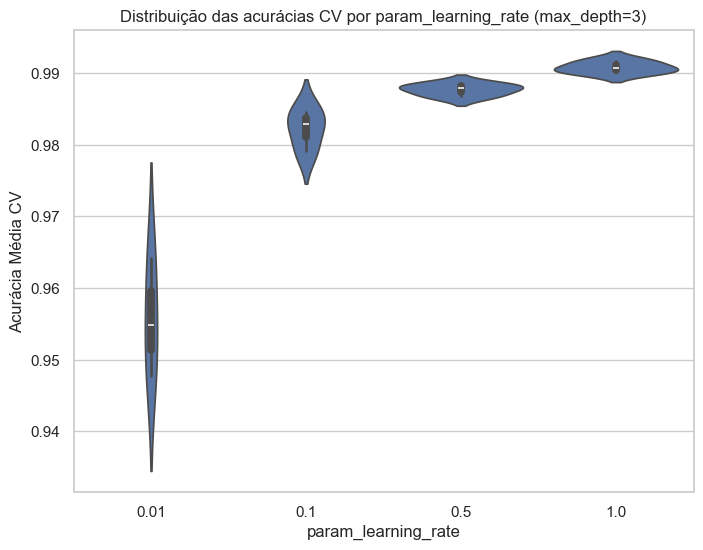

In [61]:
# Montando Gridsearch (AdaBoost)
ada = AdaBoostClassifier(
    estimator=tree,
    random_state=42
)

# Hiperparâmetros para testar
param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.5, 1.0],
    "estimator__max_depth": [1, 2, 3]
}

# Rodando o GridSearchCV
grid_search = hyperparameters_tuning(
    estimator=ada,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",   
    n_jobs=-1, 
    verbose=1, 
    show_plots=True   
)


Acurácia: 0.8857142857142857

Relatório de Classificação da Semana 4:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       194
           1       0.30      0.38      0.33        16

    accuracy                           0.89       210
   macro avg       0.62      0.65      0.64       210
weighted avg       0.90      0.89      0.89       210

Erro treino = 0.053
Erro validação = 0.110
Erro teste = 0.114

MATRIZ DE CONFUSÃO - TESTE - SEMANA 4
[[180  14]
 [ 10   6]]


<Figure size 800x600 with 0 Axes>

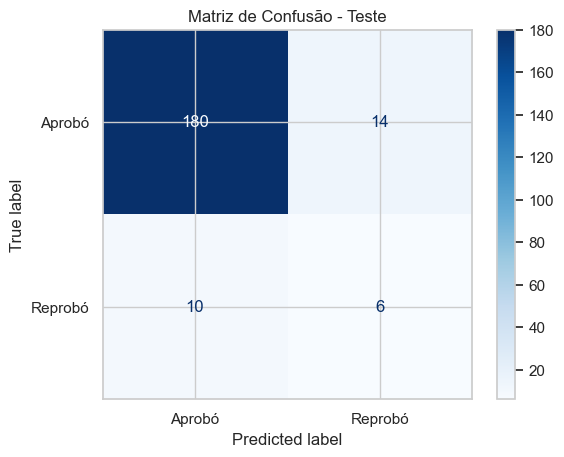

In [62]:
# Semana 4

best_ab_model_w4 = grid_search['week4']
# Faz as previsões
y_pred = best_ab_model_w4.predict(X_test_w4)

print("Acurácia:", accuracy_score(y_test_w4, y_pred))
print("\nRelatório de Classificação da Semana 4:\n", classification_report(y_test_w4, y_pred))

# Verificando Overfitting e Underfitting
print(f"Erro treino = {mean_squared_error(y_train_w4, best_ab_model_w4.predict(X_train_w4)):.3f}")
print(f"Erro validação = {mean_squared_error(y_val, best_ab_model_w4.predict(X_val_w4)):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w4, best_ab_model_w4.predict(X_test_w4)):.3f}")

# Matriz de confusão para teste
print("\nMATRIZ DE CONFUSÃO - TESTE - SEMANA 4")
cm_test = confusion_matrix(y_test_w4, y_pred)
print(cm_test)

plt.figure(figsize=(8, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Aprobó', 'Reprobó'])
disp_test.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Teste')
plt.show()

Acurácia: 0.919047619047619

Relatório de Classificação da Semana 8:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       194
           1       0.47      0.44      0.45        16

    accuracy                           0.92       210
   macro avg       0.71      0.70      0.70       210
weighted avg       0.92      0.92      0.92       210

Erro treino = 0.000
Erro validação = 0.072
Erro teste = 0.081

MATRIZ DE CONFUSÃO - TESTE - SEMANA 8
[[186   8]
 [  9   7]]


<Figure size 800x600 with 0 Axes>

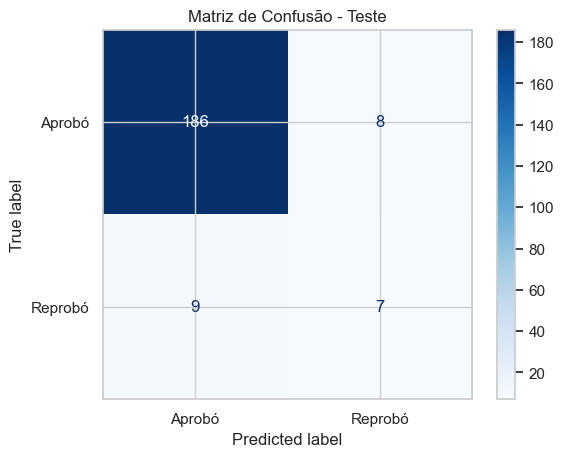

In [63]:
# Semana 8

best_ab_model_w8 = grid_search['week8']
# Faz as previsões
y_pred = best_ab_model_w8.predict(X_test_w8)

print("Acurácia:", accuracy_score(y_test_w8, y_pred))
print("\nRelatório de Classificação da Semana 8:\n", classification_report(y_test_w8, y_pred))

# Verificando Overfitting e Underfitting
print(f"Erro treino = {mean_squared_error(y_train_w8, best_ab_model_w8.predict(X_train_w8)):.3f}")
print(f"Erro validação = {mean_squared_error(y_val, best_ab_model_w8.predict(X_val_w8)):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w8, best_ab_model_w8.predict(X_test_w8)):.3f}")

# Matriz de confusão para teste
print("\nMATRIZ DE CONFUSÃO - TESTE - SEMANA 8")
cm_test = confusion_matrix(y_test_w8, y_pred)
print(cm_test)

plt.figure(figsize=(8, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Aprobó', 'Reprobó'])
disp_test.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Teste')
plt.show()

Acurácia: 0.9571428571428572

Relatório de Classificação da Semana 12:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       194
           1       0.77      0.62      0.69        16

    accuracy                           0.96       210
   macro avg       0.87      0.80      0.83       210
weighted avg       0.95      0.96      0.96       210

Erro treino = 0.000
Erro validação = 0.072
Erro teste = 0.043

MATRIZ DE CONFUSÃO - TESTE - SEMANA 12
[[191   3]
 [  6  10]]


<Figure size 800x600 with 0 Axes>

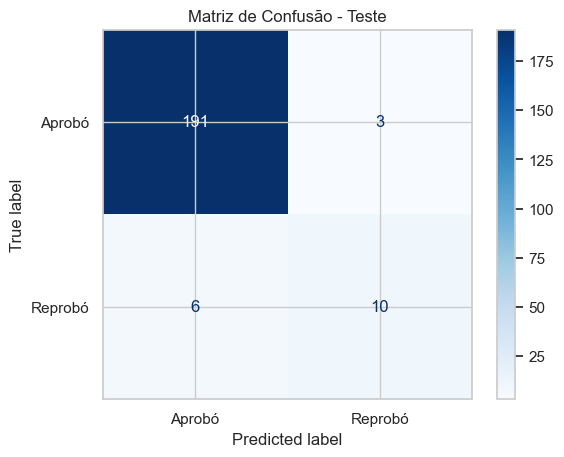

In [64]:
# Semana 12

best_ab_model_w12 = grid_search['week12']
# Faz as previsões
y_pred = best_ab_model_w12.predict(X_test_w12)

print("Acurácia:", accuracy_score(y_test_w12, y_pred))
print("\nRelatório de Classificação da Semana 12:\n", classification_report(y_test_w12, y_pred))

# Verificando Overfitting e Underfitting
print(f"Erro treino = {mean_squared_error(y_train_w12, best_ab_model_w12.predict(X_train_w12)):.3f}")
print(f"Erro validação = {mean_squared_error(y_val, best_ab_model_w12.predict(X_val_w12)):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w12, best_ab_model_w12.predict(X_test_w12)):.3f}")

# Matriz de confusão para teste
print("\nMATRIZ DE CONFUSÃO - TESTE - SEMANA 12")
cm_test = confusion_matrix(y_test_w12, y_pred)
print(cm_test)

plt.figure(figsize=(8, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Aprobó', 'Reprobó'])
disp_test.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Teste')
plt.show()

Acurácia: 0.9761904761904762

Relatório de Classificação da Semana 8:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       194
           1       0.87      0.81      0.84        16

    accuracy                           0.98       210
   macro avg       0.93      0.90      0.91       210
weighted avg       0.98      0.98      0.98       210

Erro treino = 0.000
Erro validação = 0.024
Erro teste = 0.024

MATRIZ DE CONFUSÃO - TESTE - SEMANA 8
[[192   2]
 [  3  13]]


<Figure size 800x600 with 0 Axes>

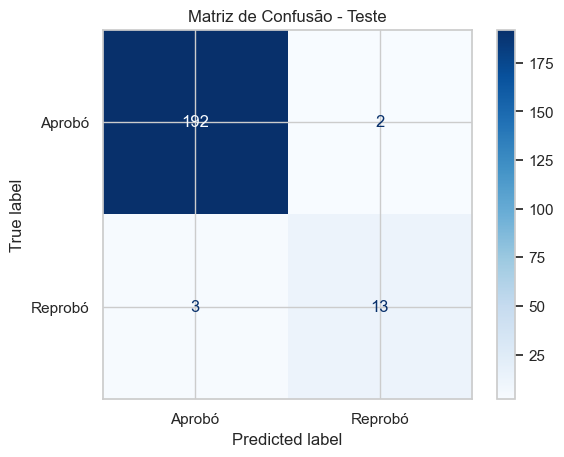

In [65]:
# Semana 15

best_ab_model_w15 = grid_search['week15']
# Faz as previsões
y_pred = best_ab_model_w15.predict(X_test_w15)

print("Acurácia:", accuracy_score(y_test_w15, y_pred))
print("\nRelatório de Classificação da Semana 8:\n", classification_report(y_test_w15, y_pred))

# Verificando Overfitting e Underfitting
print(f"Erro treino = {mean_squared_error(y_train_w15, best_ab_model_w15.predict(X_train_w15)):.3f}")
print(f"Erro validação = {mean_squared_error(y_val, best_ab_model_w15.predict(X_val_w15)):.3f}")
print(f"Erro teste = {mean_squared_error(y_test_w15, best_ab_model_w15.predict(X_test_w15)):.3f}")

# Matriz de confusão para teste
print("\nMATRIZ DE CONFUSÃO - TESTE - SEMANA 8")
cm_test = confusion_matrix(y_test_w15, y_pred)
print(cm_test)

plt.figure(figsize=(8, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Aprobó', 'Reprobó'])
disp_test.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Teste')
plt.show()

# 14. Nearest Centroid

Definição dos hiperparâmetros e criação do modelo da semana 4

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Resultados do GridSearch para week4
Melhores hiperparâmetros: {'metric': 'euclidean', 'shrink_threshold': 1.0}
Melhor score de validação: 0.6892244119516847
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Resultados do GridSearch para week8
Melhores hiperparâmetros: {'metric': 'manhattan', 'shrink_threshold': 1.0}
Melhor score de validação: 0.807495534768262
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Resultados do GridSearch para week12
Melhores hiperparâmetros: {'metric': 'euclidean', 'shrink_threshold': 0.5}
Melhor score de validação: 0.8245512063693882
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Resultados do GridSearch para week15
Melhores hiperparâmetros: {'metric': 'euclidean', 'shrink_threshold': 0.5}
Melhor score de validação: 0.8784442829897376
Accuracy (teste): 0.7857
Precision (teste): 0.1915
Recall (teste): 0.5625
Balanced Acc (teste): 0.6833
Erro treino (MSE): 0.207

<Figure size 700x500 with 0 Axes>

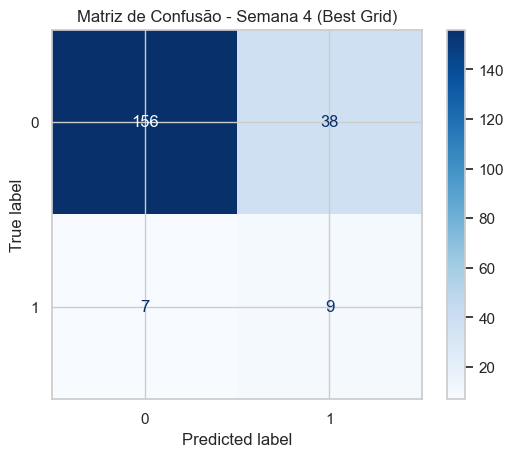

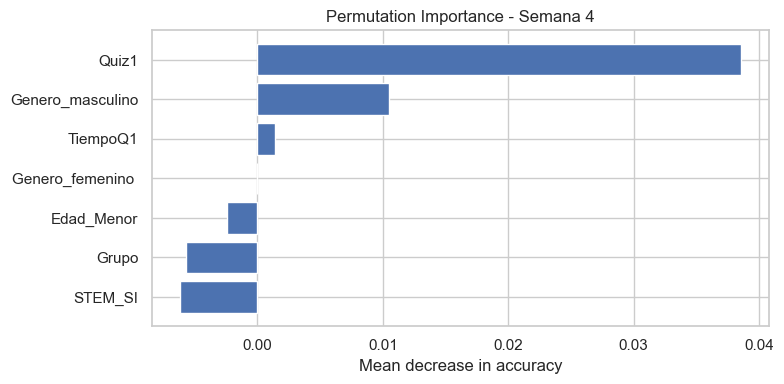


Relatório de Classificação da Semana 4:
               precision    recall  f1-score   support

           0       0.96      0.80      0.87       194
           1       0.19      0.56      0.29        16

    accuracy                           0.79       210
   macro avg       0.57      0.68      0.58       210
weighted avg       0.90      0.79      0.83       210



In [66]:
param_grid = {
    "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"],
    "shrink_threshold": [None, 0.1, 0.5, 1.0]
}

grid_search = hyperparameters_tuning(
    estimator=NearestCentroid(),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",   
    n_jobs=-1, 
    verbose=1
)

# Semana 4
best_nc_model_w4 = grid_search['week4']

y_pred = best_nc_model_w4.predict(X_test_w4)
y_tr_pred = best_nc_model_w4.predict(X_train_w4)
y_va_pred = best_nc_model_w4.predict(X_val_w4)
y_te_pred = best_nc_model_w4.predict(X_test_w4)

print(f"Accuracy (teste): {accuracy_score(y_test_w4, y_te_pred):.4f}")
print(f"Precision (teste): {precision_score(y_test_w4, y_te_pred, pos_label=1):.4f}")
print(f"Recall (teste): {recall_score(y_test_w4, y_te_pred, pos_label=1):.4f}")
print(f"Balanced Acc (teste): {balanced_accuracy_score(y_test_w4, y_te_pred):.4f}")

print(f"Erro treino (MSE): {mean_squared_error(y_train_w4, y_tr_pred):.3f}")
print(f"Erro validação (MSE): {mean_squared_error(y_val_w4,   y_va_pred):.3f}")
print(f"Erro teste (MSE): {mean_squared_error(y_test_w4,  y_te_pred):.3f}")

cm = confusion_matrix(y_test_w4, y_te_pred)
plt.figure(figsize=(7,5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusão - Semana 4 (Best Grid)")
plt.show()

try:
    result = permutation_importance(best_nc_model_w4, X_test_w4, y_test_w4, n_repeats=10, random_state=42, scoring="accuracy")
    importances = result.importances_mean
    feat_names = getattr(X_test_w4, "columns", [f"feat_{i}" for i in range(len(importances))])
    order = np.argsort(importances)
    plt.figure(figsize=(8, max(4, len(feat_names)*0.25)))
    plt.barh(np.array(feat_names)[order], importances[order])
    plt.title("Permutation Importance - Semana 4")
    plt.xlabel("Mean decrease in accuracy")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"[Aviso] Permutation importance não pôde ser calculada: {e}")
    
print("\nRelatório de Classificação da Semana 4:\n", classification_report(y_test_w4, y_pred))

Análise para a semana 8

Accuracy (teste): 0.7381
Precision (teste): 0.1905
Recall (teste): 0.7500
Balanced Acc (teste): 0.7436
Erro treino (MSE): 0.226
Erro validação (MSE): 0.244
Erro teste (MSE): 0.262


<Figure size 700x500 with 0 Axes>

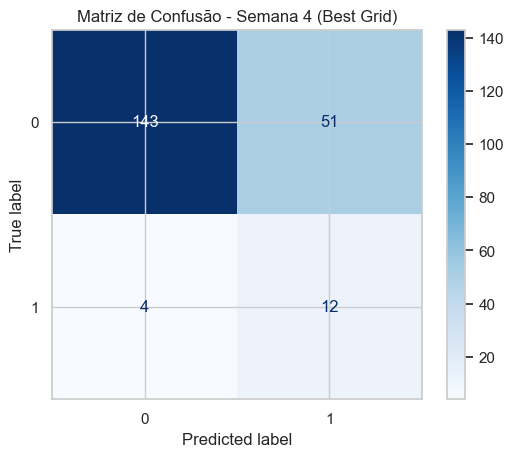

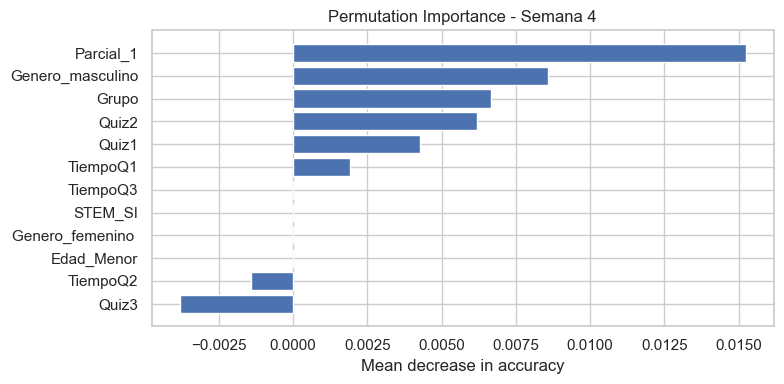


Relatório de Classificação da Semana 8:
               precision    recall  f1-score   support

           0       0.97      0.74      0.84       194
           1       0.19      0.75      0.30        16

    accuracy                           0.74       210
   macro avg       0.58      0.74      0.57       210
weighted avg       0.91      0.74      0.80       210



In [67]:
# Semana 8 
best_nc_model_w8 = grid_search['week8']

y_pred = best_nc_model_w8.predict(X_test_w8)
y_tr_pred = best_nc_model_w8.predict(X_train_w8)
y_va_pred = best_nc_model_w8.predict(X_val_w8)
y_te_pred = best_nc_model_w8.predict(X_test_w8)

print(f"Accuracy (teste): {accuracy_score(y_test_w8, y_te_pred):.4f}")
print(f"Precision (teste): {precision_score(y_test_w8, y_te_pred, pos_label=1):.4f}")
print(f"Recall (teste): {recall_score(y_test_w8, y_te_pred, pos_label=1):.4f}")
print(f"Balanced Acc (teste): {balanced_accuracy_score(y_test_w8, y_te_pred):.4f}")

print(f"Erro treino (MSE): {mean_squared_error(y_train_w8, y_tr_pred):.3f}")
print(f"Erro validação (MSE): {mean_squared_error(y_val_w8,   y_va_pred):.3f}")
print(f"Erro teste (MSE): {mean_squared_error(y_test_w8,  y_te_pred):.3f}")

cm = confusion_matrix(y_test_w8, y_te_pred)
plt.figure(figsize=(7,5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusão - Semana 4 (Best Grid)")
plt.show()

try:
    result = permutation_importance(best_nc_model_w8, X_test_w8, y_test_w8, n_repeats=10, random_state=42, scoring="accuracy")
    importances = result.importances_mean
    feat_names = getattr(X_test_w8, "columns", [f"feat_{i}" for i in range(len(importances))])
    order = np.argsort(importances)
    plt.figure(figsize=(8, max(4, len(feat_names)*0.25)))
    plt.barh(np.array(feat_names)[order], importances[order])
    plt.title("Permutation Importance - Semana 4")
    plt.xlabel("Mean decrease in accuracy")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"[Aviso] Permutation importance não pôde ser calculada: {e}")
    
print("\nRelatório de Classificação da Semana 8:\n", classification_report(y_test_w8, y_pred))

Analise para a semana 12

Accuracy (teste): 0.8857
Precision (teste): 0.3750
Recall (teste): 0.7500
Balanced Acc (teste): 0.8235
Erro treino (MSE): 0.095
Erro validação (MSE): 0.144
Erro teste (MSE): 0.114


<Figure size 700x500 with 0 Axes>

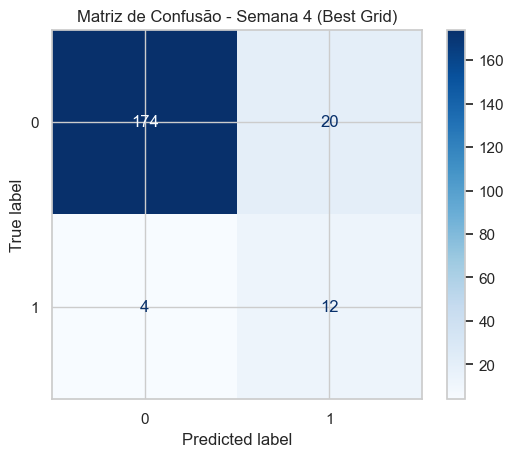

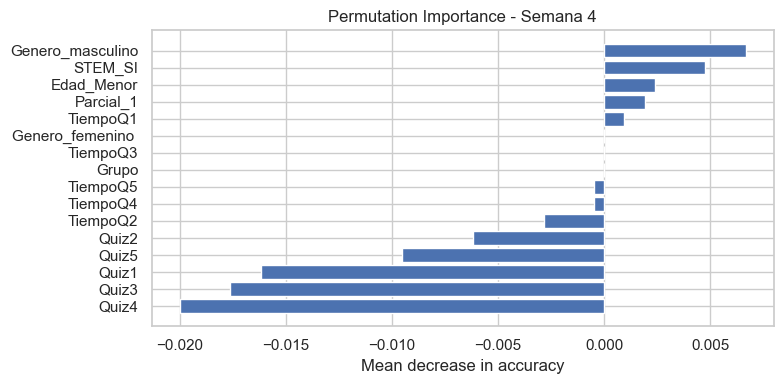


Relatório de Classificação da Semana 8:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94       194
           1       0.38      0.75      0.50        16

    accuracy                           0.89       210
   macro avg       0.68      0.82      0.72       210
weighted avg       0.93      0.89      0.90       210



In [68]:
# Semana 12
best_nc_model_w12 = grid_search['week12']

y_pred = best_nc_model_w12.predict(X_test_w12)
y_tr_pred = best_nc_model_w12.predict(X_train_w12)
y_va_pred = best_nc_model_w12.predict(X_val_w12)
y_te_pred = best_nc_model_w12.predict(X_test_w12)

print(f"Accuracy (teste): {accuracy_score(y_test_w12, y_te_pred):.4f}")
print(f"Precision (teste): {precision_score(y_test_w12, y_te_pred, pos_label=1):.4f}")
print(f"Recall (teste): {recall_score(y_test_w12, y_te_pred, pos_label=1):.4f}")
print(f"Balanced Acc (teste): {balanced_accuracy_score(y_test_w12, y_te_pred):.4f}")

print(f"Erro treino (MSE): {mean_squared_error(y_train_w12, y_tr_pred):.3f}")
print(f"Erro validação (MSE): {mean_squared_error(y_val_w12,   y_va_pred):.3f}")
print(f"Erro teste (MSE): {mean_squared_error(y_test_w12,  y_te_pred):.3f}")

cm = confusion_matrix(y_test_w12, y_te_pred)
plt.figure(figsize=(7,5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusão - Semana 4 (Best Grid)")
plt.show()

try:
    result = permutation_importance(best_nc_model_w12, X_test_w12, y_test_w12, n_repeats=10, random_state=42, scoring="accuracy")
    importances = result.importances_mean
    feat_names = getattr(X_test_w12, "columns", [f"feat_{i}" for i in range(len(importances))])
    order = np.argsort(importances)
    plt.figure(figsize=(8, max(4, len(feat_names)*0.25)))
    plt.barh(np.array(feat_names)[order], importances[order])
    plt.title("Permutation Importance - Semana 4")
    plt.xlabel("Mean decrease in accuracy")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"[Aviso] Permutation importance não pôde ser calculada: {e}")
    
print("\nRelatório de Classificação da Semana 8:\n", classification_report(y_test_w12, y_pred))

Analise para a semana 15

Accuracy (teste): 0.9524
Precision (teste): 0.6364
Recall (teste): 0.8750
Balanced Acc (teste): 0.9169
Erro treino (MSE): 0.050
Erro validação (MSE): 0.072
Erro teste (MSE): 0.048


<Figure size 700x500 with 0 Axes>

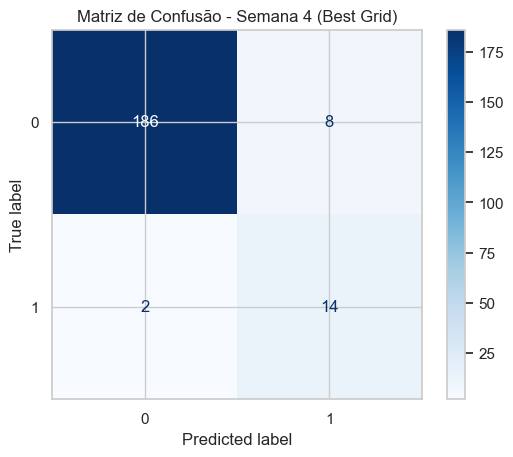

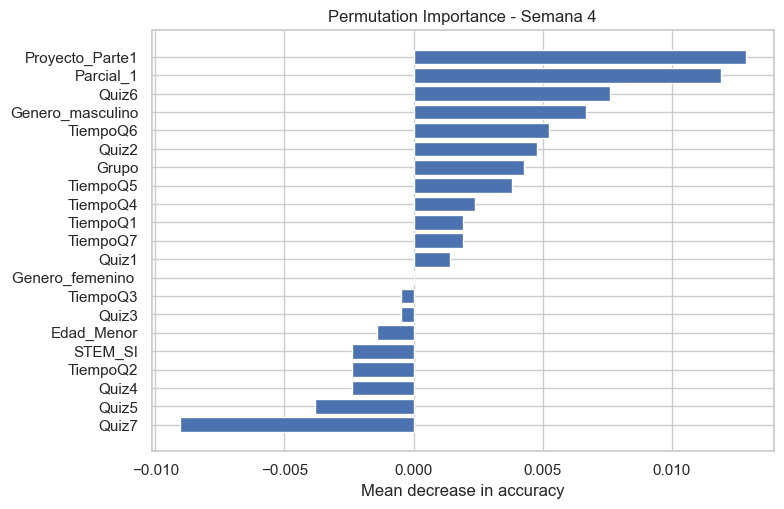


Relatório de Classificação da Semana 15:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       194
           1       0.64      0.88      0.74        16

    accuracy                           0.95       210
   macro avg       0.81      0.92      0.86       210
weighted avg       0.96      0.95      0.96       210



In [69]:
# Semana 15
best_nc_model_w15 = grid_search['week15']

y_pred = best_nc_model_w15.predict(X_test_w15)
y_tr_pred = best_nc_model_w15.predict(X_train_w15)
y_va_pred = best_nc_model_w15.predict(X_val_w15)
y_te_pred = best_nc_model_w15.predict(X_test_w15)

print(f"Accuracy (teste): {accuracy_score(y_test_w15, y_te_pred):.4f}")
print(f"Precision (teste): {precision_score(y_test_w15, y_te_pred, pos_label=1):.4f}")
print(f"Recall (teste): {recall_score(y_test_w15, y_te_pred, pos_label=1):.4f}")
print(f"Balanced Acc (teste): {balanced_accuracy_score(y_test_w15, y_te_pred):.4f}")

print(f"Erro treino (MSE): {mean_squared_error(y_train_w15, y_tr_pred):.3f}")
print(f"Erro validação (MSE): {mean_squared_error(y_val_w15,   y_va_pred):.3f}")
print(f"Erro teste (MSE): {mean_squared_error(y_test_w15,  y_te_pred):.3f}")

cm = confusion_matrix(y_test_w15, y_te_pred)
plt.figure(figsize=(7,5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusão - Semana 4 (Best Grid)")
plt.show()

try:
    result = permutation_importance(best_nc_model_w15, X_test_w15, y_test_w15, n_repeats=10, random_state=42, scoring="accuracy")
    importances = result.importances_mean
    feat_names = getattr(X_test_w15, "columns", [f"feat_{i}" for i in range(len(importances))])
    order = np.argsort(importances)
    plt.figure(figsize=(8, max(4, len(feat_names)*0.25)))
    plt.barh(np.array(feat_names)[order], importances[order])
    plt.title("Permutation Importance - Semana 4")
    plt.xlabel("Mean decrease in accuracy")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"[Aviso] Permutation importance não pôde ser calculada: {e}")
    
print("\nRelatório de Classificação da Semana 15:\n", classification_report(y_test_w15, y_pred))

# 15. Comparativo entre os Modelos

Comparativo entre os modelos em cada uma das semanas

NearestCentroid ROC AUC for Week 4: 0.7107
AdaBoost ROC AUC for Week 4: 0.7912
LinearDiscriminantAnalysis ROC AUC for Week 4: 0.7419
RandomForest ROC AUC for Week 4: 0.8077
LogisticRegression ROC AUC for Week 4: 0.7339


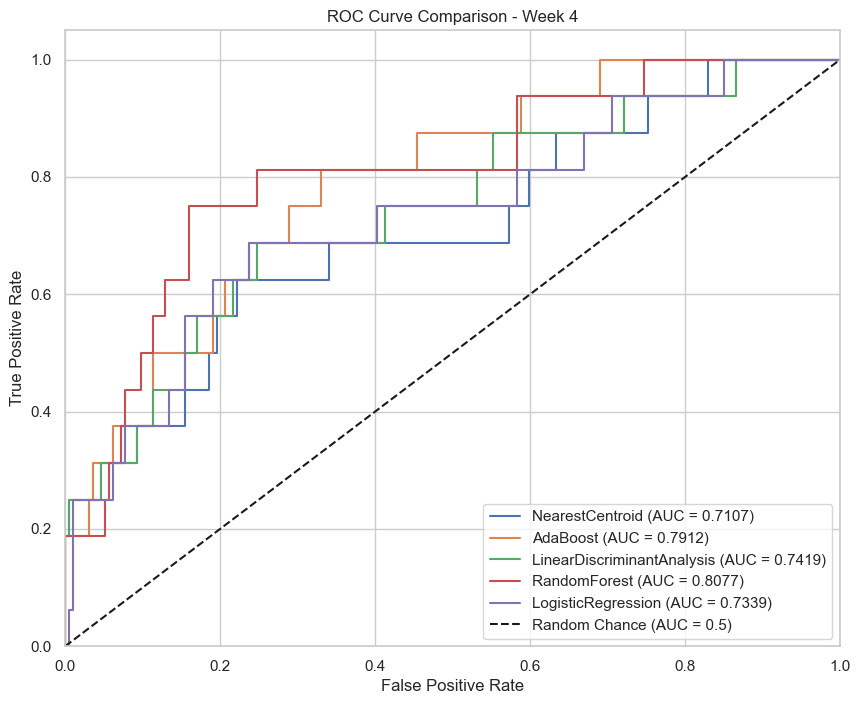

NearestCentroid ROC AUC for Week 8: 0.8438
AdaBoost ROC AUC for Week 8: 0.8756
LinearDiscriminantAnalysis ROC AUC for Week 8: 0.8947
RandomForest ROC AUC for Week 8: 0.8876
LogisticRegression ROC AUC for Week 8: 0.9111


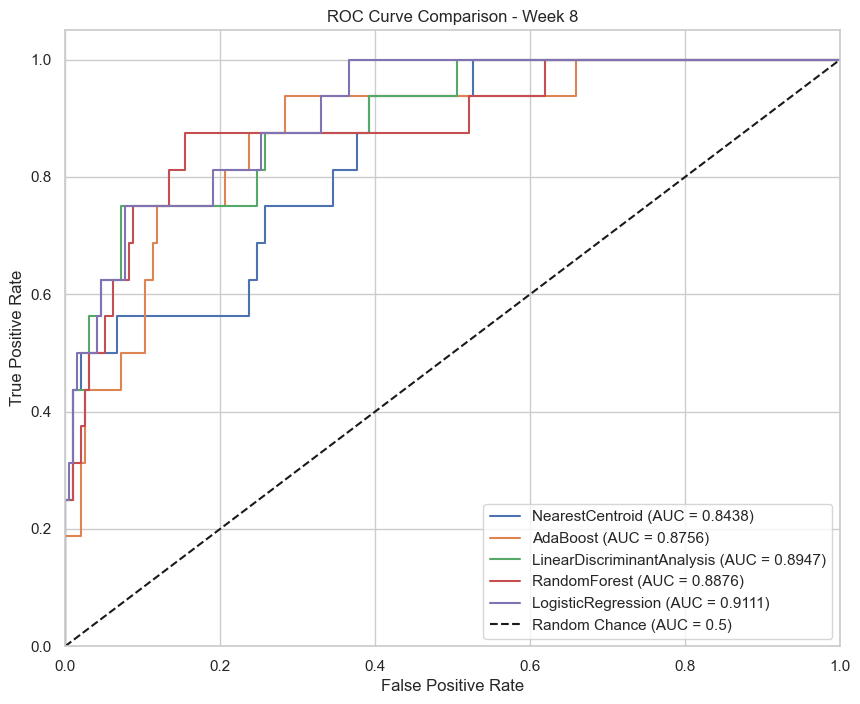

NearestCentroid ROC AUC for Week 12: 0.8779
AdaBoost ROC AUC for Week 12: 0.9575
LinearDiscriminantAnalysis ROC AUC for Week 12: 0.9166
RandomForest ROC AUC for Week 12: 0.9240
LogisticRegression ROC AUC for Week 12: 0.9256


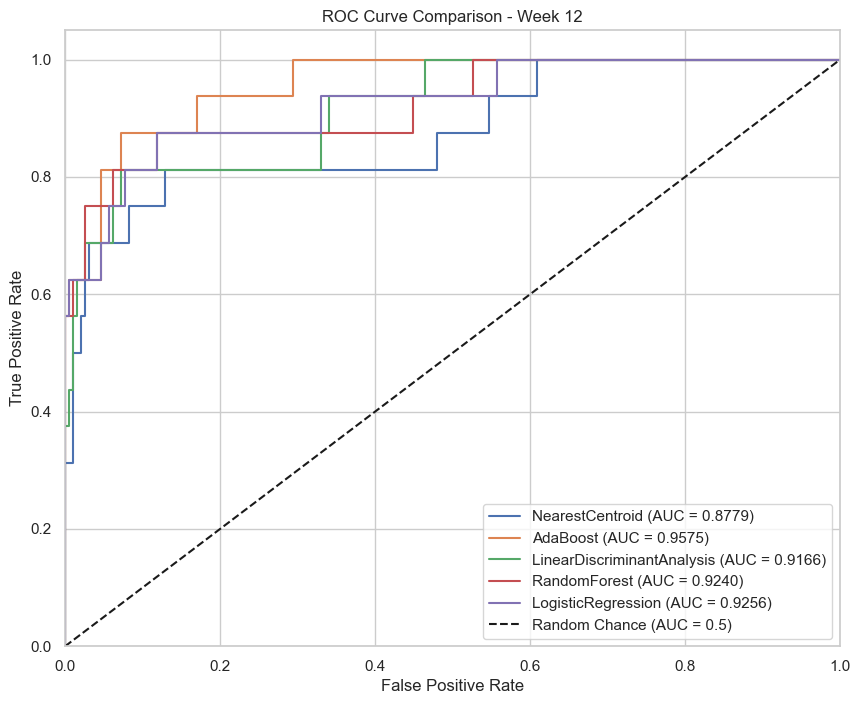

NearestCentroid ROC AUC for Week 15: 0.9594
AdaBoost ROC AUC for Week 15: 0.9807
LinearDiscriminantAnalysis ROC AUC for Week 15: 0.9652
RandomForest ROC AUC for Week 15: 0.9673
LogisticRegression ROC AUC for Week 15: 0.9774


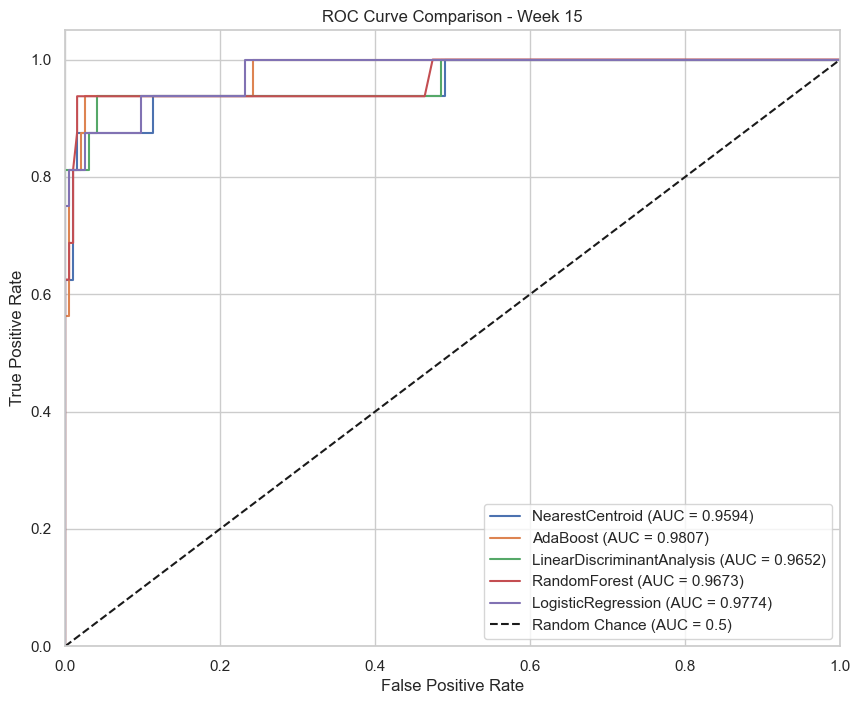

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.special import softmax

def compare_roc_auc(models, model_names, X_test, y_test, week_name):
    """
    Compares multiple models using ROC AUC scores and plots the ROC curves.

    Parameters:
    - models: List of trained models (e.g., [rf_model, ada_model])
    - model_names: List of model names (e.g., ['RandomForest', 'AdaBoost'])
    - X_test: Test features
    - y_test: Test labels (binary)
    - week_name: Name of the week for the plot title (e.g., 'Week 4')
    """
    plt.figure(figsize=(10, 8))
    
    for model, name in zip(models, model_names):
        # Assuming binary classification and positive class is 1
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test)[:, 1]
        else:
            if 'NearestCentroid' in name:
                # Special handling for NearestCentroid: compute pseudo-probabilities
                centroids = model.centroids_
                dist = pairwise_distances(X_test, centroids, metric=model.metric)
                pseudo_prob = softmax(-dist, axis=1)
                pos_label = 1  
                pos_idx = np.where(model.classes_ == pos_label)[0][0]
                y_prob = pseudo_prob[:, pos_idx]
            else:
                print(f"Skipping {name} as it does not support predict_proba or special handling")
                continue
        auc = roc_auc_score(y_test, y_prob)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        
        print(f"{name} ROC AUC for {week_name}: {auc:.4f}")
        
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve Comparison - {week_name}")
    plt.legend(loc="lower right")
    plt.show()

# Example usage for Week 4 (assuming you have trained models like best_rf_w4, best_ada_w4, etc.)
# Replace with your actual models and names
models_w4 = [best_nc_model_w4, best_ab_model_w4, best_lda_model_w4, best_rf_model_w4, best_lr_model_w4]  
model_names_w4 = ['NearestCentroid', 'AdaBoost', 'LinearDiscriminantAnalysis', 'RandomForest', 'LogisticRegression']
compare_roc_auc(models_w4, model_names_w4, X_test_w4, y_test_w4, 'Week 4')

# Repeat for other weeks as needed
# For Week 8
models_w8 = [best_nc_model_w8, best_ab_model_w8, best_lda_model_w8, best_rf_model_w8, best_lr_model_w8]  
model_names_w8 = ['NearestCentroid', 'AdaBoost', 'LinearDiscriminantAnalysis', 'RandomForest', 'LogisticRegression']
compare_roc_auc(models_w8, model_names_w8, X_test_w8, y_test_w8, 'Week 8')

# For Week 12
models_w12 = [best_nc_model_w12, best_ab_model_w12, best_lda_model_w12, best_rf_model_w12, best_lr_model_w12] 
model_names_w12 = ['NearestCentroid', 'AdaBoost', 'LinearDiscriminantAnalysis', 'RandomForest', 'LogisticRegression']
compare_roc_auc(models_w12, model_names_w12, X_test_w12, y_test_w12, 'Week 12')

# For Week 15
models_w15 = [best_nc_model_w15, best_ab_model_w15, best_lda_model_w15, best_rf_model_w15, best_lr_model_w15] 
model_names_w15 = ['NearestCentroid', 'AdaBoost', 'LinearDiscriminantAnalysis', 'RandomForest', 'LogisticRegression']
compare_roc_auc(models_w15, model_names_w15, X_test_w15, y_test_w15, 'Week 15')

In [71]:
# Salvando os modelos treinados usando pickle
import pickle

with open("model_week4.pkl", "wb") as f: 
  pickle.dump(best_rf_model_w4, f)
  
with open("model_week8.pkl", "wb") as f:
  pickle.dump(best_lda_model_w8, f)

with open("model_week12.pkl", "wb") as f:
  pickle.dump(best_rf_model_w12, f)

with open("model_week15.pkl", "wb") as f:
  pickle.dump(best_lda_model_w15, f)


In [72]:
# Export each week data to CSV
X_week4.to_csv("X_week4.csv", index=False)
y_week4.to_csv("y_week4.csv", index=False)
X_week8.to_csv("X_week8.csv", index=False)
y_week8.to_csv("y_week8.csv", index=False)
X_week12.to_csv("X_week12.csv", index=False)
y_week12.to_csv("y_week12.csv", index=False)
X_week15.to_csv("X_week15.csv", index=False)
y_week15.to_csv("y_week15.csv", index=False)

# 11. Análise Matemática

Modelo LDA treinado com sucesso para a semana 4.
Acurácia de Treinamento: 0.9713114754098361
Acurácia de Teste: 0.9761904761904762
Erro treino = 0.029
Erro validação = 0.029
Erro teste = 0.024


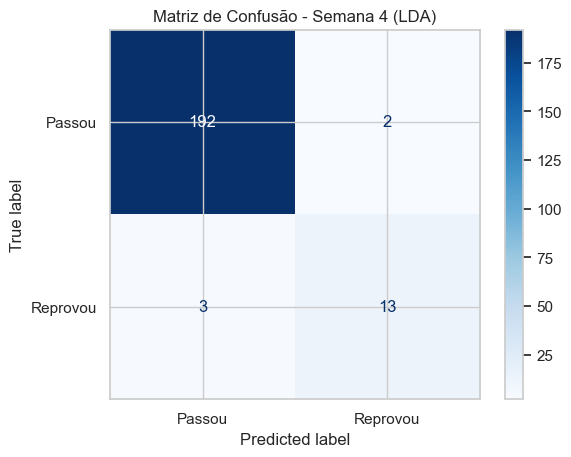


Relatório de classificação semana 4 (LDA):
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       194
           1       0.87      0.81      0.84        16

    accuracy                           0.98       210
   macro avg       0.93      0.90      0.91       210
weighted avg       0.98      0.98      0.98       210



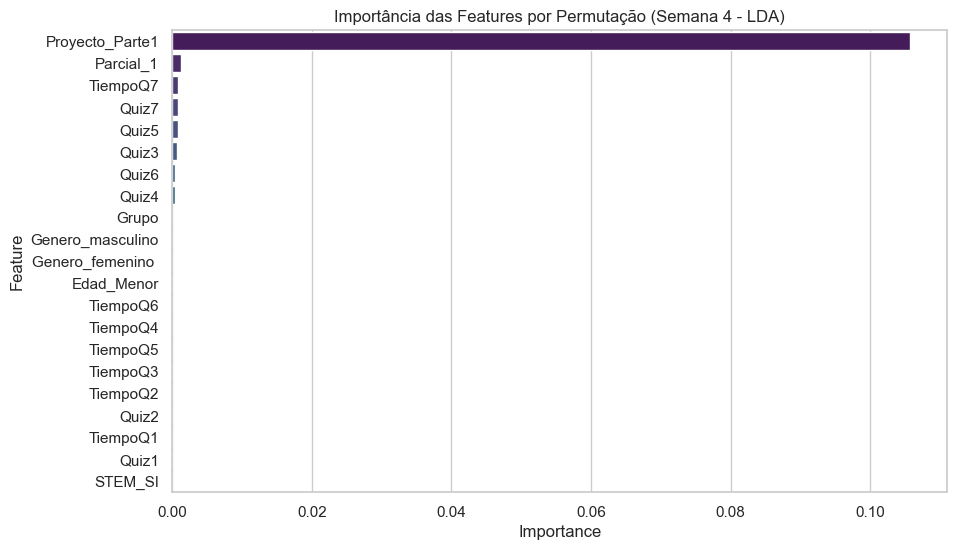

In [73]:
# 11. Linear Discriminant Analysis (LDA) - Semana 4
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Divisão dos dados já realizada anteriormente: X_train, X_val, X_test, y_train, y_val, y_test

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print("Modelo LDA treinado com sucesso para a semana 4.")

y_train_pred = lda.predict(X_train)
y_val_pred = lda.predict(X_val)
y_test_pred = lda.predict(X_test)

# Visualização do desempenho do modelo no terminal
print("Acurácia de Treinamento:", lda.score(X_train, y_train))
print("Acurácia de Teste:", lda.score(X_test, y_test))

print(f"Erro treino = {mean_squared_error(y_train, y_train_pred):.3f}")
print(f"Erro validação = {mean_squared_error(y_val, y_val_pred):.3f}")
print(f"Erro teste = {mean_squared_error(y_test, y_test_pred):.3f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Passou", "Reprovou"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - Semana 4 (LDA)")
plt.show()

print("\nRelatório de classificação semana 4 (LDA):\n", classification_report(y_test, y_test_pred))

# Importância das features via permutação
result = permutation_importance(lda, X_test, y_test, n_repeats=30, random_state=42)
importances = result.importances_mean
features = X_train.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Importância das Features por Permutação (Semana 4 - LDA)")
plt.show()

### Escalonamento

Seleção e Pré-Processamento das Variáveis

In [74]:
# Lista das variáveis quantitativas para escalonamento
escalation_variables = ['Parcial_1', 'CalcNotaQuiz', 'Calificación_Oficial']

Análise Estatística para Escalonamento

In [75]:
# Calculando estatísticas descritivas (Média, Desvio Padrão Populacional, Min, Max)
statistics = df[escalation_variables].agg(['mean', 'std', 'min', 'max']).round(3)
# Nota: O pandas .std() usa ddof=1 por padrão (desvio amostral). Para populacional, usamos ddof=0.
statistics.loc['std'] = df[escalation_variables].std(ddof=0).round(3)

print("Estatísticas para Escalonamento (Conjunto Completo):")
display(statistics)

KeyError: "['CalcNotaQuiz', 'Calificación_Oficial'] not in index"

Aplicação da Normalização Min-Max

In [ ]:
# Inicializando o scaler para o intervalo [0, 1]
scaler = MinMaxScaler()

# Aplicando a normalização e criando novas colunas
df[['Parcial_1_norm', 'CalcNotaQuiz_norm', 'Calificación_Oficial_norm']] = scaler.fit_transform(df[escalation_variables])

Histogramas Comparativos (Antes vs. Depois)

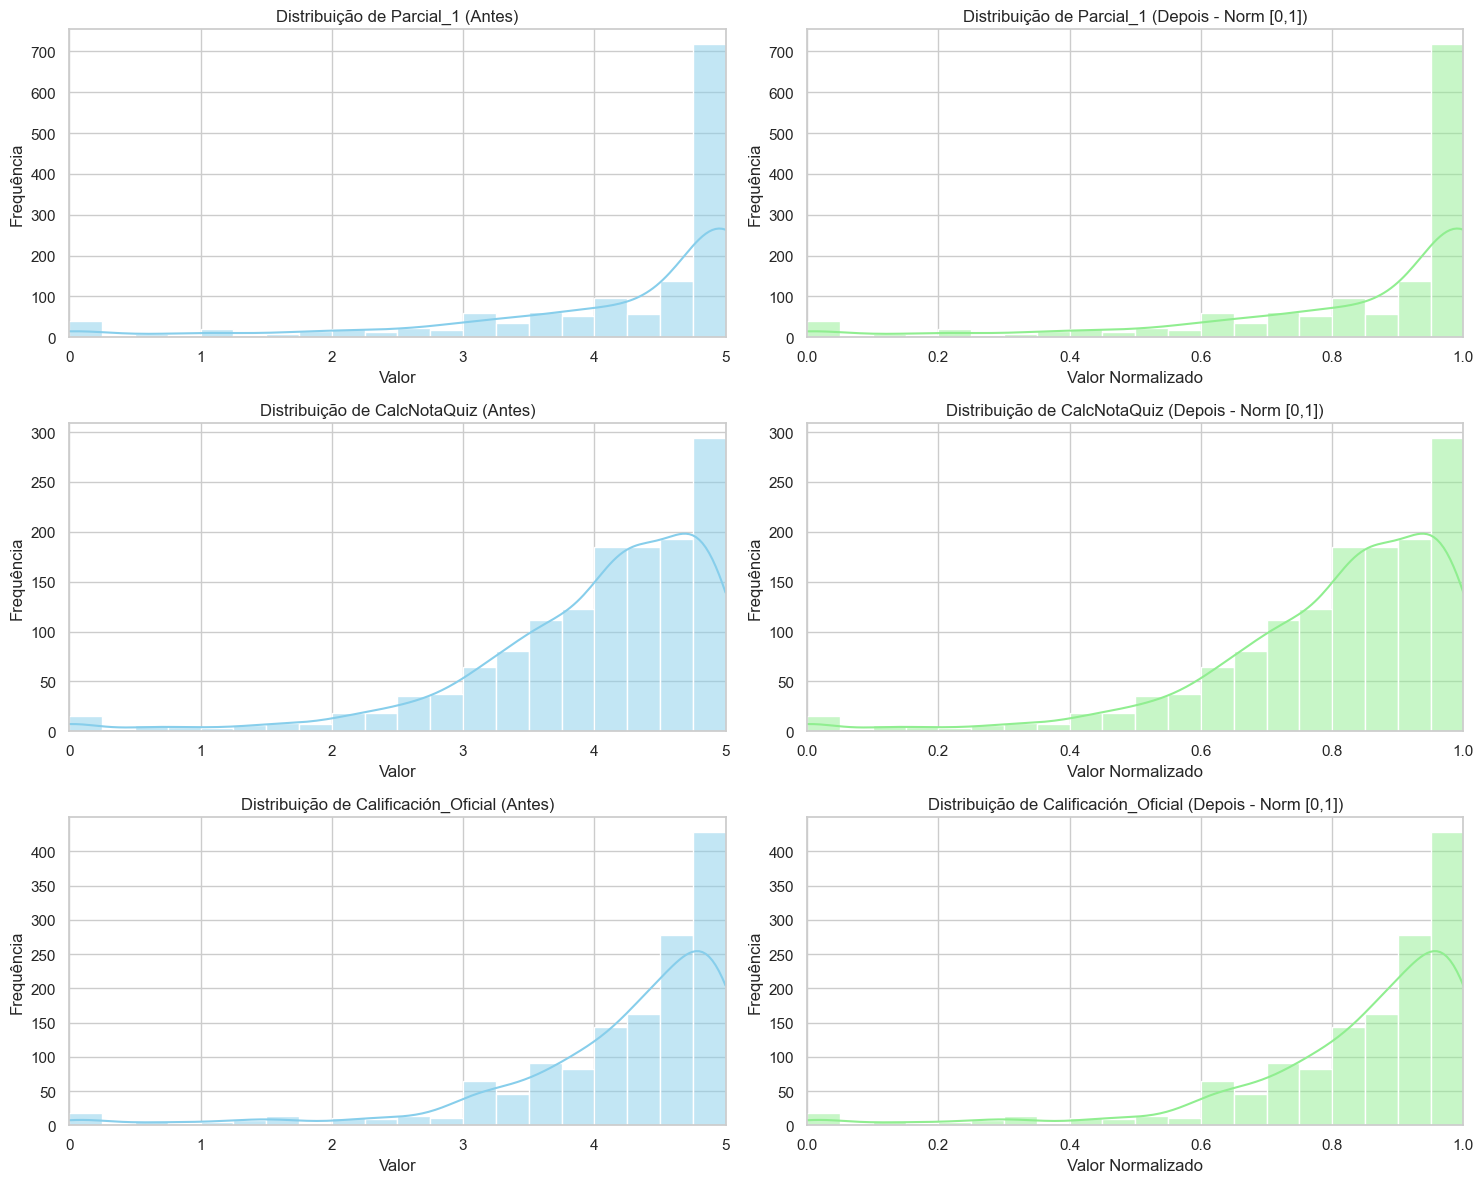

In [ ]:
# Configurações para os gráficos
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
cores = ['skyblue', 'lightgreen']

# Loop para criar os histogramas para cada variável
for i, var in enumerate(escalation_variables):
    # Histograma ANTES
    sns.histplot(df[var], kde=True, ax=axes[i, 0], color=cores[0], bins=20)
    axes[i, 0].set_title(f'Distribuição de {var} (Antes)')
    axes[i, 0].set_xlabel('Valor')
    axes[i, 0].set_ylabel('Frequência')
    axes[i, 0].set_xlim(0, 5) # Ajustando limite para melhor comparação

    # Histograma DEPOIS (Normalizado)
    var_norm = var + '_norm'
    sns.histplot(df[var_norm], kde=True, ax=axes[i, 1], color=cores[1], bins=20)
    axes[i, 1].set_title(f'Distribuição de {var} (Depois - Norm [0,1])')
    axes[i, 1].set_xlabel('Valor Normalizado')
    axes[i, 1].set_ylabel('Frequência')
    axes[i, 1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

Tabelas com 10 Primeiros Registros

In [ ]:
# Selecionando as colunas originais e normalizadas
colunas_para_tabela = escalation_variables + [v + '_norm' for v in escalation_variables]

print("Tabela com os 10 primeiros registros (Originais e Normalizados):")
df[colunas_para_tabela].head(10)

Tabela com os 10 primeiros registros (Originais e Normalizados):


Parcial_1  CalcNotaQuiz  Calificación_Oficial  Parcial_1_norm  \
0       4.20          1.56                  2.70            0.84   
1       3.75          2.66                  3.00            0.75   
2       0.00          1.28                  1.60            0.00   
3       2.80          3.13                  4.20            0.56   
4       1.80          2.50                  2.50            0.36   
5       2.10          3.17                  3.90            0.42   
6       5.00          3.13                  5.00            1.00   
7       1.20          1.68                  2.00            0.24   
8       4.10          3.63                  4.90            0.82   
9       5.00          2.50                  4.90            1.00   

   CalcNotaQuiz_norm  Calificación_Oficial_norm  
0               0.31                       0.54  
1               0.53                       0.60  
2               0.26                       0.32  
3               0.63                       0.84  
4               0.50                       0.50  
5               0.63                       0.78  
6               0.63                       1.00  
7               0.34                       0.40  
8               0.73                       0.98  
9               0.50                       0.98

# 12. Análise de Hipóteses

### 12.1. Alunos de cursos da área de STEM têm mais facilidade com a matéria de pensamento computacional. 
O gráfico abaixo mostra a proporção de alunos aprovados e reprovados entre os alunos de STEM e os que não são de STEM. Dessa forma, a partir da análise visual do gráfico, pode-se perceber que a diferença na proporção de aprovados é irrisória, portanto, a hipótese não se comprova.

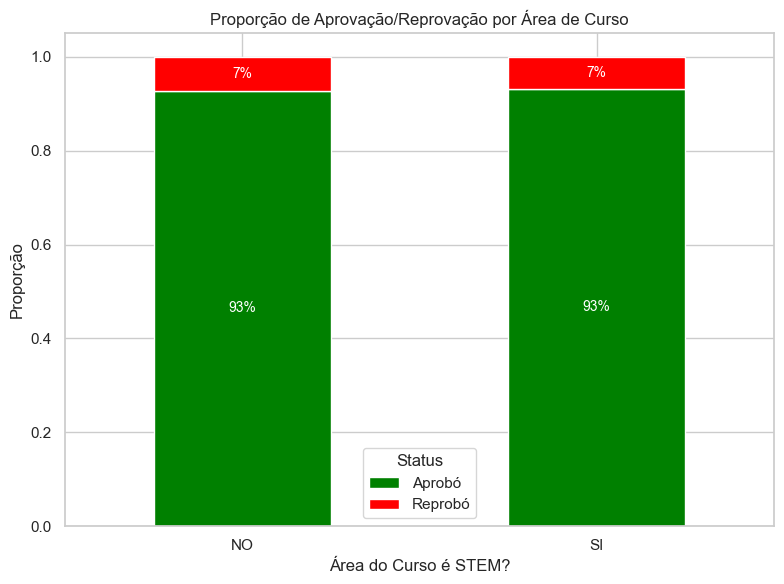

In [ ]:
df_summary = df.groupby('STEM')['Aprobo'].value_counts(normalize=True).unstack().fillna(0)
ax = df_summary.plot(kind='bar', stacked=True, figsize=(8, 6), color={'Aprobó': 'green', 'Reprobó': 'red'})

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x + width/2,
                y + height/2,
                f'{height:.0%}',
                ha='center', va='center', fontsize=10, color='white')

plt.title('Proporção de Aprovação/Reprovação por Área de Curso')
plt.xlabel('Área do Curso é STEM?')
plt.ylabel('Proporção')
plt.xticks(rotation=0)
plt.legend(title='Status')
plt.tight_layout()
plt.show()

### 12.2. Alunos que vão mal na primeira parcial possuem dificuldades para recuperarem suas notas durante o resto do curso. 
O gráfico abaixo mostra a distribuição das notas para os alunos aprovados e reprovados. Dessa forma, a partir da análise visual do gráfico, pode-se inferir que os dados de nota na primeira parcial dos alunos aprovados se concentram entre 4 e 5, o que pode ser considerado um bom desempenho, enquanto os dados dos alunos reprovados indicam um desempenho menos satisfatório, portanto, a hipótese se comprova.

<Figure size 800x600 with 0 Axes>

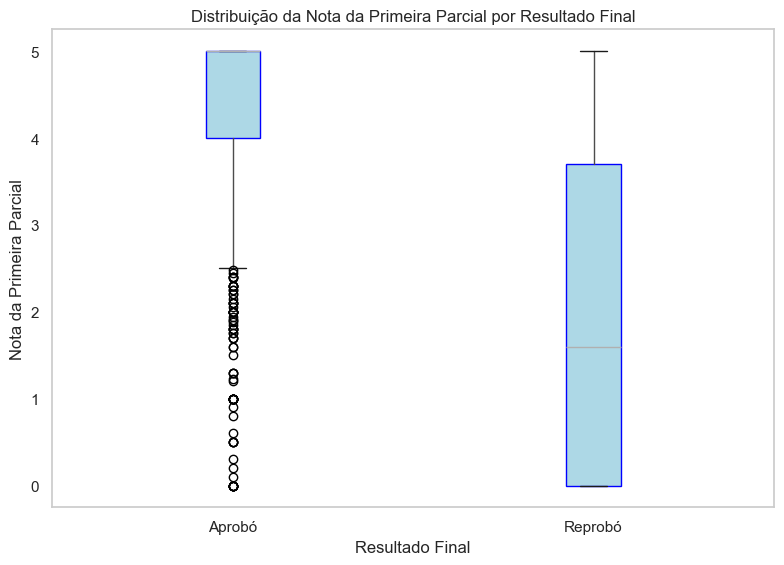

In [ ]:
plt.figure(figsize=(8, 6))
df.boxplot(column='Parcial_1', by='Aprobo', patch_artist=True, boxprops=dict(facecolor='lightblue', edgecolor='blue'))
plt.title('Distribuição da Nota da Primeira Parcial por Resultado Final')
plt.suptitle('')
plt.xlabel('Resultado Final')
plt.ylabel('Nota da Primeira Parcial')
plt.grid(False)
plt.tight_layout()
plt.show()

### 12.3. Alunos que não conseguem melhorar suas notas tendem a correr maior risco de reprovação. 
O gráfico abaixo mostra a proporção de alunos aprovados e reprovados entre os alunos que melhoram suas notas no quizes e os que não melhoram. Dessa forma, a partir da análise visual do gráfico, pode-se perceber que a diferença na proporção de aprovados é irrisória, portanto, a hipótese não se comprova.

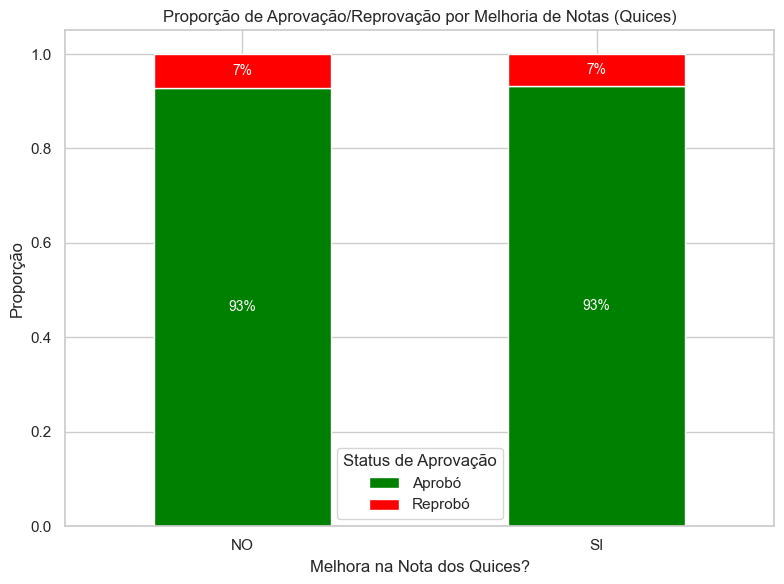

In [ ]:
f_summary = df.groupby('MejoraNotaQuices')['Aprobo'].value_counts(normalize=True).unstack().fillna(0)
ax = df_summary.plot(kind='bar', stacked=True, figsize=(8, 6), color={'Aprobó': 'green', 'Reprobó': 'red'})

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x + width/2,
                y + height/2,
                f'{height:.0%}',
                ha='center', va='center', fontsize=10, color='white')

plt.title('Proporção de Aprovação/Reprovação por Melhoria de Notas (Quices)')
plt.xlabel('Melhora na Nota dos Quices?')
plt.ylabel('Proporção')
plt.xticks(rotation=0)
plt.legend(title='Status de Aprovação')

plt.tight_layout()
plt.show()